In [1]:
import numpy as np
import numpy.matlib
import pickle
import matplotlib.pyplot as plt
import scipy.linalg as sl
import time
import pathlib
import nbimporter  # I installed it for importing an .ipynb file into another .ipynb like the pilot_assignemnt

import pilot_assignment
import APLocation_Generation
import functionRlocalscattering
#------------------------------
#import Power_optimizers

import os

from datetime import datetime

from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy.linalg as l 


import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
import time
import numpy.linalg as nl 


import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as Kr
from tensorflow.keras import initializers

import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


from __future__ import print_function
import keras
import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils 

import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist

C:\Users\afmb\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
K = 20
Ke = K
pmax = 1 #(in watt), in the next block, we have Pmax = 1000 mw
T = 1 # FL iterations


epsilon = 0.01#0.01
vareps = epsilon*np.ones([K,1])

# Number of APs:
L = 16
M = 4# CAREFUL: in my paper it is N.. !! this is M in the other codes!!


#Select length of pilot of UEs
tau_p = min(K,10) #Orthogonal sequences if tau_p=K, else tau_p = 10

#Select length of coherence block
tau_c = 200
prelogFactor = (tau_c-tau_p)/(tau_c)
preLogFactor = (tau_c-tau_p)/(tau_c)
#Number of AP antennas 


#Select the number of setups with random UE locations
nbrOfSetups = 2000

#Select the number of channel realizations per setup
nbrOfRealizations = 1# 100

## Model parameters

#Set the length in meters of the total square area
squareLength = 1000

#Number of APs per dimension
nbrAPsPerDim = np.round(np.int64(np.sqrt(L)))

#Pathloss exponent
alpha = 3.67 # or 3.76

#Average channel gain in dB at a reference distance of 1 meter.
constantTerm = -30.5

#Standard deviation of shadow fading
sigma_sf = 4  #here: put 4

#Define the antenna spacing (in number of wavelengths)
antennaSpacing = 1/2 #Half wavelength distance

#Distance between APs in vertical/horizontal direction
interAPDistance = np.int64(squareLength/nbrAPsPerDim)



## Propagation parameters

#Communication bandwidth
B = 20e6
P_u = 0.1 # watt: uplink transmit power


#Maximum downlink transmit power per AP (mW)
Pmax = 1000

#Compute downlink power per UE in case of equal power allocation
#rhoEqual = (Pmax/K)*np.ones((K,L))
rhoEqual = (pmax/K)*np.ones((K,L))
#Square roots of power coefficients for equal power allocation
gammaEqual = np.sqrt(rhoEqual)   

#Prepare power coefficients for the benchmark in [12]
rho_Giovanni19 = np.zeros((K,L,nbrOfSetups)) 

#Vertical distance between APs and UEs
distanceVertical = 10

#Define noise figure at AP (in dB)
noiseFigure = 7 ## it is 9 in paper eq(27)

#Compute noise power
noiseVariancedBm = -174 + 10*np.log10(B) + noiseFigure

#Angular standard deviation in the local scattering model (in degrees)
ASDdeg = 10

#Store identity matrix of size M x M
eyeM = np.identity(M)


# L = 3 not working, for the following function, L should be 4, 16, 25, ... otherwise it has an error!
def RandomAPLocations(L,squareLength):
    
    #Number of APs per dimension
    nbrAPsPerDim = np.round(np.int64(np.sqrt(L)))
    
    #Distance between APs in vertical/horizontal direction
    interAPDistance = np.int64(squareLength/nbrAPsPerDim)
    
    #Deploy APs on the grid
    locationsGridHorizontal = np.matlib.repmat(np.linspace(interAPDistance/2,squareLength-interAPDistance/2,nbrAPsPerDim),nbrAPsPerDim, 1)
    locationsGridVertical = np.conj(np.transpose(locationsGridHorizontal))
    APpositions = locationsGridHorizontal.reshape((L,1),order='F') + 1j*locationsGridVertical.reshape((L,1),order='F')
        
    #Randomness introduced in AP locations
    sensitivity = 0.5 # 0 means no movement, 1 means max distance is interAPDistance
    min_distance = interAPDistance * (1 - sensitivity)
    assert interAPDistance >= min_distance
#    print('Min distance between APs: ', min_distance)
    
    max_movement = (interAPDistance - min_distance)/2
    perturbation = np.random.uniform(
    low=-max_movement,
    high=max_movement,
    size=(len(APpositions), 2))
    perturbationXY = perturbation[:,0].reshape((L,1),order='F') + 1j*perturbation[:,1].reshape((L,1),order='F')
    APpositions += perturbationXY
    
    return (APpositions)




APpositions = RandomAPLocations(L,squareLength)
print(APpositions.shape)
APXpositions = APpositions.real
APYpositions = APpositions.imag




#Go through each random setup
#------------------------------------------------------------------------------------
for n in range(0, nbrOfSetups):
    #Output simulation progress
    print(n, 'setups out of', nbrOfSetups)
    
    UEpositions = np.zeros((K,1), dtype = 'complex')
    distances = np.zeros((K,L))
    
    #Prepare to store normalized spatial correlation matrices
    R = np.zeros((M,M,K,L), dtype = 'complex')
    
    #Prepare to store average channel gain numbers (in dB)
    channelGaindB = np.zeros((K,L))
    #Generate random UE locations together
    posXY = np.random.uniform(
            low = 0,
            high = squareLength,
            size = (K,2))
    UEXpositions = posXY[:,0:1]
    UEYpositions = posXY[:,1:2]
    UEpositions = UEXpositions + 1j*UEYpositions
    start = time.perf_counter()
    angletoUE = np.zeros((K,L))    
      
    for k in range(0,K):
        Xdist = np.matlib.repmat(UEXpositions[k,0], L, 1) - APXpositions
        Xdistabs = np.abs(Xdist)
        temp = np.asarray(Xdistabs > squareLength/2).nonzero()[0]
        Xdist[temp,0] = (squareLength - Xdistabs[temp,0]) * np.sign(-Xdist[temp,0])
        Ydist = np.matlib.repmat(UEYpositions[k,0], L, 1) - APYpositions
        Ydistabs = np.abs(Ydist)
        temp = np.asarray(Ydistabs > squareLength/2).nonzero()[0]
        Ydist[temp,0] = (squareLength - Ydistabs[temp,0]) * np.sign(-Ydist[temp,0])
        distances[k,:] = np.sqrt( distanceVertical**2 + Xdist[:,0]**2 + Ydist[:,0]**2)
        channelGaindB[k,:] = constantTerm - alpha*10*np.log10(distances[k,:])
        
        #Go through all APs
        for j in range(0,L):
            #Compute nominal angle between the new UE k and AP l
            angletoUE[k,j] = np.angle(Xdist[j] + 1j*Ydist[j])
            
            
           
                    
           ### R[:,:,k,j] = functionRlocalscattering.R(M,angletoUE[k,j],ASDdeg) #here % R = I*sqrt(beta)
           
    
    end = time.perf_counter() - start
    print('\n Time: ', end)
    #Generate random perturbations (shadowing) truncated at 3 dB
    for k1 in range(0,K):
        perturbation = sigma_sf*np.random.randn(1,L)
        # bool1 = np.logical_or(perturbation > 3, perturbation < -3)
        # while np.sum(bool1) != 0:
        #     perturbation[bool1] = sigma_sf*np.random.randn(1,np.sum(bool1)).reshape(np.sum(bool1))
        #     bool1 = np.logical_or(perturbation > 3, perturbation < -3)
            
        channelGainPerturbed = channelGaindB[k1,:] + perturbation
        channelGaindB[k1,:] = channelGainPerturbed
    
    channelGainOverNoise = channelGaindB - noiseVariancedBm
    g = np.zeros((M,nbrOfRealizations,K,L), dtype = 'complex')
    CH = np.sqrt(0.5)*( np.random.randn(M,nbrOfRealizations,K,L)+1j*np.random.randn(M,nbrOfRealizations,K,L) )
    betas = np.zeros((K,L))
    CorrR = np.zeros((M,M,K,L), dtype = 'complex')
    
    for j2 in range(0,L):
        for k2 in range(0,K):
            betas[k2,j2] = (10**(channelGainOverNoise[k2,j2]/10))
            
           ## CorrR[:,:,k2,j2] = betas[k2,j2] * R[:,:,k2,j2]
           ## Rsqrt = sl.sqrtm(CorrR[:,:,k2,j2])
           ## g[:,:,k2,j2] = np.matmul(Rsqrt,CH[:,:,k2,j2])
            ## this we need: g[:,:,k2,j2] = sqrt(betas)*CH
        g = CH*np.sqrt(betas)
            #np.identity(M)
            
            
            
#p_noise_dbm = -1
p_noise_dbm = -94 
rho_u = P_u /(10**(0.1*(p_noise_dbm - 30)))

rho_p = rho_u
p_p = tau_p * rho_p #my notation in paper

#p_noise_dbm = -94          
#rho_u = P_u /(10**(0.1*(p_noise_dbm - 30)))
#print(rho_u)


print(CH.shape)
print(betas.shape)

print((CH*np.sqrt(betas)).shape)
print(M)
print(K)
print(L)
print(betas.shape)

#Pilot assignment
pilotIndex = pilot_assignment.assign_pilots(K, tau_p, betas)
# for me:
print(pilotIndex)

#Generate realizations of normalized noise
Np = np.sqrt(0.5)*(np.random.randn(M,nbrOfRealizations,L,tau_p) + 1j*np.random.randn(M,nbrOfRealizations,L,tau_p))
print(Np.shape)
print(g.shape)
print(p_p)


#----------------------------------------

# Here, we do not have any summation over m=1,..,M (in paper it is n=1,..,N)
pilot_contamination = np.zeros([K,K])
for i in range(K):
    for j in range(K):
        if pilotIndex[i] == pilotIndex[j]:
            pilot_contamination[i][j] = 1
#print(pilot_contamination)
#beta_pilot_contamination = np.matmul(pilot_contamination, betas)

ckl = np.zeros([K,L]) # the same dimention as betas
ckl_denom = np.zeros([K,L])
gamma_kl = np.zeros([K,L])
beta_divies = np.zeros([K,K,L])


for l in range(L):
    for k in range(K):
        for k_prime in range(K):
            ckl_denom[k,l] += betas[k_prime,l]*pilot_contamination[k_prime,k]
            beta_divies[k,k_prime,l] = betas[k_prime,l]/betas[k,l]
        
        ckl[k,l] = np.sqrt(p_p)*betas[k,l]/(p_p*ckl_denom[k,l] + 1)
        gamma_kl[k,l] = np.sqrt(p_p)*betas[k,l]*ckl[k,l]
        
        
#gamma_kl = M* gamma_kl   
I_Lk = np.zeros([K,1])
I_Lk = M*((np.sum(gamma_kl, axis=1)).reshape(K,1))/rho_u 

##--------------------------- Compute R_j or R_k --------------------------------------###
# R_k = B log2(1 + p_k (sum_{l=1}^L  M * gamma_kl[k,l])**2 / (p_k * (sum_{l=1}^L  M * gamma_kl[k,l]*betas[k,l]) + I_pk + I_Mk ))
# I_Lk =  (sum_{l=1}^L  M * gamma_kl[k,l]/rho_u
# I_pk =  sum_{k' \neq k}^K p_k' * pilot_contamination(k,k') * (sum_{l=1}^L  M * gamma_kl[k,l]* betas[k',l]/betas[k,l] ) **2  

p = np.ones([K,1]) # users uplink powers

R_k = np.zeros([K,1])

I_pk = np.zeros([K,1])  # multiplied with p_k'

b_k_prime = np.zeros([K,K])
bk_k_prime = np.zeros([K,1]) 
    
I_pk_test = np.zeros([K,K])  # without p_k'
I_pk_test1 = np.zeros([K,K]) # without p_k'
#print(gamma_kl)
for k in range(K):
    for k_prime in range(K):
        for l in range(L):
            I_pk_test[k,k_prime] += M*gamma_kl[k,l]*beta_divies[k,k_prime,l]
        
        I_pk_test1[k,k_prime] = pilot_contamination[k_prime,k] * (I_pk_test[k,k_prime])**2
        if(k_prime ==k):
            I_pk_test1[k,k_prime] = 0
##I_Lk = np.zeros([K,1])
#----------------- My defined parameters--------------------------
a = np.zeros([K,1])
b = np.zeros([K,1])

a = (M*((np.sum(gamma_kl, axis=1)).reshape(K,1)))**2
b = (M*((np.sum(betas*gamma_kl, axis=1)).reshape(K,1)))



for k in range(K):
    for k_prime in range(K):
        for l in range(L):
            b_k_prime[k,k_prime] += M * gamma_kl[k,l] * betas[k_prime,l]
            
        if(k_prime ==k):
            b_k_prime[k,k_prime] = 0
            

#----------------------------------------------------------------- 
##bd_Ciraf10 = 32 * 3072 # bits

E = np.zeros([K,1])
ell = np.zeros([K,1])
nu = np.zeros([K,1]) 
#----------------------------------------------------------------
for k in range(K):
    for k_prime in range(K):
        I_pk[k] += p[k_prime] * I_pk_test1[k,k_prime]
        bk_k_prime [k] += p[k_prime] * b_k_prime[k,k_prime]
    
    R_k[k] = B * np.log2(1 + a[k] * p[k]/(b[k] * p[k] + bk_k_prime [k]  + I_pk[k]  + I_Lk[k]))
    E[k] = p[k]/R_k[k]
    ell[k] = 1/R_k[k] 
   # nu[k] = theta * E[k] + (1-theta)* ell[k]
    
#----------------------- Rate: ------------------------------            
def Rate_k(a, b, B, p, K, I_Lk, I_pk_test1, b_k_prime, preLogFactor):
    Rate = np.zeros([K,1])
    bk_k_prime = np.zeros([K,1])
    I_pk = np.zeros([K,1])
    
    for k in range(K):
        for k_prime in range(K):
            I_pk[k] += p[k_prime] * I_pk_test1[k,k_prime]
            bk_k_prime [k] += p[k_prime] * b_k_prime[k,k_prime]
    
        Rate[k] = preLogFactor*B * np.log2(1 + a[k] * p[k]/(b[k] * p[k] + bk_k_prime [k]  + I_pk[k]  + I_Lk[k]))
    return Rate


#------------ Power allocation:----------------------


def power_allocation_original(a, b, B, p0, K, I_Lk, I_pk_test1, b_k_prime, eps, theta_1, theta_2, rho_u, P_u, preLogFactor):
    p00 = p0
    p = p0
    powers = np.zeros([K,1])
    TT = 1000
    p1 = np.linspace(0.000001, 1, TT)
    for k in range(K):
        #
        R_k_TT = np.zeros([TT,1])
        E_TT = np.zeros([TT,1])
        ell_TT = np.zeros([TT,1])
        nu_TT = np.zeros([TT,1])
        NU = np.zeros([TT,K])
        #p = 1*np.ones([K,1]) #0.1*np.random.rand(K,1)#

        for t in range(TT):
            test = k
            E = 0
            ell = 0
            R_k_test = np.zeros([K,1])
            p[test] = p1[t]
    
            R_k_test = preLogFactor*Rate_k(a, b, B, p, K, I_Lk, I_pk_test1, b_k_prime)
            R_k_TT[t] =  R_k_test[test]
    
            for kk in range(K):
                ell += 1/ R_k_test[kk]
                E += P_u*p[kk] / R_k_test[kk]
        
        
    
            ell_TT[t] = ell
            E_TT[t] = E
            nu_TT[t] = theta_1 * E_TT[t] + theta_2 *  ell_TT[t]
            NU[t,test] = nu_TT[t]
        #min(nu_TT)
        ff=np.where(nu_TT == min(nu_TT))
        ff0 = ff[0].astype('int64')
        p[k] = p1[ff0]#p1[max(ff0,0)]

        p0 = p00
   
    return p, p0
#---------------------------parameters I_pk_test1, I_pk --------------------

def parameters(P, a, b, K, M, L, gamma_kl, rho_u, beta_divies, pilot_contamination, betas):
    R_k = np.zeros([K,1])
    I_Lk = np.zeros([K,1])
    I_pk = np.zeros([K,1])  # multiplied with p_k'
    I_Lk = M*((np.sum(gamma_kl, axis=1)).reshape(K,1))/rho_u 
    b_k_prime = np.zeros([K,K])
    bk_k_prime = np.zeros([K,1]) 
    
    I_pk_test = np.zeros([K,K])  # without p_k'
    I_pk_test1 = np.zeros([K,K]) # without p_k'


   
    for k in range(K):
        for k_prime in range(K):
            for l in range(L):
                I_pk_test[k,k_prime] += M*gamma_kl[k,l]*beta_divies[k,k_prime,l]
        
            I_pk_test1[k,k_prime] = pilot_contamination[k_prime,k] * (I_pk_test[k,k_prime])**2
            if(k_prime ==k):
                I_pk_test1[k,k_prime] = 0
            

    for k in range(K):
        for k_prime in range(K):
            I_pk[k] += p[k_prime] * I_pk_test1[k,k_prime]
            bk_k_prime [k] += p[k_prime] * b_k_prime[k,k_prime]            

    return I_pk_test1, I_pk               
#---------------------------------------------------------------
#b_k_prime[k_prime,j] += M * gamma_kl[k_prime,l] * betas[j,l]
#I_pk_test1[k_prime,j] = pilot_contamination[j,k_prime] * (I_pk_test[k_prime,j])**2
#B_tilde_k'^j =  b_k_prime[k_prime,j] + I_pk_test1[k_prime,j]

b_tilde_prime = b_k_prime + I_pk_test1

def p_j_gradient(a, b, K, j, M, p, b_k_prime, b_tilde_prime, I_Lk, I_pk, theta1, theta2, gamma_kl, betas, beta_divies, pilot_contamination):
    
    ln2 = np.log(2)
    C_j = 0
    L_j = 0
    C = np.zeros([K,1])
    C_tilde = np.zeros([K,1])
    C_temp = np.zeros([K,1])
    L_tilde = np.zeros([K,1])
    
 
    for j_prime in [x for x in range(K) if x != j]:
        c = 0
        for l in range(L):
            c += M* gamma_kl[j, l] * betas[j_prime, l]
        
        C[j_prime] = np.copy(c) * p[j_prime]
        
    C_j = I_pk[j] + I_Lk[j] + np.sum(C)
    
    L_j = a[j] * C_j /( ((a[j]+b[j])*p[j] + C_j) * (b[j]*p[j] + C_j) * ln2 )
    
   
    for k_prim in [x for x in range(K) if x != j]:
        
        for j_prim0 in [y for y in range(K) if y != k_prim]:
        
            c = 0
            for l in range(L):
                c += M* gamma_kl[k_prim, l] * betas[j_prim0, l]
            
            C_temp[k_prim] += p[j_prim0]* np.copy(c)
    
        C_tilde[k_prim] = b[k_prim]*p[k_prim] + I_pk[k_prim] + I_Lk[k_prim] -p[j]* b_tilde_prime[k_prim,j]  + C_temp[k_prim]
    
   
    for k_prim0 in [x for x in range(K) if x != j]:
        
        L_tilde[k_prim0] = - b_tilde_prime[k_prim0 , j] * a[k_prim0] * p[k_prim0] /( ln2*(b_tilde_prime[k_prim0 , j] * p[k_prim0] + C_tilde[k_prim0] )*( (a[k_prim0]+b_tilde_prime[k_prim0 , j]) * p[k_prim0] + C_tilde[k_prim0] ))
    
   
    return C_j, L_j, C_tilde, L_tilde


#========================= Partial_nu_j===========================================

def Partial_nu_j(j, p, P_u, theta_1, theta_2, a, b, K, M, L, b_tilde_prime, C_j, L_j, C_tilde, L_tilde ):
    
    ln2 = np.log(2)
    
    partial_nu_j = 0
    
    term_j = 0
    
    term_non_j = 0
    
    term_j = (theta_1*P_u)/(np.log2( 1 + p[j]*a[j]/( p[j]*a[j] + C_j ))) - (theta_1*P_u*p[j] + theta_2)*L_j/(np.log2( 1 + p[j]*a[j]/( p[j]*a[j] + C_j )))**2
  
   
    
    for k_prim in [x for x in range(K) if x != j]:
       
        term_non_j += (theta_1*P_u*p[k_prim] + theta_2)*L_tilde[k_prim] /(np.log2( 1 + p[k_prim]*a[k_prim]/( p[j]*b_tilde_prime[k_prim, j] + C_tilde[k_prim] )))**2
        

    
    partial_nu_j = term_j - term_non_j

    return partial_nu_j


#------------------------------generalized Dinkelbach-----------------------

# The following code is the generalized Dinkelbach

def objective_function_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, Lambda, P_u):
    K = len(p)
    d = I_pk_test1 + b_k_prime
    c = I_Lk
    f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
    g_values = [zeta[0] * P_u*p[j] + zeta[1] for j in range(K)]
    h_values = [f_values[j] - Lambda * g_values[j] for j in range(K)]
    return -np.min(h_values)


def update_lambda_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, P_u):
    K = len(p)
    d = I_pk_test1 + b_k_prime
    c = I_Lk
    f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
    g_values = [zeta[0] *P_u* p[j] + zeta[1] for j in range(K)]
    lambda_values = [f_values[j] / g_values[j] for j in range(K)]
    return np.min(lambda_values)

def find_optimal_p_generalized_Dinkelbach_CFmMIMO(a, b, I_Lk, I_pk_test1, b_k_prime, zeta, P_u, epsilon=1e-8):
    K = len(a)
    Lambda = 0
    #p = np.full(K, 0.5)  # Initialize with a constant value, you can also use np.random.rand(K) for a uniform distribution

    #p = p_main_EE + 0.0001#
    p = 0.25* np.ones(K)#
    bounds = [[0, 1] for _ in range(K)]
    while True:
        # Solve the optimization problem
        result = minimize(lambda p: objective_function_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, Lambda, P_u), 
                          p, bounds=bounds, method='SLSQP')
        #result = minimize(lambda p: objective_function_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, Lambda, P_u),
        #                  p, bounds=bounds, method='Powell',
        #                  options={'ftol': epsilon, 'L-BFGS-B': False})
        # Update p
        p = result.x

        # Update Lambda
        Lambda = update_lambda_CFmMIMO(p, a, b, I_Lk, I_pk_test1, b_k_prime, zeta, P_u)

        # Calculate F
        d = I_pk_test1 + b_k_prime
        c = I_Lk
        f_values = [np.log2(1 + a[j] * p[j] / (b[j] * p[j] + c[j] + np.sum(d[j,k] * p[k] for k in range(K) if k != j))) for j in range(K)]
        g_values = [zeta[0] *P_u* p[j] + zeta[1] for j in range(K)]
        F = np.min([f_values[j] - Lambda * g_values[j] for j in range(K)])

        # Check for convergence
        if np.abs(F) < epsilon:
            break

    return np.clip(p, 0, 1), Lambda, F  # Clip values to ensure they are within [0, 1]






#-----------------Parameters for theta computations-------------------------------------

# A = \bar{A} is vector K-by-1
# B = \bar{B} is vector K-by-1
# B_prime = the matrix of all B_prime_kk' K-by_K
# I_M is vector vector K-by_1

A_bar = a
B_bar = b
I_M = M*((np.sum(gamma_kl, axis=1)).reshape(K,1))/rho_u # I_Lk
B_prime = np.zeros([K,K])

B_prime0 = np.zeros([K,K])
B_prime1 = np.zeros([K,K])

for j in range(K):
  
    for k in [x for x in range(K) if x != j]:
    
        for l in range(L):
            B_prime0[j,k] += M * gamma_kl[k,l] * betas[j,l]
            B_prime1[j,k] += M * gamma_kl[k,l] * beta_divies[k,j,l]
            
        B_prime[j,k] = B_prime0[j,k] + pilot_contamination[j,k]*B_prime1[j,k]**2

B_tilde = B_prime        
#B_prime = I_pk_test1 + b_k_prime#np.transpose(I_pk_test1 + b_k_prime)
I_M

(16, 1)
0 setups out of 2000

 Time:  0.005041599999998425
1 setups out of 2000

 Time:  0.004888900000000973
2 setups out of 2000

 Time:  0.0036418999999980883
3 setups out of 2000

 Time:  0.003612900000000252
4 setups out of 2000

 Time:  0.007783800000002117
5 setups out of 2000

 Time:  0.0048816999999985455
6 setups out of 2000

 Time:  0.008692199999998707
7 setups out of 2000

 Time:  0.0065021999999999025
8 setups out of 2000

 Time:  0.006857100000001282
9 setups out of 2000

 Time:  0.005871799999997762
10 setups out of 2000

 Time:  0.0057192999999990946
11 setups out of 2000

 Time:  0.005295199999999056
12 setups out of 2000

 Time:  0.00595599999999763
13 setups out of 2000

 Time:  0.005253199999998515
14 setups out of 2000

 Time:  0.0057963000000000875
15 setups out of 2000

 Time:  0.005682700000001262
16 setups out of 2000

 Time:  0.011388900000000035
17 setups out of 2000

 Time:  0.01209479999999985
18 setups out of 2000

 Time:  0.007982399999999501
19 setups o

168 setups out of 2000

 Time:  0.006653299999999973
169 setups out of 2000

 Time:  0.005281199999998876
170 setups out of 2000

 Time:  0.005455200000000104
171 setups out of 2000

 Time:  0.004905000000000825
172 setups out of 2000

 Time:  0.005602899999999522
173 setups out of 2000

 Time:  0.004684999999998496
174 setups out of 2000

 Time:  0.005715399999999704
175 setups out of 2000

 Time:  0.00540550000000195
176 setups out of 2000

 Time:  0.006821999999999662
177 setups out of 2000

 Time:  0.00877309999999909
178 setups out of 2000

 Time:  0.005740700000000487
179 setups out of 2000

 Time:  0.006397200000002101
180 setups out of 2000

 Time:  0.007847800000000404
181 setups out of 2000

 Time:  0.004782800000000975
182 setups out of 2000

 Time:  0.004790299999999803
183 setups out of 2000

 Time:  0.005308400000000546
184 setups out of 2000

 Time:  0.003966099999999528
185 setups out of 2000

 Time:  0.0050306000000013285
186 setups out of 2000

 Time:  0.0040244999999


 Time:  0.006857000000000113
335 setups out of 2000

 Time:  0.009516800000000103
336 setups out of 2000

 Time:  0.008068399999999087
337 setups out of 2000

 Time:  0.005181100000001493
338 setups out of 2000

 Time:  0.006563800000002118
339 setups out of 2000

 Time:  0.00525779999999898
340 setups out of 2000

 Time:  0.005747799999998193
341 setups out of 2000

 Time:  0.005921000000000731
342 setups out of 2000

 Time:  0.005293200000000553
343 setups out of 2000

 Time:  0.0049421000000009485
344 setups out of 2000

 Time:  0.005259500000001083
345 setups out of 2000

 Time:  0.004956199999998745
346 setups out of 2000

 Time:  0.0037677000000009286
347 setups out of 2000

 Time:  0.003876699999999289
348 setups out of 2000

 Time:  0.004294900000001434
349 setups out of 2000

 Time:  0.0038586999999985494
350 setups out of 2000

 Time:  0.0037084000000007222
351 setups out of 2000

 Time:  0.003738899999998324
352 setups out of 2000

 Time:  0.003647399999998413
353 setups ou

491 setups out of 2000

 Time:  0.004840300000001463
492 setups out of 2000

 Time:  0.009751899999997704
493 setups out of 2000

 Time:  0.006243599999997684
494 setups out of 2000

 Time:  0.009248200000001816
495 setups out of 2000

 Time:  0.006130100000000027
496 setups out of 2000

 Time:  0.0045972000000027435
497 setups out of 2000

 Time:  0.004310799999998949
498 setups out of 2000

 Time:  0.00409349999999975
499 setups out of 2000

 Time:  0.003926700000000949
500 setups out of 2000

 Time:  0.004022199999997866
501 setups out of 2000

 Time:  0.004518499999999648
502 setups out of 2000

 Time:  0.004877699999997986
503 setups out of 2000

 Time:  0.005168000000001172
504 setups out of 2000

 Time:  0.005160200000002391
505 setups out of 2000

 Time:  0.0046621000000008905
506 setups out of 2000

 Time:  0.004612299999998015
507 setups out of 2000

 Time:  0.005452200000000573
508 setups out of 2000

 Time:  0.0048296999999983825
509 setups out of 2000

 Time:  0.0056610999


 Time:  0.005586300000000932
655 setups out of 2000

 Time:  0.008926100000000048
656 setups out of 2000

 Time:  0.006308499999999384
657 setups out of 2000

 Time:  0.006480699999997341
658 setups out of 2000

 Time:  0.005162599999998463
659 setups out of 2000

 Time:  0.004031600000001134
660 setups out of 2000

 Time:  0.005223099999998482
661 setups out of 2000

 Time:  0.007335199999999986
662 setups out of 2000

 Time:  0.004398600000001807
663 setups out of 2000

 Time:  0.004461200000001497
664 setups out of 2000

 Time:  0.0048181999999989955
665 setups out of 2000

 Time:  0.00412550000000067
666 setups out of 2000

 Time:  0.0036184000000005767
667 setups out of 2000

 Time:  0.00407859999999971
668 setups out of 2000

 Time:  0.004702200000000545
669 setups out of 2000

 Time:  0.004946499999999077
670 setups out of 2000

 Time:  0.0048266000000012355
671 setups out of 2000

 Time:  0.003675799999999896
672 setups out of 2000

 Time:  0.005101199999998585
673 setups out 

827 setups out of 2000

 Time:  0.007264299999999224
828 setups out of 2000

 Time:  0.014943000000002371
829 setups out of 2000

 Time:  0.004932099999997774
830 setups out of 2000

 Time:  0.0059421999999997865
831 setups out of 2000

 Time:  0.009094999999998521
832 setups out of 2000

 Time:  0.009328400000001125
833 setups out of 2000

 Time:  0.004939600000000155
834 setups out of 2000

 Time:  0.00424549999999968
835 setups out of 2000

 Time:  0.0041505000000015
836 setups out of 2000

 Time:  0.004582500000001488
837 setups out of 2000

 Time:  0.004694300000000595
838 setups out of 2000

 Time:  0.004194800000000498
839 setups out of 2000

 Time:  0.0058813999999998146
840 setups out of 2000

 Time:  0.009836099999997572
841 setups out of 2000

 Time:  0.010243100000000283
842 setups out of 2000

 Time:  0.006695000000000562
843 setups out of 2000

 Time:  0.006236200000000025
844 setups out of 2000

 Time:  0.007637599999998912
845 setups out of 2000

 Time:  0.0058262000000


 Time:  0.016272699999998252
992 setups out of 2000

 Time:  0.014694300000002158
993 setups out of 2000

 Time:  0.012024499999998994
994 setups out of 2000

 Time:  0.011036600000000618
995 setups out of 2000

 Time:  0.01389909999999972
996 setups out of 2000

 Time:  0.015167099999999323
997 setups out of 2000

 Time:  0.013867400000002306
998 setups out of 2000

 Time:  0.012049799999999777
999 setups out of 2000

 Time:  0.011514200000000585
1000 setups out of 2000

 Time:  0.012241500000001793
1001 setups out of 2000

 Time:  0.011700399999998723
1002 setups out of 2000

 Time:  0.012915100000000734
1003 setups out of 2000

 Time:  0.01158099999999962
1004 setups out of 2000

 Time:  0.01352650000000466
1005 setups out of 2000

 Time:  0.012608200000002512
1006 setups out of 2000

 Time:  0.012861399999998469
1007 setups out of 2000

 Time:  0.012416600000001665
1008 setups out of 2000

 Time:  0.010579500000005737
1009 setups out of 2000

 Time:  0.013557300000002215
1010 setu

1154 setups out of 2000

 Time:  0.006442299999996237
1155 setups out of 2000

 Time:  0.007007300000005046
1156 setups out of 2000

 Time:  0.008551099999998257
1157 setups out of 2000

 Time:  0.007920399999996164
1158 setups out of 2000

 Time:  0.006162299999999732
1159 setups out of 2000

 Time:  0.00651979999999952
1160 setups out of 2000

 Time:  0.007664800000000582
1161 setups out of 2000

 Time:  0.007487299999993979
1162 setups out of 2000

 Time:  0.009135200000002897
1163 setups out of 2000

 Time:  0.005029899999996701
1164 setups out of 2000

 Time:  0.008244699999998772
1165 setups out of 2000

 Time:  0.00872410000000201
1166 setups out of 2000

 Time:  0.007644800000001339
1167 setups out of 2000

 Time:  0.007451199999998437
1168 setups out of 2000

 Time:  0.008251199999996572
1169 setups out of 2000

 Time:  0.008313600000001031
1170 setups out of 2000

 Time:  0.0058165000000016676
1171 setups out of 2000

 Time:  0.009464399999998818
1172 setups out of 2000

 Tim

1322 setups out of 2000

 Time:  0.006746499999998434
1323 setups out of 2000

 Time:  0.0050112000000055446
1324 setups out of 2000

 Time:  0.005054999999998699
1325 setups out of 2000

 Time:  0.006100599999996348
1326 setups out of 2000

 Time:  0.00398309999999924
1327 setups out of 2000

 Time:  0.006118100000001903
1328 setups out of 2000

 Time:  0.007435000000000969
1329 setups out of 2000

 Time:  0.005309200000006342
1330 setups out of 2000

 Time:  0.00547979999999626
1331 setups out of 2000

 Time:  0.00625999999999749
1332 setups out of 2000

 Time:  0.0058081999999970435
1333 setups out of 2000

 Time:  0.00917530000000255
1334 setups out of 2000

 Time:  0.010549999999994952
1335 setups out of 2000

 Time:  0.00547159999999991
1336 setups out of 2000

 Time:  0.006576699999996549
1337 setups out of 2000

 Time:  0.013089000000000794
1338 setups out of 2000

 Time:  0.00524599999999964
1339 setups out of 2000

 Time:  0.006733300000000497
1340 setups out of 2000

 Time: 

1487 setups out of 2000

 Time:  0.0051897999999965805
1488 setups out of 2000

 Time:  0.004847300000001553
1489 setups out of 2000

 Time:  0.0070212000000040575
1490 setups out of 2000

 Time:  0.006505300000000602
1491 setups out of 2000

 Time:  0.0073263999999966245
1492 setups out of 2000

 Time:  0.006512600000000646
1493 setups out of 2000

 Time:  0.008768600000003346
1494 setups out of 2000

 Time:  0.00484890000000604
1495 setups out of 2000

 Time:  0.005275900000000888
1496 setups out of 2000

 Time:  0.008432600000006119
1497 setups out of 2000

 Time:  0.006376799999998184
1498 setups out of 2000

 Time:  0.006033600000002082
1499 setups out of 2000

 Time:  0.007246899999998391
1500 setups out of 2000

 Time:  0.004323799999994549
1501 setups out of 2000

 Time:  0.008892899999999315
1502 setups out of 2000

 Time:  0.005833500000001379
1503 setups out of 2000

 Time:  0.006844999999998436
1504 setups out of 2000

 Time:  0.006131400000001008
1505 setups out of 2000

 

1640 setups out of 2000

 Time:  0.0066855000000032305
1641 setups out of 2000

 Time:  0.007565400000004274
1642 setups out of 2000

 Time:  0.006054299999995294
1643 setups out of 2000

 Time:  0.005991999999999109
1644 setups out of 2000

 Time:  0.0049563999999975294
1645 setups out of 2000

 Time:  0.003999300000003814
1646 setups out of 2000

 Time:  0.004511200000003157
1647 setups out of 2000

 Time:  0.004078399999997373
1648 setups out of 2000

 Time:  0.004372199999998827
1649 setups out of 2000

 Time:  0.0062113000000039165
1650 setups out of 2000

 Time:  0.006709800000002986
1651 setups out of 2000

 Time:  0.009040499999997564
1652 setups out of 2000

 Time:  0.006240999999995722
1653 setups out of 2000

 Time:  0.007583400000001461
1654 setups out of 2000

 Time:  0.0047945999999967626
1655 setups out of 2000

 Time:  0.004700299999996105
1656 setups out of 2000

 Time:  0.00942009999999982
1657 setups out of 2000

 Time:  0.024840199999999868
1658 setups out of 2000




 Time:  0.007396399999997527
1792 setups out of 2000

 Time:  0.009195399999995857
1793 setups out of 2000

 Time:  0.006431399999996756
1794 setups out of 2000

 Time:  0.008057200000003206
1795 setups out of 2000

 Time:  0.005612399999996853
1796 setups out of 2000

 Time:  0.0042743999999999005
1797 setups out of 2000

 Time:  0.004715699999998435
1798 setups out of 2000

 Time:  0.004772400000000232
1799 setups out of 2000

 Time:  0.004283200000003262
1800 setups out of 2000

 Time:  0.0048746999999949026
1801 setups out of 2000

 Time:  0.0031202999999990766
1802 setups out of 2000

 Time:  0.004633300000001839
1803 setups out of 2000

 Time:  0.004648600000003
1804 setups out of 2000

 Time:  0.005532399999999882
1805 setups out of 2000

 Time:  0.003231099999993603
1806 setups out of 2000

 Time:  0.004339500000000385
1807 setups out of 2000

 Time:  0.003887999999996339
1808 setups out of 2000

 Time:  0.0037227000000044086
1809 setups out of 2000

 Time:  0.0040762999999941

1946 setups out of 2000

 Time:  0.004801700000001574
1947 setups out of 2000

 Time:  0.0040693999999987795
1948 setups out of 2000

 Time:  0.003488699999998346
1949 setups out of 2000

 Time:  0.003524400000003425
1950 setups out of 2000

 Time:  0.0037218000000009965
1951 setups out of 2000

 Time:  0.0053224999999983424
1952 setups out of 2000

 Time:  0.004317899999996655
1953 setups out of 2000

 Time:  0.004270099999999388
1954 setups out of 2000

 Time:  0.003053299999997705
1955 setups out of 2000

 Time:  0.003090000000000259
1956 setups out of 2000

 Time:  0.0032358999999999583
1957 setups out of 2000

 Time:  0.0032833000000067614
1958 setups out of 2000

 Time:  0.0032837999999983936
1959 setups out of 2000

 Time:  0.0035820000000015284
1960 setups out of 2000

 Time:  0.003915399999996794
1961 setups out of 2000

 Time:  0.0043693000000004645
1962 setups out of 2000

 Time:  0.004218600000001516
1963 setups out of 2000

 Time:  0.003900399999999138
1964 setups out of 2

array([[4.92350215e-12],
       [1.04686084e-12],
       [1.21563204e-12],
       [7.22587436e-13],
       [2.30942337e-11],
       [6.75994884e-13],
       [8.56563913e-13],
       [2.57066878e-11],
       [1.57722014e-10],
       [3.00852004e-12],
       [1.32715059e-12],
       [4.96622405e-12],
       [3.23461202e-12],
       [3.16073728e-13],
       [9.48084660e-13],
       [1.07306371e-12],
       [3.81427750e-12],
       [5.70012628e-12],
       [1.67681866e-12],
       [2.61909479e-13]])

In [3]:
# Compute each Lambda_j here: 
Y3 = np.copy(I_M)
for i in range(K):
    Y3[i]=np.sum(B_tilde[:,i])

X31 = np.log2(1+(A_bar/(B_bar + Y3 + I_M)))
Lambda_0 = 1 - X31/np.max(X31) + 0.00001
#print('Lambda_0:', Lambda_0.T)

#print('Lambda_old:', (Lambda_0/np.sum(Lambda_0)).T )
Lambda_old =  Lambda_0/np.sum(Lambda_0)

def logarithmic_transformation(X, K):
    return np.log1p(X * (K - 1)) / np.log(K)
Lambda_new = logarithmic_transformation(Lambda_old, K)
#print('------------------------------')
#print(Lambda_new.T)
Lambda = Lambda_old
#/np.max(Lambda_0) )

omegaa_q = 1
#Lambda =omegaa_q*Lambda_0

print(Lambda.T)
#Lambda = Lambda_0/np.max(Lambda_0)- 0.00001

[[0.05057192 0.05012402 0.05166688 0.04744156 0.05207428 0.0525143
  0.04753032 0.05070785 0.05172267 0.04783724 0.04815455 0.04853591
  0.04798624 0.05256177 0.05215051 0.05050541 0.04830974 0.0480132
  0.04990898 0.05168266]]


In [4]:
Lambda_1=np.min(Lambda) + (1-np.min(Lambda))* Lambda
Lambda_old.T 

array([[5.62916783e-02, 6.55518562e-02, 1.81231678e-02, 7.31776911e-02,
        8.48179078e-02, 2.44420277e-02, 6.99015903e-02, 7.89728775e-02,
        8.00119575e-02, 9.80103955e-07, 8.77736328e-02, 8.14468551e-02,
        3.31397381e-02, 1.96724822e-02, 5.35636537e-02, 2.68041387e-02,
        2.52932904e-02, 3.92186287e-02, 8.14389574e-02, 3.56888361e-04]])

In [3]:
Lambda = 0.05*np.ones(K)

In [3]:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the non-negative input data x with b bits.

    Parameters:
    x (numpy array): Non-negative input data to be quantized
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data
    """
    
    x_max = np.max(np.abs(x))
    x_min = np.min(np.abs(x))
    R = x_max - x_min
    # Number of quantization levels
    L = 2 ** b

    # Quantization step size
    delta = R / (L-1)

    x_clipped = np.clip(x, x_min, x_max)  # Ensure values are within [x_min, x_max]
    quantized = np.round((x_clipped - x_min) / delta) * delta + x_min

    return quantized
#-----------------------------------------------------------------------------
def adaptive_signQuant_lambda(main_vector, dim, lambda_j, b_j):
    mynum = 0
    l_norm = np.linalg.norm(main_vector, ord=np.inf)
    
    # Normalize each element of the vector 
    normalized_x = np.abs(main_vector) / l_norm

    # Identify the indices where the normalized value is greater than or equal to lambda
    indices = np.where(normalized_x >= lambda_j)[0]
    non_indices = np.where(normalized_x < lambda_j)[0]

    # Count the number of positive and negative elements among these indices
    positive_elements = main_vector[indices] > 0
    negative_elements = main_vector[indices] < 0

    n_max = np.sum(positive_elements)
    n_min = np.sum(negative_elements)

    x = np.copy(main_vector)
    x_q = mynum*np.ones_like(x)#*np.sign(x)
    x_q_temp = np.zeros_like(x)

    # Quantize values where normalized_x >= lambda_j
    for i in indices:
        x_q_temp[i] = np.abs(x[i])
    x_q0 = uniform_quantization(x_q_temp, b_j)
    for i in indices:
        x_q[i] = np.sign(x[i]) * x_q0[i]

    if n_max > 0:
        largest_values_indices = np.argsort(x_q)[-n_max:]
        largest_values = x_q[largest_values_indices]
    else:
        largest_values_indices = np.array([], dtype=int)
        largest_values = np.array([], dtype=x_q.dtype)

    # Find the n_min smallest values and their indices
    if n_min > 0:
        smallest_values_indices = np.argsort(x_q)[:n_min]
        smallest_values = x_q[smallest_values_indices]
    else:
        smallest_values_indices = np.array([], dtype=int)
        smallest_values = np.array([], dtype=x_q.dtype)

    if largest_values.size > 0:
        x_max = np.min(largest_values)
    else:
        x_max = 0

    if smallest_values.size > 0:
        x_min = np.max(smallest_values)
    else:
        x_min = 0
    
    if np.abs(x_min) > 0 and x_max > 0:
        x_min_me = min(x_max, np.abs(x_min))
    else:
        x_min_me = max(x_max,0, np.abs(x_min))
    
    if x_min_me <  1e-10:
        x_min_me =  0.0001
    
    for i in range(len(main_vector)):
        if x_q[i] ==mynum:
            x_q[i] = (np.sign(x[i]) == 1)*x_min_me/2 - (np.sign(x[i]) == -1)*x_min_me/2
    
    x_quant = x_q
    err = main_vector - x_quant
    
    # Return the results
    return x_q, x_max, x_min, err, n_max, n_min, x_min_me 



# FL + quantization + Bits

In [5]:
# Load CIFAR-100 dataset, NON-IID
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
x_test.shape




num_clients= K


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
# Load CIFAR-10 dataset


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
client_data = []
samples_per_client = len(x_train) // num_clients
#for i in range(num_clients):
#    start = i * samples_per_client
#    end = (i + 1) * samples_per_client
#    x_client = x_train[start:end]
#    y_client = y_train[start:end]
#    client_data.append((x_client, y_client))

# Assume x_train and y_train are numpy arrays, and num_clients is an integer
# Assume x_train and y_train are numpy arrays, and num_clients is an integer
np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class for controlled allocation
class_indices = {}
for label in np.unique(y_train):
    class_indices[label] = list(np.where(y_train == label)[0])  # Convert to list for easy pop operations

# Split data for each client with varying class proportions
client_data = []
num_classes = len(class_indices)
samples_per_client = len(x_train) // num_clients  # Ensures equal samples per client

for i in range(num_clients):
    x_client = []
    y_client = []

    # Determine class proportions for this client
    proportions = np.random.dirichlet(alpha=[0.6] * num_classes)

    # Track the number of samples allocated to this client
    allocated_samples = 0

    while allocated_samples < samples_per_client:
        for label in range(num_classes):
            # Calculate how many samples to take for this class based on proportions
            num_samples = int(proportions[label] * samples_per_client)

            # Adjust to ensure we fill the client's quota exactly
            if allocated_samples + num_samples > samples_per_client:
                num_samples = samples_per_client - allocated_samples

            # Ensure we don't sample more than available for the class
            num_samples = min(num_samples, len(class_indices[label]))

            # Select the samples and add them to the client's data
            class_samples = class_indices[label][:num_samples]
            x_client.extend(x_train[class_samples])
            y_client.extend(y_train[class_samples])

            # Remove used samples from class
            class_indices[label] = class_indices[label][num_samples:]

            # Update allocated sample count
            allocated_samples += len(class_samples)

            # If the client has enough samples, break the loop
            if allocated_samples >= samples_per_client:
                break

    # Shuffle the client's data to randomize order
    x_client = np.array(x_client)
    y_client = np.array(y_client)
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))
# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------

# client_data now contains non-IID datasets for each client

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------

KeyboardInterrupt: 

In [4]:
import numpy as np #NON-IID
import matplotlib.pyplot as plt
from keras.datasets import cifar100

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data


np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class for controlled allocation
class_indices = {label: np.where(y_train == label)[0].tolist() for label in np.unique(y_train)}

# Precompute the number of samples per client and the class proportions for all clients
samples_per_client = len(x_train) // num_clients
num_classes = len(class_indices)
class_proportions = np.random.dirichlet(alpha=[0.6] * num_classes, size=num_clients)

# Allocate data to clients
client_data = []
for i in range(num_clients):
    x_client = []
    y_client = []

    # Allocate samples based on precomputed proportions
    for label in range(num_classes):
        indices = class_indices[label]
        if len(indices) == 0:
            continue  # Skip if no samples left for this class

        # Calculate number of samples to allocate for this class to this client
        num_samples = int(class_proportions[i][label] * samples_per_client)

        # Adjust to ensure we fill the client's quota exactly
        remaining_samples = samples_per_client - len(x_client)
        if len(x_client) + num_samples > samples_per_client:
            num_samples = remaining_samples

        # Ensure we don't allocate more samples than available
        num_samples = min(num_samples, len(indices))

        # Select samples for this client
        chosen_indices = indices[:num_samples]
        x_client.extend(x_train[chosen_indices])
        y_client.extend(y_train[chosen_indices])

        # Remove selected samples from the class
        class_indices[label] = indices[num_samples:]

        # Stop allocation if client's quota is filled
        if len(x_client) >= samples_per_client:
            break

    # Handle the case where we haven't filled the client quota due to rounding
    if len(x_client) < samples_per_client:
        for label in range(num_classes):
            indices = class_indices[label]
            if len(indices) == 0:
                continue
            needed_samples = samples_per_client - len(x_client)
            num_samples = min(needed_samples, len(indices))
            chosen_indices = indices[:num_samples]
            x_client.extend(x_train[chosen_indices])
            y_client.extend(y_train[chosen_indices])
            class_indices[label] = indices[num_samples:]
            if len(x_client) >= samples_per_client:
                break

    # Convert lists to numpy arrays
    x_client = np.array(x_client)
    y_client = np.array(y_client)

    # Shuffle the client's data to randomize order
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique.flatten(), counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data, labels = client_data[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_client_data_distribution(client_data, num_clients=5)


NameError: name 'num_clients' is not defined

Client 0: 2500 samples
Label distribution: {0: 25, 1: 36, 2: 24, 3: 20, 4: 26, 5: 29, 6: 23, 7: 27, 8: 27, 9: 25, 10: 30, 11: 31, 12: 30, 13: 19, 14: 21, 15: 20, 16: 28, 17: 23, 18: 28, 19: 25, 20: 31, 21: 24, 22: 23, 23: 22, 24: 27, 25: 19, 26: 27, 27: 28, 28: 29, 29: 17, 30: 21, 31: 24, 32: 27, 33: 28, 34: 20, 35: 27, 36: 25, 37: 26, 38: 23, 39: 30, 40: 27, 41: 31, 42: 16, 43: 19, 44: 25, 45: 21, 46: 16, 47: 25, 48: 25, 49: 27, 50: 26, 51: 25, 52: 29, 53: 32, 54: 26, 55: 22, 56: 29, 57: 26, 58: 28, 59: 24, 60: 18, 61: 23, 62: 21, 63: 26, 64: 29, 65: 20, 66: 36, 67: 27, 68: 25, 69: 31, 70: 33, 71: 17, 72: 33, 73: 27, 74: 30, 75: 19, 76: 25, 77: 28, 78: 19, 79: 30, 80: 22, 81: 16, 82: 20, 83: 32, 84: 24, 85: 18, 86: 28, 87: 27, 88: 25, 89: 24, 90: 21, 91: 24, 92: 25, 93: 28, 94: 32, 95: 19, 96: 18, 97: 24, 98: 25, 99: 17}

Client 1: 2500 samples
Label distribution: {0: 29, 1: 19, 2: 24, 3: 32, 4: 23, 5: 28, 6: 15, 7: 25, 8: 21, 9: 20, 10: 26, 11: 21, 12: 23, 13: 21, 14: 26, 15: 21, 16:

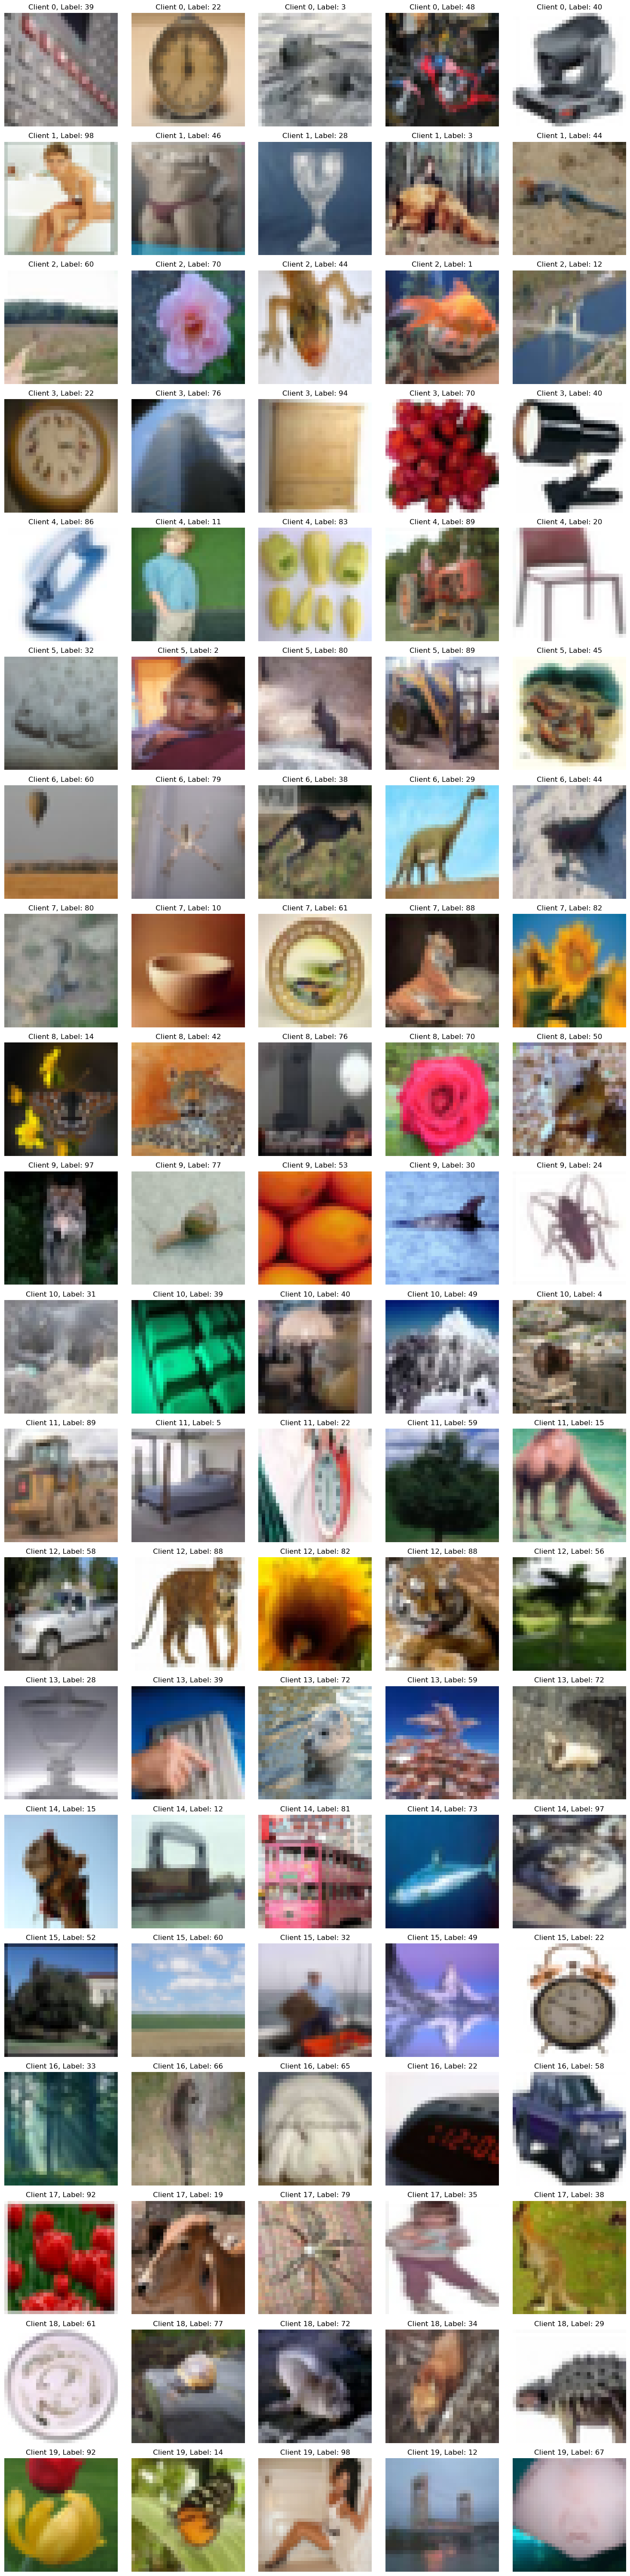

In [10]:
#IID:

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar100
num_clients= K
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data

# Number of clients


np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Split data into equal parts for each client
samples_per_client = len(x_train) // num_clients

# Allocate data to clients
client_data = []
for i in range(num_clients):
    start_idx = i * samples_per_client
    end_idx = (i + 1) * samples_per_client

    x_client = x_train[start_idx:end_idx]
    y_client = y_train[start_idx:end_idx]

    # Shuffle the client's data to randomize order
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique.flatten(), counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data, labels = client_data[client_id]
        
        for i in range(min(num_samples, len(data))):  # Ensure we don't exceed available samples
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_client_data_distribution(client_data, num_clients=num_clients)


In [16]:

# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(100, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs
num_clients= K
#local_epochs = 1
local_epochs0 = 5 #local_epochs FedAvg
local_epochs = 5
epoch_increase = 0
b_j = 10
Lambda = 0.2**np.ones(K)



# Federated Averaging algorithm
num_global_iterations = 100
k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.005)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


# Split the data into non-overlapping portions for each client

    
##Lambda0 = np.random.rand(num_clients)
#Lambda0 = np.abs(np.random.randn(num_clients))
#LAmbda = np.zeros(num_clients)

#for i in range(num_clients):
#    LAmbda[i] = (1 - Lambda0[i]/np.max(Lambda0) + 0.001)
#Lambda = LAmbda/np.sum(LAmbda)
#print('Lambda:', Lambda)
#print('sum lambda:', np.sum(Lambda))
# Initialize the global model
global_model = create_model()

global_model.summary()

# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()


#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

Model: "sequential_3628"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3628 (Conv2D)         (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3628 (MaxPooli (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_3628 (Flatten)       (None, 7200)              0         
_________________________________________________________________
dense_7256 (Dense)           (None, 64)                460864    
_________________________________________________________________
dense_7257 (Dense)           (None, 100)               6500      
Total params: 468,260
Trainable params: 468,260
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 3s 8ms/step - loss: 4.6149 - accuracy: 0.0097
Initial Test Loss: 4.6

In [17]:
myvector =np.array(global_model.get_weights())
for i in range(6):
    print(myvector[i].shape)
    #468260 for cifar100
    #462410 for cifar10

(3, 3, 3, 32)
(32,)
(7200, 64)
(64,)
(64, 100)
(100,)


C:\Users\afmb\AppData\Local\Temp\ipykernel_15244\2703776458.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  myvector =np.array(global_model.get_weights())


Global Iteration 1/100
Client 1/20


C:\Users\afmb\AppData\Local\Temp\ipykernel_15244\663287805.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights)


max: 0.023611631244421005 ----min: -0.028811082243919373
n_max: 789 n_min: 506 Lambda_j: 0.2
max error: 0.00288674065671162
max_model: 0.005773481779084527 min_model: -0.005773481779084527 x_min_me: 0.005773481779084527
percentage %: 0.27655575962072354
Client 2/20


C:\Users\afmb\AppData\Local\Temp\ipykernel_15244\663287805.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))


max: 0.029771365225315094 ----min: -0.02303844690322876
n_max: 552 n_min: 371 Lambda_j: 0.2
max error: 0.0029829568608065057
max_model: 0.005965913852580248 min_model: -0.005965913852580248 x_min_me: 0.005965913852580248
percentage %: 0.1971127151582454
Client 3/20
max: 0.02925156056880951 ----min: -0.024825898930430412
n_max: 393 n_min: 270 Lambda_j: 0.2
max error: 0.0029308747206354844
max_model: 0.0058617496741016125 min_model: -0.0058617496741016125 x_min_me: 0.0058617496741016125
percentage %: 0.14158800666296503
Client 4/20
max: 0.023109108209609985 ----min: -0.024788925424218178
n_max: 1150 n_min: 727 Lambda_j: 0.2
max error: 0.0024837387457375256
max_model: 0.004967477724305695 min_model: -0.004967477724305695 x_min_me: 0.004967477724305695
percentage %: 0.40084568402169735
Client 5/20
max: 0.028771663084626198 ----min: -0.023007137700915337
n_max: 578 n_min: 382 Lambda_j: 0.2
max error: 0.002882791208824778
max_model: 0.005765582534064878 min_model: -0.005765582534064878 x_min

max: 0.04959176480770111 ----min: -0.03212246298789978
n_max: 675 n_min: 478 Lambda_j: 0.2
max error: 0.004968871724043489
max_model: 0.009937743680917622 min_model: -0.009937743680917622 x_min_me: 0.009937743680917622
percentage %: 0.246230726519455
Client 12/20
max: 0.04557912424206734 ----min: -0.04815267398953438
n_max: 827 n_min: 514 Lambda_j: 0.2
max error: 0.00482468135325595
max_model: 0.009649362822927221 min_model: -0.009649362822927221 x_min_me: 0.009649362822927221
percentage %: 0.2863793618929654
Client 13/20
max: 0.04353061318397522 ----min: -0.03713712841272354
n_max: 747 n_min: 525 Lambda_j: 0.2
max error: 0.0043615712365454185
max_model: 0.008723143404413412 min_model: -0.008723143404413412 x_min_me: 0.008723143404413412
percentage %: 0.2716439584846026
Client 14/20
max: 0.04336182773113251 ----min: -0.03590072691440582
n_max: 794 n_min: 484 Lambda_j: 0.2
max error: 0.004344660100581275
max_model: 0.008689320317577872 min_model: -0.008689320317577872 x_min_me: 0.008689

max: 0.04796378314495087 ----min: -0.06872589141130447
n_max: 565 n_min: 589 Lambda_j: 0.2
max error: 0.006886024822372641
max_model: 0.013772050576067856 min_model: -0.013772050576067856 x_min_me: 0.013772050576067856
percentage %: 0.2464442830905907
------------------------------------------------------------------------------------------------------
N_total: 27196
313/313 [==============================] - 3s 8ms/step - loss: 4.3990 - accuracy: 0.0493
Global Test loss: 4.3990, Global Test accuracy: 0.0493
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 4.2152 - accuracy: 0.0649
_FedAvg Global Test loss: 4.2152, _FedAvg Global Test accuracy: 0.0649
------------------------------------------------------------------------------------------------------
Global Iteration 4/100
Client 1/20
max: 0.04828082025051117 ----min: -0.051075279712677
n_max: 565 n_min: 746 Lambda_j: 0

n_max: 898 n_min: 1139 Lambda_j: 0.2
max error: 0.0034185780553193396
max_model: 0.006837156197950171 min_model: -0.006837156197950171 x_min_me: 0.006837156197950171
percentage %: 0.43501473540340835
Client 7/20
max: 0.03053605556488037 ----min: -0.04771523177623749
n_max: 429 n_min: 681 Lambda_j: 0.2
max error: 0.004780847943394298
max_model: 0.009561703337369193 min_model: -0.009561703337369193 x_min_me: 0.009561703337369193
percentage %: 0.23704779396062017
Client 8/20
max: 0.029057171195745468 ----min: -0.048404544591903687
n_max: 398 n_min: 681 Lambda_j: 0.2
max error: 0.004849916781942458
max_model: 0.009699835426530065 min_model: -0.009699835426530065 x_min_me: 0.009699835426530065
percentage %: 0.23042754025541365
Client 9/20
max: 0.03268132731318474 ----min: -0.04143330827355385
n_max: 648 n_min: 820 Lambda_j: 0.2
max error: 0.004151430249556477
max_model: 0.008302862361758104 min_model: -0.008302862361758104 x_min_me: 0.008302862361758104
percentage %: 0.31350104642719856
Cli

max: 0.030380979180336 ----min: -0.03969740867614746
n_max: 532 n_min: 805 Lambda_j: 0.2
max error: 0.0039775009155054945
max_model: 0.007955003693656138 min_model: -0.007955003693656138 x_min_me: 0.007955003693656138
percentage %: 0.2855251356084227
Client 16/20
max: 0.03275178372859955 ----min: -0.04444330185651779
n_max: 441 n_min: 689 Lambda_j: 0.2
max error: 0.0044530180718964614
max_model: 0.008906038006438072 min_model: -0.008906038006438072 x_min_me: 0.008906038006438072
percentage %: 0.24131892538333405
Client 17/20
max: 0.03169667720794678 ----min: -0.04143649339675903
n_max: 521 n_min: 793 Lambda_j: 0.2
max error: 0.00415175008307141
max_model: 0.008303500631804107 min_model: -0.008303500631804107 x_min_me: 0.008303500631804107
percentage %: 0.2806133344723017
Client 18/20
max: 0.03013816475868225 ----min: -0.040004611015319824
n_max: 616 n_min: 825 Lambda_j: 0.2
max error: 0.004008281208531073
max_model: 0.008016564279707296 min_model: -0.008016564279707296 x_min_me: 0.0080

max: 0.03025589883327484 ----min: -0.04053948074579239
n_max: 514 n_min: 798 Lambda_j: 0.2
max error: 0.004061872750440593
max_model: 0.008123747363526335 min_model: -0.008123747363526335 x_min_me: 0.008123747363526335
percentage %: 0.28018622133003035
Client 2/20
max: 0.026909256353974342 ----min: -0.04072379320859909
n_max: 487 n_min: 743 Lambda_j: 0.2
max error: 0.0040803407289302625
max_model: 0.008160681923521812 min_model: -0.008160681923521812 x_min_me: 0.008160681923521812
percentage %: 0.26267458249690345
Client 3/20
max: 0.02979562059044838 ----min: -0.043474629521369934
n_max: 406 n_min: 702 Lambda_j: 0.2
max error: 0.004355960528303451
max_model: 0.0087119247818972 min_model: -0.0087119247818972 x_min_me: 0.0087119247818972
percentage %: 0.23662068081834878
Client 4/20
max: 0.03129495680332184 ----min: -0.037491776049137115
n_max: 589 n_min: 937 Lambda_j: 0.2
max error: 0.0037565027187894283
max_model: 0.007513014750804603 min_model: -0.007513014750804603 x_min_me: 0.007513

max: 0.02593238279223442 ----min: -0.05188745632767677
n_max: 283 n_min: 525 Lambda_j: 0.2
max error: 0.00519888887668023
max_model: 0.010397779616005609 min_model: -0.010397779616005609 x_min_me: 0.010397779616005609
percentage %: 0.17255370947764062
Client 11/20
max: 0.02684439718723297 ----min: -0.04167383909225464
n_max: 504 n_min: 797 Lambda_j: 0.2
max error: 0.004175526165072957
max_model: 0.008351062574694234 min_model: -0.008351062574694234 x_min_me: 0.008351062574694234
percentage %: 0.2778370990475377
Client 12/20
max: 0.026283301413059235 ----min: -0.040276892483234406
n_max: 481 n_min: 806 Lambda_j: 0.2
max error: 0.004035562761904051
max_model: 0.008071127037207285 min_model: -0.008071127037207285 x_min_me: 0.008071127037207285
percentage %: 0.27484730705163796
Client 13/20
max: 0.03020147979259491 ----min: -0.0414884053170681
n_max: 477 n_min: 736 Lambda_j: 0.2
max error: 0.004156949794245838
max_model: 0.008313903313781975 min_model: -0.008313903313781975 x_min_me: 0.008

max: 0.025852996855974197 ----min: -0.046120502054691315
n_max: 330 n_min: 573 Lambda_j: 0.2
max error: 0.004621065058768204
max_model: 0.009242133842826706 min_model: -0.009242133842826706 x_min_me: 0.009242133842826706
percentage %: 0.19284158373553154
Client 20/20
max: 0.027845848351716995 ----min: -0.03850748389959335
n_max: 577 n_min: 877 Lambda_j: 0.2
max error: 0.003858271146872293
max_model: 0.007716553469615481 min_model: -0.007716553469615481 x_min_me: 0.007716553469615481
percentage %: 0.31051125443129884
------------------------------------------------------------------------------------------------------
N_total: 25036
313/313 [==============================] - 2s 8ms/step - loss: 3.6838 - accuracy: 0.1501: 0s - loss: 3.6927 - accu
Global Test loss: 3.6838, Global Test accuracy: 0.1501
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 3.7273 - accuracy: 0.1472

max: 0.02374666929244995 ----min: -0.036796145141124725
n_max: 596 n_min: 944 Lambda_j: 0.2
max error: 0.0036868073550560027
max_model: 0.007373616572757155 min_model: -0.007373616572757155 x_min_me: 0.007373616572757155
percentage %: 0.32887711954896853
Client 6/20
max: 0.026577502489089966 ----min: -0.03839068114757538
n_max: 497 n_min: 795 Lambda_j: 0.2
max error: 0.0038465722272844434
max_model: 0.007693147248536611 min_model: -0.007693147248536611 x_min_me: 0.007693147248536611
percentage %: 0.27591508990731645
Client 7/20
max: 0.023744899779558182 ----min: -0.03295271098613739
n_max: 669 n_min: 1023 Lambda_j: 0.2
max error: 0.003301711603707815
max_model: 0.006603426932705928 min_model: -0.006603426932705928 x_min_me: 0.006603426932705928
percentage %: 0.361337718361594
Client 8/20
max: 0.027397923171520233 ----min: -0.040306806564331055
n_max: 417 n_min: 745 Lambda_j: 0.2
max error: 0.004038557515389496
max_model: 0.008077121550037014 min_model: -0.008077121550037014 x_min_me: 0

max: 0.025210224092006683 ----min: -0.03376457840204239
n_max: 633 n_min: 962 Lambda_j: 0.2
max error: 0.0033830570681557745
max_model: 0.0067661178616018475 min_model: -0.0067661178616018475 x_min_me: 0.0067661178616018475
percentage %: 0.3406227309614317
Client 15/20
max: 0.028434831649065018 ----min: -0.034655988216400146
n_max: 663 n_min: 971 Lambda_j: 0.2
max error: 0.0034723713919374718
max_model: 0.006944748371810391 min_model: -0.006944748371810391 x_min_me: 0.006944748371810391
percentage %: 0.34895143723572375
Client 16/20
max: 0.023967355489730835 ----min: -0.03627181053161621
n_max: 628 n_min: 929 Lambda_j: 0.2
max error: 0.003634269522249932
max_model: 0.007268544632435312 min_model: -0.007268544632435312 x_min_me: 0.007268544632435312
percentage %: 0.33250758125827534
Client 17/20
max: 0.02155613899230957 ----min: -0.04242556542158127
n_max: 437 n_min: 724 Lambda_j: 0.2
max error: 0.0042508434347684546
max_model: 0.008501701770698103 min_model: -0.008501701770698103 x_min

313/313 [==============================] - 4s 13ms/step - loss: 3.5852 - accuracy: 0.1739 0s - loss: 3.5873 
_FedAvg Global Test loss: 3.5852, _FedAvg Global Test accuracy: 0.1739
------------------------------------------------------------------------------------------------------
Global Iteration 15/100
Client 1/20
max: 0.023257475346326828 ----min: -0.04255909472703934
n_max: 381 n_min: 728 Lambda_j: 0.2
max error: 0.004264223634903542
max_model: 0.008528459842661842 min_model: -0.008528459842661842 x_min_me: 0.008528459842661842
percentage %: 0.23683423738948448
Client 2/20
max: 0.022304099053144455 ----min: -0.041162218898534775
n_max: 429 n_min: 733 Lambda_j: 0.2
max error: 0.004124267381831697
max_model: 0.008248538488953693 min_model: -0.008248538488953693 x_min_me: 0.008248538488953693
percentage %: 0.24815273565967624
Client 3/20
max: 0.02474418468773365 ----min: -0.04125720262527466
n_max: 398 n_min: 683 Lambda_j: 0.2
max error: 0.004133780598858934
max_model: 0.008267572373

max: 0.025984250009059906 ----min: -0.0363321453332901
n_max: 516 n_min: 869 Lambda_j: 0.2
max error: 0.003640316195061334
max_model: 0.007280635184090392 min_model: -0.007280635184090392 x_min_me: 0.007280635184090392
percentage %: 0.29577585102293596
Client 9/20
max: 0.026327036321163177 ----min: -0.03733167052268982
n_max: 547 n_min: 837 Lambda_j: 0.2
max error: 0.0037404617962890825
max_model: 0.007480931043158762 min_model: -0.007480931043158762 x_min_me: 0.007480931043158762
percentage %: 0.29556229445180027
Client 10/20
max: 0.0248580202460289 ----min: -0.03750427067279816
n_max: 561 n_min: 899 Lambda_j: 0.2
max error: 0.003757755555219781
max_model: 0.007515518561020159 min_model: -0.007515518561020159 x_min_me: 0.007515518561020159
percentage %: 0.31179259385811303
Client 11/20
max: 0.022697672247886658 ----min: -0.0351872444152832
n_max: 599 n_min: 963 Lambda_j: 0.2
max error: 0.0035256008742302514
max_model: 0.0070512073363959505 min_model: -0.0070512073363959505 x_min_me: 0

max: 0.023326124995946884 ----min: -0.03833581879734993
n_max: 513 n_min: 822 Lambda_j: 0.2
max error: 0.0038410617623073962
max_model: 0.00768215332693718 min_model: -0.00768215332693718 x_min_me: 0.00768215332693718
percentage %: 0.2850980224661513
Client 18/20
max: 0.025025546550750732 ----min: -0.03692210093140602
n_max: 587 n_min: 916 Lambda_j: 0.2
max error: 0.0036994247649043423
max_model: 0.007398856980389282 min_model: -0.007398856980389282 x_min_me: 0.007398856980389282
percentage %: 0.3209755264169479
Client 19/20
max: 0.022697657346725464 ----min: -0.038787685334682465
n_max: 487 n_min: 831 Lambda_j: 0.2
max error: 0.00388634607072042
max_model: 0.007772703317311736 min_model: -0.007772703317311736 x_min_me: 0.007772703317311736
percentage %: 0.2814675607568445
Client 20/20
max: 0.03306804597377777 ----min: -0.04152701795101166
n_max: 479 n_min: 749 Lambda_j: 0.2
max error: 0.004160817675219661
max_model: 0.00832164093837477 min_model: -0.00832164093837477 x_min_me: 0.00832

max: 0.025444425642490387 ----min: -0.03731922060251236
n_max: 520 n_min: 829 Lambda_j: 0.2
max error: 0.0037392022630758763
max_model: 0.007478436191119289 min_model: -0.007478436191119289 x_min_me: 0.007478436191119289
percentage %: 0.288087814462051
Client 4/20
max: 0.025936484336853027 ----min: -0.03865702450275421
n_max: 493 n_min: 848 Lambda_j: 0.2
max error: 0.0038732580517628983
max_model: 0.007746520061646739 min_model: -0.007746520061646739 x_min_me: 0.007746520061646739
percentage %: 0.2863793618929654
Client 5/20
max: 0.024920925498008728 ----min: -0.035932932049036026
n_max: 639 n_min: 961 Lambda_j: 0.2
max error: 0.003600312628121437
max_model: 0.007200636432113769 min_model: -0.007200636432113769 x_min_me: 0.007200636432113769
percentage %: 0.34169051381711013
Client 6/20
max: 0.026422254741191864 ----min: -0.03445630893111229
n_max: 612 n_min: 963 Lambda_j: 0.2
max error: 0.003452356043522076
max_model: 0.0069047344387859425 min_model: -0.0069047344387859425 x_min_me: 0

max: 0.025180816650390625 ----min: -0.038921624422073364
n_max: 454 n_min: 811 Lambda_j: 0.2
max error: 0.0038997647680254805
max_model: 0.00779954350588958 min_model: -0.00779954350588958 x_min_me: 0.00779954350588958
percentage %: 0.2701490624866527
Client 13/20
max: 0.025910355150699615 ----min: -0.03670705854892731
n_max: 556 n_min: 887 Lambda_j: 0.2
max error: 0.003677874759844671
max_model: 0.007355764420850536 min_model: -0.007355764420850536 x_min_me: 0.007355764420850536
percentage %: 0.3081621321488062
Client 14/20
max: 0.026178956031799316 ----min: -0.033339790999889374
n_max: 670 n_min: 1023 Lambda_j: 0.2
max error: 0.003340496910364528
max_model: 0.006680994286390344 min_model: -0.006680994286390344 x_min_me: 0.006680994286390344
percentage %: 0.3615512749327297
Client 15/20
max: 0.02825838327407837 ----min: -0.03566303849220276
n_max: 605 n_min: 939 Lambda_j: 0.2
max error: 0.0035732723699695088
max_model: 0.007146552190519614 min_model: -0.007146552190519614 x_min_me: 0.

313/313 [==============================] - 2s 7ms/step - loss: 3.2637 - accuracy: 0.2320
Global Test loss: 3.2637, Global Test accuracy: 0.2320
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 3.3746 - accuracy: 0.2109
_FedAvg Global Test loss: 3.3746, _FedAvg Global Test accuracy: 0.2109
------------------------------------------------------------------------------------------------------
Global Iteration 22/100
Client 1/20
max: 0.02167019620537758 ----min: -0.04045714810490608
n_max: 386 n_min: 780 Lambda_j: 0.2
max error: 0.004053615939458386
max_model: 0.008107248642723115 min_model: -0.008107248642723115 x_min_me: 0.008107248642723115
percentage %: 0.24900696194421904
Client 2/20
max: 0.02242112159729004 ----min: -0.03679237142205238
n_max: 510 n_min: 860 Lambda_j: 0.2
max error: 0.003686426451406055
max_model: 0.007372860353392707 min_model: -0.007372860353392707 x_

n_max: 883 n_min: 1155 Lambda_j: 0.2
max error: 0.0032351293982546465
max_model: 0.006470260659154442 min_model: -0.006470260659154442 x_min_me: 0.006470260659154442
percentage %: 0.43522829197454405
Client 8/20
max: 0.025824666023254395 ----min: -0.034832656383514404
n_max: 561 n_min: 961 Lambda_j: 0.2
max error: 0.0034900634346542586
max_model: 0.006980151083695457 min_model: -0.006980151083695457 x_min_me: 0.006980151083695457
percentage %: 0.325033101268526
Client 9/20
max: 0.025445446372032166 ----min: -0.037948813289403915
n_max: 512 n_min: 819 Lambda_j: 0.2
max error: 0.0038022967264828207
max_model: 0.007604600903546238 min_model: -0.007604600903546238 x_min_me: 0.007604600903546238
percentage %: 0.2842437961816085
Client 10/20
max: 0.02784750610589981 ----min: -0.03999906778335571
n_max: 489 n_min: 764 Lambda_j: 0.2
max error: 0.0040077230076461245
max_model: 0.008015453465872846 min_model: -0.008015453465872846 x_min_me: 0.008015453465872846
percentage %: 0.2675863836330244
C

max: 0.024066388607025146 ----min: -0.0386512354016304
n_max: 552 n_min: 835 Lambda_j: 0.2
max error: 0.00387267346966389
max_model: 0.007745359977843824 min_model: -0.007745359977843824 x_min_me: 0.007745359977843824
percentage %: 0.29620296416520736
Client 17/20
max: 0.025718480348587036 ----min: -0.034041255712509155
n_max: 694 n_min: 1015 Lambda_j: 0.2
max error: 0.003410774233950373
max_model: 0.006821561506416791 min_model: -0.006821561506416791 x_min_me: 0.006821561506416791
percentage %: 0.36496818007090076
Client 18/20
max: 0.025108888745307922 ----min: -0.03658079355955124
n_max: 578 n_min: 906 Lambda_j: 0.2
max error: 0.0036652123997987537
max_model: 0.007330462052500492 min_model: -0.007330462052500492 x_min_me: 0.007330462052500492
percentage %: 0.31691795156536967
Client 19/20
max: 0.022783920168876648 ----min: -0.03516262769699097
n_max: 624 n_min: 990 Lambda_j: 0.2
max error: 0.0035231218168936223
max_model: 0.007046274367432207 min_model: -0.007046274367432207 x_min_me

max: 0.021885469555854797 ----min: -0.033497024327516556
n_max: 692 n_min: 1014 Lambda_j: 0.2
max error: 0.0033562311921760306
max_model: 0.00671250243122277 min_model: -0.00671250243122277 x_min_me: 0.00671250243122277
percentage %: 0.3643275103574937
Client 3/20
max: 0.025224851444363594 ----min: -0.03551582247018814
n_max: 621 n_min: 945 Lambda_j: 0.2
max error: 0.003558516398596624
max_model: 0.00711705142364474 min_model: -0.00711705142364474 x_min_me: 0.00711705142364474
percentage %: 0.33442959039849657
Client 4/20
max: 0.023036479949951172 ----min: -0.038458287715911865
n_max: 515 n_min: 856 Lambda_j: 0.2
max error: 0.003853333994240035
max_model: 0.007706694996834734 min_model: -0.007706694996834734 x_min_me: 0.007706694996834734
percentage %: 0.29278605902703625
Client 5/20
max: 0.02641105279326439 ----min: -0.032639965415000916
n_max: 806 n_min: 1128 Lambda_j: 0.2
max error: 0.003270372178474712
max_model: 0.00654075553282032 min_model: -0.00654075553282032 x_min_me: 0.00654

max: 0.02107289806008339 ----min: -0.034452229738235474
n_max: 728 n_min: 1056 Lambda_j: 0.2
max error: 0.0034519533803349656
max_model: 0.006903917005218252 min_model: -0.006903917005218252 x_min_me: 0.006903917005218252
percentage %: 0.3809849229060778
Client 12/20
max: 0.026441287249326706 ----min: -0.03626178205013275
n_max: 594 n_min: 975 Lambda_j: 0.2
max error: 0.003633263549345927
max_model: 0.0072665350149337385 min_model: -0.0072665350149337385 x_min_me: 0.0072665350149337385
percentage %: 0.33507026011190366
Client 13/20
max: 0.02425163984298706 ----min: -0.036905959248542786
n_max: 580 n_min: 893 Lambda_j: 0.2
max error: 0.003697807440863793
max_model: 0.007395622332308183 min_model: -0.007395622332308183 x_min_me: 0.007395622332308183
percentage %: 0.31456882928287705
Client 14/20
max: 0.02647005021572113 ----min: -0.03795221447944641
n_max: 522 n_min: 811 Lambda_j: 0.2
max error: 0.0038026384417539348
max_model: 0.007605282471443317 min_model: -0.007605282471443317 x_min_

n_max: 879 n_min: 1237 Lambda_j: 0.2
max error: 0.003250886035449475
max_model: 0.0065017725365602375 min_model: -0.0065017725365602375 x_min_me: 0.0065017725365602375
percentage %: 0.45188570452312815
Client 20/20
max: 0.02918359637260437 ----min: -0.041159737855196
n_max: 477 n_min: 816 Lambda_j: 0.2
max error: 0.004124019723767934
max_model: 0.008248041310181017 min_model: -0.008248041310181017 x_min_me: 0.008248041310181017
percentage %: 0.27612864647845214
------------------------------------------------------------------------------------------------------
N_total: 32353
313/313 [==============================] - 2s 7ms/step - loss: 3.1041 - accuracy: 0.2621
Global Test loss: 3.1041, Global Test accuracy: 0.2621
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 3.1814 - accuracy: 0.2471
_FedAvg Global Test loss: 3.1814, _FedAvg Global Test accuracy: 0.2471
----------

n_max: 961 n_min: 1288 Lambda_j: 0.2
max error: 0.003224514151685748
max_model: 0.006449035753952093 min_model: -0.006449035753952093 x_min_me: 0.006449035753952093
percentage %: 0.4802887284841755
Client 6/20
max: 0.027465634047985077 ----min: -0.03447800874710083
n_max: 781 n_min: 1034 Lambda_j: 0.2
max error: 0.0034545330614769217
max_model: 0.0069090828867601865 min_model: -0.0069090828867601865 x_min_me: 0.0069090828867601865
percentage %: 0.38760517661128435
Client 7/20
max: 0.02699621021747589 ----min: -0.029544860124588013
n_max: 1500 n_min: 1722 Lambda_j: 0.2
max error: 0.002960254683114683
max_model: 0.00592052426739056 min_model: -0.00592052426739056 x_min_me: 0.00592052426739056
percentage %: 0.6880792721992056
Client 8/20
max: 0.024309813976287842 ----min: -0.034336164593696594
n_max: 711 n_min: 1055 Lambda_j: 0.2
max error: 0.0034403251060708003
max_model: 0.006880658594044772 min_model: -0.006880658594044772 x_min_me: 0.006880658594044772
percentage %: 0.3771409046256353

max: 0.02511131763458252 ----min: -0.037334144115448
n_max: 580 n_min: 879 Lambda_j: 0.2
max error: 0.0037407091734994596
max_model: 0.007481426728902091 min_model: -0.007481426728902091 x_min_me: 0.007481426728902091
percentage %: 0.31157903728697733
Client 15/20
max: 0.03179466724395752 ----min: -0.036039263010025024
n_max: 666 n_min: 1034 Lambda_j: 0.2
max error: 0.0036109660029699678
max_model: 0.007221944200444897 min_model: -0.007221944200444897 x_min_me: 0.007221944200444897
percentage %: 0.36304617093067953
Client 16/20
max: 0.024481073021888733 ----min: -0.03878497704863548
n_max: 558 n_min: 895 Lambda_j: 0.2
max error: 0.0038860784379268322
max_model: 0.007772160601143963 min_model: -0.007772160601143963 x_min_me: 0.007772160601143963
percentage %: 0.31029769786016315
Client 17/20
max: 0.026126325130462646 ----min: -0.035750582814216614
n_max: 673 n_min: 985 Lambda_j: 0.2
max error: 0.0035820420547402147
max_model: 0.007164095285351325 min_model: -0.007164095285351325 x_min_m

313/313 [==============================] - 2s 7ms/step - loss: 3.0929 - accuracy: 0.2632
_FedAvg Global Test loss: 3.0929, _FedAvg Global Test accuracy: 0.2632
------------------------------------------------------------------------------------------------------
Global Iteration 33/100
Client 1/20
max: 0.02311873435974121 ----min: -0.04350733757019043
n_max: 363 n_min: 675 Lambda_j: 0.2
max error: 0.0043592284144952035
max_model: 0.008718479180732198 min_model: -0.008718479180732198 x_min_me: 0.008718479180732198
percentage %: 0.2216717208388502
Client 2/20
max: 0.022382155060768127 ----min: -0.03311833739280701
n_max: 939 n_min: 1255 Lambda_j: 0.2
max error: 0.0033183028996136414
max_model: 0.006636616975098178 min_model: -0.006636616975098178 x_min_me: 0.006636616975098178
percentage %: 0.4685431170717123
Client 3/20
max: 0.024042071774601936 ----min: -0.03643821179866791
n_max: 690 n_min: 1054 Lambda_j: 0.2
max error: 0.003650941249649546
max_model: 0.007301889949879689 min_model: -

n_max: 797 n_min: 1154 Lambda_j: 0.2
max error: 0.003458105188016966
max_model: 0.006916210608864576 min_model: -0.006916210608864576 x_min_me: 0.006916210608864576
percentage %: 0.4166488702857387
Client 9/20
max: 0.024907544255256653 ----min: -0.041887324303388596
n_max: 446 n_min: 737 Lambda_j: 0.2
max error: 0.00419692038139647
max_model: 0.008393843091099376 min_model: -0.008393843091099376 x_min_me: 0.008393843091099376
percentage %: 0.2526374236535258
Client 10/20
max: 0.027278665453195572 ----min: -0.040641844272613525
n_max: 542 n_min: 829 Lambda_j: 0.2
max error: 0.004072126321574693
max_model: 0.008144260093729982 min_model: -0.008144260093729982 x_min_me: 0.008144260093729982
percentage %: 0.29278605902703625
Client 11/20
max: 0.02215791493654251 ----min: -0.03482287377119064
n_max: 844 n_min: 1147 Lambda_j: 0.2
max error: 0.0034890944367585996
max_model: 0.0069781907361623485 min_model: -0.0069781907361623485 x_min_me: 0.0069781907361623485
percentage %: 0.4251911331311664

max: 0.02240544557571411 ----min: -0.03519238531589508
n_max: 834 n_min: 1143 Lambda_j: 0.2
max error: 0.0035261136410486603
max_model: 0.007052237526645641 min_model: -0.007052237526645641 x_min_me: 0.007052237526645641
percentage %: 0.42220134113526675
Client 18/20
max: 0.02184368669986725 ----min: -0.03481706976890564
n_max: 869 n_min: 1172 Lambda_j: 0.2
max error: 0.003488498000666601
max_model: 0.006977027666300739 min_model: -0.006977027666300739 x_min_me: 0.006977027666300739
percentage %: 0.43586896168795114
Client 19/20
max: 0.024122953414916992 ----min: -0.035777747631073
n_max: 783 n_min: 1098 Lambda_j: 0.2
max error: 0.0035847675725307867
max_model: 0.007169538870351872 min_model: -0.007169538870351872 x_min_me: 0.007169538870351872
percentage %: 0.40169991030624014
Client 20/20
max: 0.030736327171325684 ----min: -0.041278667747974396
n_max: 537 n_min: 833 Lambda_j: 0.2
max error: 0.004135927582343536
max_model: 0.008271873791138565 min_model: -0.008271873791138565 x_min_me

max: 0.027227727696299553 ----min: -0.03399968519806862
n_max: 1053 n_min: 1402 Lambda_j: 0.2
max error: 0.0034066043987156474
max_model: 0.006813231149173086 min_model: -0.006813231149173086 x_min_me: 0.006813231149173086
percentage %: 0.5242813821381284
Client 4/20
max: 0.02313990890979767 ----min: -0.04357486218214035
n_max: 438 n_min: 715 Lambda_j: 0.2
max error: 0.0043660033902086
max_model: 0.008732010505707499 min_model: -0.008732010505707499 x_min_me: 0.008732010505707499
percentage %: 0.246230726519455
Client 5/20
max: 0.0229434035718441 ----min: -0.038545411080121994
n_max: 639 n_min: 934 Lambda_j: 0.2
max error: 0.003862071279818711
max_model: 0.0077241537355083175 min_model: -0.0077241537355083175 x_min_me: 0.0077241537355083175
percentage %: 0.3359244863964464
Client 6/20
max: 0.029273048043251038 ----min: -0.035438910126686096
n_max: 944 n_min: 1249 Lambda_j: 0.2
max error: 0.0035508185095232954
max_model: 0.00710163888169174 min_model: -0.00710163888169174 x_min_me: 0.00

max: 0.022981271147727966 ----min: -0.03240427374839783
n_max: 1324 n_min: 1682 Lambda_j: 0.2
max error: 0.0032467615899000814
max_model: 0.006493525042445312 min_model: -0.006493525042445312 x_min_me: 0.006493525042445312
percentage %: 0.6419510528338958
Client 13/20
max: 0.0227082297205925 ----min: -0.03747701644897461
n_max: 755 n_min: 1115 Lambda_j: 0.2
max error: 0.003755020962837803
max_model: 0.007510057059667443 min_model: -0.007510057059667443 x_min_me: 0.007510057059667443
percentage %: 0.3993507880237475
Client 14/20
max: 0.02697930485010147 ----min: -0.03875574469566345
n_max: 636 n_min: 964 Lambda_j: 0.2
max error: 0.0038831499532658974
max_model: 0.007766302700499519 min_model: -0.007766302700499519 x_min_me: 0.007766302700499519
percentage %: 0.34169051381711013
Client 15/20
max: 0.031428784132003784 ----min: -0.03728514537215233
n_max: 789 n_min: 1135 Lambda_j: 0.2
max error: 0.003735800185409226
max_model: 0.0074716078213990485 min_model: -0.0074716078213990485 x_min_m

------------------------------------------------------------------------------------------------------
N_total: 43697
313/313 [==============================] - 4s 14ms/step - loss: 2.9622 - accuracy: 0.2851
Global Test loss: 2.9622, Global Test accuracy: 0.2851
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 4s 14ms/step - loss: 2.9781 - accuracy: 0.2884
_FedAvg Global Test loss: 2.9781, _FedAvg Global Test accuracy: 0.2884
------------------------------------------------------------------------------------------------------
Global Iteration 40/100
Client 1/20
max: 0.02624499797821045 ----min: -0.038243234157562256
n_max: 695 n_min: 1063 Lambda_j: 0.2
max error: 0.0038317814724244917
max_model: 0.007663600197751968 min_model: -0.007663600197751968 x_min_me: 0.007663600197751968
percentage %: 0.3754324520565498
Client 2/20
max: 0.021844029426574707 ----min: -0.03259783983230591
n_max: 1361 

max: 0.022748984396457672 ----min: -0.03033614531159401
n_max: 2277 n_min: 2448 Lambda_j: 0.2
max error: 0.003039543488712022
max_model: 0.006079090702714342 min_model: -0.006079090702714342 x_min_me: 0.006079090702714342
percentage %: 1.0090547986161533
Client 8/20
max: 0.023232579231262207 ----min: -0.035541877150535583
n_max: 945 n_min: 1277 Lambda_j: 0.2
max error: 0.0035611232351202187
max_model: 0.007122272547272527 min_model: -0.007122272547272527 x_min_me: 0.007122272547272527
percentage %: 0.47452270106351174
Client 9/20
max: 0.02484925091266632 ----min: -0.041816409677267075
n_max: 503 n_min: 800 Lambda_j: 0.2
max error: 0.00418981249359521
max_model: 0.008379632437771017 min_model: -0.008379632437771017 x_min_me: 0.008379632437771017
percentage %: 0.27826421218980907
Client 10/20
max: 0.02588941529393196 ----min: -0.040461838245391846
n_max: 628 n_min: 955 Lambda_j: 0.2
max error: 0.004054064450026258
max_model: 0.008108188504697291 min_model: -0.008108188504697291 x_min_me:

n_max: 939 n_min: 1346 Lambda_j: 0.2
max error: 0.003653338114735537
max_model: 0.007306693771804882 min_model: -0.007306693771804882 x_min_me: 0.007306693771804882
percentage %: 0.48797676504506043
Client 16/20
max: 0.024733901023864746 ----min: -0.03715507686138153
n_max: 910 n_min: 1271 Lambda_j: 0.2
max error: 0.0037227530043320925
max_model: 0.00744554326156717 min_model: -0.00744554326156717 x_min_me: 0.00744554326156717
percentage %: 0.4657668816469483
Client 17/20
max: 0.02381342649459839 ----min: -0.0349709689617157
n_max: 1130 n_min: 1434 Lambda_j: 0.2
max error: 0.0035039208017340617
max_model: 0.007007867680500213 min_model: -0.007007867680500213 x_min_me: 0.007007867680500213
percentage %: 0.547559048391919
Client 18/20
max: 0.02384774386882782 ----min: -0.04010680317878723
n_max: 653 n_min: 891 Lambda_j: 0.2
max error: 0.00401852086945669
max_model: 0.008037042670235955 min_model: -0.008037042670235955 x_min_me: 0.008037042670235955
percentage %: 0.3297313458335113
Client

max: 0.02468743920326233 ----min: -0.04021996259689331
n_max: 643 n_min: 991 Lambda_j: 0.2
max error: 0.004029856140352968
max_model: 0.008059718799963958 min_model: -0.008059718799963958 x_min_me: 0.008059718799963958
percentage %: 0.34895143723572375
Client 2/20
max: 0.02272897958755493 ----min: -0.03173190355300903
n_max: 1681 n_min: 2077 Lambda_j: 0.2
max error: 0.0031793805468328593
max_model: 0.006358788102020382 min_model: -0.006358788102020382 x_min_me: 0.006358788102020382
percentage %: 0.8025455943279375
Client 3/20
max: 0.024948880076408386 ----min: -0.03449133038520813
n_max: 1383 n_min: 1712 Lambda_j: 0.2
max error: 0.003455874348971501
max_model: 0.0069117524232333 min_model: -0.0069117524232333 x_min_me: 0.0069117524232333
percentage %: 0.6609575876649725
Client 4/20
max: 0.022695370018482208 ----min: -0.041652753949165344
n_max: 623 n_min: 933 Lambda_j: 0.2
max error: 0.004173414925530276
max_model: 0.008346837301641149 min_model: -0.008346837301641149 x_min_me: 0.00834

max: 0.023172032088041306 ----min: -0.04235926270484924
n_max: 594 n_min: 927 Lambda_j: 0.2
max error: 0.004244196475396991
max_model: 0.008488415302535773 min_model: -0.008488415302535773 x_min_me: 0.008488415302535773
percentage %: 0.32481954469739033
Client 11/20
max: 0.02445634827017784 ----min: -0.03069460391998291
n_max: 2224 n_min: 2539 Lambda_j: 0.2
max error: 0.003075444528274056
max_model: 0.006150922584160798 min_model: -0.006150922584160798 x_min_me: 0.006150922584160798
percentage %: 1.0171699483193097
Client 12/20
max: 0.02274879813194275 ----min: -0.03277227282524109
n_max: 1661 n_min: 2211 Lambda_j: 0.2
max error: 0.0032836269234049476
max_model: 0.006567268747971089 min_model: -0.006567268747971089 x_min_me: 0.006567268747971089
percentage %: 0.8268910434374066
Client 13/20
max: 0.02611250802874565 ----min: -0.03317442536354065
n_max: 1628 n_min: 1937 Lambda_j: 0.2
max error: 0.003323920799432029
max_model: 0.006647856500025252 min_model: -0.006647856500025252 x_min_me

n_max: 1015 n_min: 1305 Lambda_j: 0.2
max error: 0.003702507866865146
max_model: 0.00740501945902059 min_model: -0.00740501945902059 x_min_me: 0.00740501945902059
percentage %: 0.4954512450348097
Client 19/20
max: 0.02145218849182129 ----min: -0.03822219371795654
n_max: 948 n_min: 1219 Lambda_j: 0.2
max error: 0.0038296770402762898
max_model: 0.007659383882874967 min_model: -0.007659383882874967 x_min_me: 0.007659383882874967
percentage %: 0.4627770896510486
Client 20/20
max: 0.027931377291679382 ----min: -0.040750473737716675
n_max: 744 n_min: 1152 Lambda_j: 0.2
max error: 0.004083008410041298
max_model: 0.008166028461614778 min_model: -0.008166028461614778 x_min_me: 0.008166028461614778
percentage %: 0.40490325887327555
------------------------------------------------------------------------------------------------------
N_total: 52121
313/313 [==============================] - 4s 13ms/step - loss: 2.9048 - accuracy: 0.2973
Global Test loss: 2.9048, Global Test accuracy: 0.2973
-----

max: 0.023022621870040894 ----min: -0.04211854934692383
n_max: 640 n_min: 955 Lambda_j: 0.2
max error: 0.004220081338948431
max_model: 0.00844017851038063 min_model: -0.00844017851038063 x_min_me: 0.00844017851038063
percentage %: 0.3406227309614317
Client 5/20
max: 0.023723464459180832 ----min: -0.03874509036540985
n_max: 858 n_min: 1243 Lambda_j: 0.2
max error: 0.0038820670704600396
max_model: 0.007764167668532765 min_model: -0.007764167668532765 x_min_me: 0.007764167668532765
percentage %: 0.4486823559560928
Client 6/20
max: 0.0259791761636734 ----min: -0.03202518820762634
n_max: 2164 n_min: 2425 Lambda_j: 0.2
max error: 0.0032087761293350197
max_model: 0.006417559709250636 min_model: -0.006417559709250636 x_min_me: 0.006417559709250636
percentage %: 0.9800111049416991
Client 7/20
max: 0.024682652205228806 ----min: -0.03192809969186783
n_max: 2529 n_min: 2770 Lambda_j: 0.2
max error: 0.0031990482966221673
max_model: 0.0063981040438249315 min_model: -0.0063981040438249315 x_min_me: 0

n_max: 1632 n_min: 2267 Lambda_j: 0.2
max error: 0.0033719284042992782
max_model: 0.006743864259179153 min_model: -0.006743864259179153 x_min_me: 0.006743864259179153
percentage %: 0.8326570708580703
Client 13/20
max: 0.026946526020765305 ----min: -0.03751763701438904
n_max: 1146 n_min: 1419 Lambda_j: 0.2
max error: 0.00375909480254438
max_model: 0.007518197055669357 min_model: -0.007518197055669357 x_min_me: 0.007518197055669357
percentage %: 0.5477726049630547
Client 14/20
max: 0.026021704077720642 ----min: -0.03591480851173401
n_max: 1278 n_min: 1600 Lambda_j: 0.2
max error: 0.0035985004564679846
max_model: 0.007197004638226268 min_model: -0.007197004638226268 x_min_me: 0.007197004638226268
percentage %: 0.6146158117285269
Client 15/20
max: 0.029413685202598572 ----min: -0.037625644356012344
n_max: 1056 n_min: 1452 Lambda_j: 0.2
max error: 0.0037699175838340994
max_model: 0.007539840755603646 min_model: -0.007539840755603646 x_min_me: 0.007539840755603646
percentage %: 0.53559988040

------------------------------------------------------------------------------------------------------
N_total: 66147
313/313 [==============================] - 4s 14ms/step - loss: 2.8821 - accuracy: 0.2977
Global Test loss: 2.8821, Global Test accuracy: 0.2977
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 4s 14ms/step - loss: 2.8842 - accuracy: 0.3036
_FedAvg Global Test loss: 2.8842, _FedAvg Global Test accuracy: 0.3036
------------------------------------------------------------------------------------------------------
Global Iteration 51/100
Client 1/20
max: 0.023318737745285034 ----min: -0.04045581817626953
n_max: 801 n_min: 1169 Lambda_j: 0.2
max error: 0.004053485480556856
max_model: 0.008106982136984608 min_model: -0.008106982136984608 x_min_me: 0.008106982136984608
percentage %: 0.42070644513731686
Client 2/20
max: 0.024175047874450684 ----min: -0.03161624073982239
n_max: 2205 

max: 0.02282033860683441 ----min: -0.03190115839242935
n_max: 2708 n_min: 3095 Lambda_j: 0.2
max error: 0.0031963488995621044
max_model: 0.006392705249704806 min_model: -0.006392705249704806 x_min_me: 0.006392705249704806
percentage %: 1.2392687823004314
Client 8/20
max: 0.023859217762947083 ----min: -0.03257444500923157
n_max: 2103 n_min: 2524 Lambda_j: 0.2
max error: 0.003263808259756859
max_model: 0.006527625832739464 min_model: -0.006527625832739464 x_min_me: 0.006527625832739464
percentage %: 0.9881262546448554
Client 9/20
max: 0.026038922369480133 ----min: -0.04336361587047577
n_max: 668 n_min: 890 Lambda_j: 0.2
max error: 0.004344798344117338
max_model: 0.008689678644621243 min_model: -0.008689678644621243 x_min_me: 0.008689678644621243
percentage %: 0.332721137829411
Client 10/20
max: 0.02529219537973404 ----min: -0.041120536625385284
n_max: 805 n_min: 1145 Lambda_j: 0.2
max error: 0.0041200872801994415
max_model: 0.008240185736269778 min_model: -0.008240185736269778 x_min_me: 

max: 0.021449968218803406 ----min: -0.037279486656188965
n_max: 1334 n_min: 1721 Lambda_j: 0.2
max error: 0.0037352257569339617
max_model: 0.007470473865609714 min_model: -0.007470473865609714 x_min_me: 0.007470473865609714
percentage %: 0.6524153248195447
Client 17/20
max: 0.025550037622451782 ----min: -0.033167749643325806
n_max: 2133 n_min: 2449 Lambda_j: 0.2
max error: 0.0033232500596392543
max_model: 0.006646518745730001 min_model: -0.006646518745730001 x_min_me: 0.006646518745730001
percentage %: 0.9785162089437492
Client 18/20
max: 0.02366769313812256 ----min: -0.034031033515930176
n_max: 1852 n_min: 2103 Lambda_j: 0.2
max error: 0.0034097523441245074
max_model: 0.006819513070152186 min_model: -0.006819513070152186 x_min_me: 0.006819513070152186
percentage %: 0.8446162388416691
Client 19/20
max: 0.02246612310409546 ----min: -0.04032798111438751
n_max: 900 n_min: 1213 Lambda_j: 0.2
max error: 0.00404066933120509
max_model: 0.008081364739442268 min_model: -0.008081364739442268 x_m

max: 0.022415295243263245 ----min: -0.03212469816207886
n_max: 2360 n_min: 2969 Lambda_j: 0.2
max error: 0.00321874844196197
max_model: 0.006437500609214239 min_model: -0.006437500609214239 x_min_me: 0.006437500609214239
percentage %: 1.1380429675821124
Client 3/20
max: 0.024164922535419464 ----min: -0.03182481229305267
n_max: 2923 n_min: 3168 Lambda_j: 0.2
max error: 0.003188701226345954
max_model: 0.006377406177982207 min_model: -0.006377406177982207 x_min_me: 0.006377406177982207
percentage %: 1.3007730747875113
Client 4/20
max: 0.023183077573776245 ----min: -0.04003360867500305
n_max: 1002 n_min: 1396 Lambda_j: 0.2
max error: 0.0040111857123185
max_model: 0.008022375149927298 min_model: -0.008022375149927298 x_min_me: 0.008022375149927298
percentage %: 0.5121086575833939
Client 5/20
max: 0.02278277650475502 ----min: -0.03566199541091919
n_max: 1632 n_min: 1946 Lambda_j: 0.2
max error: 0.003573164132624894
max_model: 0.007146343166410982 min_model: -0.007146343166410982 x_min_me: 0.

max: 0.022162139415740967 ----min: -0.030355244874954224
n_max: 3350 n_min: 3851 Lambda_j: 0.2
max error: 0.003041455316432876
max_model: 0.006082918083446349 min_model: -0.006082918083446349 x_min_me: 0.006082918083446349
percentage %: 1.5378208687481314
Client 12/20
max: 0.02272668480873108 ----min: -0.034680843353271484
n_max: 1923 n_min: 2484 Lambda_j: 0.2
max error: 0.0034748366191793864
max_model: 0.00694972911771325 min_model: -0.00694972911771325 x_min_me: 0.00694972911771325
percentage %: 0.9411438089950028
Client 13/20
max: 0.023636862635612488 ----min: -0.034738779067993164
n_max: 1984 n_min: 2307 Lambda_j: 0.2
max error: 0.003480635929346551
max_model: 0.006961338913918474 min_model: -0.006961338913918474 x_min_me: 0.006961338913918474
percentage %: 0.9163712467432623
Client 14/20
max: 0.0244685560464859 ----min: -0.03568257391452789
n_max: 1697 n_min: 2067 Lambda_j: 0.2
max error: 0.0035752297314439237
max_model: 0.007150466913468444 min_model: -0.007150466913468444 x_min_

n_max: 1520 n_min: 1768 Lambda_j: 0.2
max error: 0.0037331695761059326
max_model: 0.007466341160376167 min_model: -0.007466341160376167 x_min_me: 0.007466341160376167
percentage %: 0.7021740058941613
Client 20/20
max: 0.027446798980236053 ----min: -0.038371071219444275
n_max: 1480 n_min: 1896 Lambda_j: 0.2
max error: 0.0038446032097117057
max_model: 0.007689217595294307 min_model: -0.007689217595294307 x_min_me: 0.007689217595294307
percentage %: 0.7209669841541024
------------------------------------------------------------------------------------------------------
N_total: 87413
313/313 [==============================] - 6s 18ms/step - loss: 2.8545 - accuracy: 0.3053 0s - loss: 2.855
Global Test loss: 2.8545, Global Test accuracy: 0.3053
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 5s 16ms/step - loss: 2.8583 - accuracy: 0.3114
_FedAvg Global Test loss: 2.8583, _FedAvg Global Test accu

max: 0.022967319935560226 ----min: -0.03529776632785797
n_max: 1928 n_min: 2290 Lambda_j: 0.2
max error: 0.0035366737415771913
max_model: 0.0070733549337349795 min_model: -0.0070733549337349795 x_min_me: 0.0070733549337349795
percentage %: 0.9007816170503566
Client 6/20
max: 0.026907309889793396 ----min: -0.03483995795249939
n_max: 2181 n_min: 2396 Lambda_j: 0.2
max error: 0.003490803400937646
max_model: 0.006981614252455889 min_model: -0.006981614252455889 x_min_me: 0.006981614252455889
percentage %: 0.9774484260880707
Client 7/20
max: 0.0252230167388916 ----min: -0.031708598136901855
n_max: 3429 n_min: 3583 Lambda_j: 0.2
max error: 0.0031770482429012816
max_model: 0.006354117906221779 min_model: -0.006354117906221779 x_min_me: 0.006354117906221779
percentage %: 1.4974586768034852
Client 8/20
max: 0.02340644598007202 ----min: -0.03021901845932007
n_max: 3711 n_min: 4107 Lambda_j: 0.2
max error: 0.0030277975438206383
max_model: 0.00605561953485886 min_model: -0.00605561953485886 x_min_

max: 0.023581501096487045 ----min: -0.036362677812576294
n_max: 1824 n_min: 2288 Lambda_j: 0.2
max error: 0.0036433749465328274
max_model: 0.007286753618355953 min_model: -0.007286753618355953 x_min_me: 0.007286753618355953
percentage %: 0.8781446205099731
Client 14/20
max: 0.02400076389312744 ----min: -0.03676939010620117
n_max: 1723 n_min: 2046 Lambda_j: 0.2
max error: 0.003684120567266047
max_model: 0.007368255104370713 min_model: -0.007368255104370713 x_min_me: 0.007368255104370713
percentage %: 0.8048947166104301
Client 15/20
max: 0.0273321270942688 ----min: -0.03794299066066742
n_max: 1525 n_min: 1925 Lambda_j: 0.2
max error: 0.003801712393942758
max_model: 0.007603434101111262 min_model: -0.007603434101111262 x_min_me: 0.007603434101111262
percentage %: 0.7367701704181437
Client 16/20
max: 0.023540742695331573 ----min: -0.03989498317241669
n_max: 1283 n_min: 1688 Lambda_j: 0.2
max error: 0.00399728860971923
max_model: 0.007994595845889952 min_model: -0.007994595845889952 x_min_m

313/313 [==============================] - 5s 16ms/step - loss: 2.8401 - accuracy: 0.3084
Global Test loss: 2.8401, Global Test accuracy: 0.3084
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 5s 14ms/step - loss: 2.8514 - accuracy: 0.3157
_FedAvg Global Test loss: 2.8514, _FedAvg Global Test accuracy: 0.3157
------------------------------------------------------------------------------------------------------
Global Iteration 62/100
Client 1/20
max: 0.02289557456970215 ----min: -0.040577977895736694
n_max: 1207 n_min: 1491 Lambda_j: 0.2
max error: 0.004065728129114398
max_model: 0.008131461846164244 min_model: -0.008131461846164244 x_min_me: 0.008131461846164244
percentage %: 0.576175628924102
Client 2/20
max: 0.024983257055282593 ----min: -0.03152042627334595
n_max: 3270 n_min: 4027 Lambda_j: 0.2
max error: 0.0031581975279315823
max_model: 0.0063164099570243585 min_model: -0.0063164099570

n_max: 1974 n_min: 2224 Lambda_j: 0.2
max error: 0.0037330362366790994
max_model: 0.0074661022756805865 min_model: -0.0074661022756805865 x_min_me: 0.0074661022756805865
percentage %: 0.8965104856276428
Client 8/20
max: 0.024886479601264 ----min: -0.03101050853729248
n_max: 3603 n_min: 4135 Lambda_j: 0.2
max error: 0.003107109788954549
max_model: 0.006214227028489695 min_model: -0.006214227028489695 x_min_me: 0.006214227028489695
percentage %: 1.652500747447999
Client 9/20
max: 0.026202570647001266 ----min: -0.041153427213430405
n_max: 1205 n_min: 1315 Lambda_j: 0.2
max error: 0.004123380906581296
max_model: 0.008246776714323787 min_model: -0.008246776714323787 x_min_me: 0.008246776714323787
percentage %: 0.5381625592619484
Client 10/20
max: 0.02512192726135254 ----min: -0.036924660205841064
n_max: 1821 n_min: 2221 Lambda_j: 0.2
max error: 0.0036996802613721803
max_model: 0.007399369835970107 min_model: -0.007399369835970107 x_min_me: 0.007399369835970107
percentage %: 0.86319566053047

max: 0.023413196206092834 ----min: -0.037176311016082764
n_max: 1914 n_min: 2349 Lambda_j: 0.2
max error: 0.0037248954723133024
max_model: 0.007449798395207202 min_model: -0.007449798395207202 x_min_me: 0.007449798395207202
percentage %: 0.9103916627514629
Client 17/20
max: 0.025757670402526855 ----min: -0.030588805675506592
n_max: 4056 n_min: 4433 Lambda_j: 0.2
max error: 0.003064838431972213
max_model: 0.006129721567428008 min_model: -0.006129721567428008 x_min_me: 0.006129721567428008
percentage %: 1.812881732370905
Client 18/20
max: 0.023869574069976807 ----min: -0.03298959136009216
n_max: 3038 n_min: 3300 Lambda_j: 0.2
max error: 0.0033053975381168335
max_model: 0.006610817427975458 min_model: -0.006610817427975458 x_min_me: 0.006610817427975458
percentage %: 1.3535215478580276
Client 19/20
max: 0.022929802536964417 ----min: -0.038911670446395874
n_max: 1583 n_min: 1761 Lambda_j: 0.2
max error: 0.003898759508179546
max_model: 0.00779754881868148 min_model: -0.00779754881868148 x_m

max: 0.02359028160572052 ----min: -0.030781537294387817
n_max: 3977 n_min: 4717 Lambda_j: 0.2
max error: 0.0030841711596317246
max_model: 0.006168343250586024 min_model: -0.006168343250586024 x_min_me: 0.006168343250586024
percentage %: 1.8566608294537224
Client 3/20
max: 0.023395776748657227 ----min: -0.03116065263748169
n_max: 4495 n_min: 4422 Lambda_j: 0.2
max error: 0.003122153552658747
max_model: 0.0062443145558980905 min_model: -0.0062443145558980905 x_min_me: 0.0062443145558980905
percentage %: 1.904283944816982
Client 4/20
max: 0.023391321301460266 ----min: -0.0411723256111145
n_max: 1215 n_min: 1613 Lambda_j: 0.2
max error: 0.004125240913438424
max_model: 0.008250563783263415 min_model: -0.008250563783263415 x_min_me: 0.008250563783263415
percentage %: 0.6039379831717422
Client 5/20
max: 0.02188912034034729 ----min: -0.03339758515357971
n_max: 2894 n_min: 3322 Lambda_j: 0.2
max error: 0.0033462729563577902
max_model: 0.006692575715037968 min_model: -0.006692575715037968 x_min_

n_max: 2216 n_min: 2547 Lambda_j: 0.2
max error: 0.0036560931707980914
max_model: 0.007312207529184755 min_model: -0.007312207529184755 x_min_me: 0.007312207529184755
percentage %: 1.0171699483193097
Client 11/20
max: 0.02184911072254181 ----min: -0.028220143169164658
n_max: 5828 n_min: 6235 Lambda_j: 0.2
max error: 0.0028275277261655936
max_model: 0.005655062902911784 min_model: -0.005655062902911784 x_min_me: 0.005655062902911784
percentage %: 2.576132917609875
Client 12/20
max: 0.023492038249969482 ----min: -0.035685330629348755
n_max: 2353 n_min: 2837 Lambda_j: 0.2
max error: 0.003575500353937741
max_model: 0.007151019334326975 min_model: -0.007151019334326975 x_min_me: 0.007151019334326975
percentage %: 1.108358604194251
Client 13/20
max: 0.02578311413526535 ----min: -0.03201049566268921
n_max: 3963 n_min: 4231 Lambda_j: 0.2
max error: 0.0032072928265276077
max_model: 0.006414615455377603 min_model: -0.006414615455377603 x_min_me: 0.006414615455377603
percentage %: 1.7498825438858

max: 0.021809324622154236 ----min: -0.03723478317260742
n_max: 2156 n_min: 2313 Lambda_j: 0.2
max error: 0.003730742477940237
max_model: 0.007461515689525436 min_model: -0.007461515689525436 x_min_me: 0.007461515689525436
percentage %: 0.9543843164054158
Client 20/20
max: 0.0270092636346817 ----min: -0.03722737729549408
n_max: 2240 n_min: 2745 Lambda_j: 0.2
max error: 0.0037300009080158767
max_model: 0.007460031618354141 min_model: -0.007460031618354141 x_min_me: 0.007460031618354141
percentage %: 1.064579507111434
------------------------------------------------------------------------------------------------------
N_total: 127996
313/313 [==============================] - 3s 10ms/step - loss: 2.8325 - accuracy: 0.3128
Global Test loss: 2.8325, Global Test accuracy: 0.3128
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 8ms/step - loss: 2.8454 - accuracy: 0.3207
_FedAvg Global Test loss

max: 0.02161400020122528 ----min: -0.03637385368347168
n_max: 2394 n_min: 2603 Lambda_j: 0.2
max error: 0.0036444928558982126
max_model: 0.007288993162377022 min_model: -0.007288993162377022 x_min_me: 0.007288993162377022
percentage %: 1.067142185965062
Client 6/20
max: 0.025157004594802856 ----min: -0.030426204204559326
n_max: 4865 n_min: 5216 Lambda_j: 0.2
max error: 0.0030485679161528223
max_model: 0.006097137694950794 min_model: -0.006097137694950794 x_min_me: 0.006097137694950794
percentage %: 2.1528637936189297
Client 7/20
max: 0.02223881334066391 ----min: -0.03583581745624542
n_max: 2745 n_min: 3167 Lambda_j: 0.2
max error: 0.003590587304881387
max_model: 0.007181175541085349 min_model: -0.007181175541085349 x_min_me: 0.007181175541085349
percentage %: 1.262546448554222
Client 8/20
max: 0.023484036326408386 ----min: -0.03142192214727402
n_max: 4270 n_min: 4759 Lambda_j: 0.2
max error: 0.0031483334453661772
max_model: 0.006296670616022653 min_model: -0.006296670616022653 x_min_me

n_max: 4049 n_min: 4468 Lambda_j: 0.2
max error: 0.0032451493102958824
max_model: 0.006490306071172362 min_model: -0.006490306071172362 x_min_me: 0.006490306071172362
percentage %: 1.8188613163627045
Client 14/20
max: 0.02177441120147705 ----min: -0.03211195766925812
n_max: 3958 n_min: 4653 Lambda_j: 0.2
max error: 0.003217470039224811
max_model: 0.006434947529030219 min_model: -0.006434947529030219 x_min_me: 0.006434947529030219
percentage %: 1.8389356340494598
Client 15/20
max: 0.026279926300048828 ----min: -0.03773327171802521
n_max: 2137 n_min: 2530 Lambda_j: 0.2
max error: 0.0037806929796497146
max_model: 0.00756140831104122 min_model: -0.00756140831104122 x_min_me: 0.00756140831104122
percentage %: 0.9966685174902832
Client 16/20
max: 0.022584915161132812 ----min: -0.03595270216464996
n_max: 2695 n_min: 3200 Lambda_j: 0.2
max error: 0.0036022841915823263
max_model: 0.00720459818548704 min_model: -0.00720459818548704 x_min_me: 0.00720459818548704
percentage %: 1.2589159868449151
C

313/313 [==============================] - 3s 9ms/step - loss: 2.8187 - accuracy: 0.3165
Global Test loss: 2.8187, Global Test accuracy: 0.3165
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 8ms/step - loss: 2.8493 - accuracy: 0.3224
_FedAvg Global Test loss: 2.8493, _FedAvg Global Test accuracy: 0.3224
------------------------------------------------------------------------------------------------------
Global Iteration 73/100
Client 1/20
max: 0.024456292390823364 ----min: -0.04528311640024185
n_max: 958 n_min: 1234 Lambda_j: 0.2
max error: 0.004537162781562856
max_model: 0.00907432928841601 min_model: -0.00907432928841601 x_min_me: 0.00907432928841601
percentage %: 0.4681160039294409
Client 2/20
max: 0.02487969398498535 ----min: -0.030912622809410095
n_max: 4605 n_min: 5477 Lambda_j: 0.2
max error: 0.0030973030104941867
max_model: 0.006194611608923821 min_model: -0.006194611608923821 

n_max: 2964 n_min: 3255 Lambda_j: 0.2
max error: 0.0036327352497875984
max_model: 0.007265477950155794 min_model: -0.007265477950155794 x_min_me: 0.007265477950155794
percentage %: 1.32810831589288
Client 8/20
max: 0.022231221199035645 ----min: -0.031443655490875244
n_max: 4677 n_min: 5047 Lambda_j: 0.2
max error: 0.003150503578088733
max_model: 0.006301025782628958 min_model: -0.006301025782628958 x_min_me: 0.006301025782628958
percentage %: 2.076624097723487
Client 9/20
max: 0.025591136887669563 ----min: -0.04085411876440048
n_max: 1774 n_min: 1783 Lambda_j: 0.2
max error: 0.004093387820562193
max_model: 0.008186797992866177 min_model: -0.008186797992866177 x_min_me: 0.008186797992866177
percentage %: 0.759620723529663
Client 10/20
max: 0.025269581004977226 ----min: -0.03822007402777672
n_max: 2059 n_min: 2529 Lambda_j: 0.2
max error: 0.0038294758327225204
max_model: 0.007658959116025638 min_model: -0.007658959116025638 x_min_me: 0.007658959116025638
percentage %: 0.9797975483705633


max: 0.02224750816822052 ----min: -0.0412968248128891
n_max: 1606 n_min: 1955 Lambda_j: 0.2
max error: 0.0041377338000872736
max_model: 0.008275512303658129 min_model: -0.008275512303658129 x_min_me: 0.008275512303658129
percentage %: 0.7604749498142058
Client 17/20
max: 0.02315622568130493 ----min: -0.03136882185935974
n_max: 4879 n_min: 5249 Lambda_j: 0.2
max error: 0.0031430074473513423
max_model: 0.0062860297958638785 min_model: -0.0062860297958638785 x_min_me: 0.0062860297958638785
percentage %: 2.1629009524623073
Client 18/20
max: 0.023745737969875336 ----min: -0.032233089208602905
n_max: 4231 n_min: 4560 Lambda_j: 0.2
max error: 0.0032296087374348095
max_model: 0.0064592212001599175 min_model: -0.0064592212001599175 x_min_me: 0.0064592212001599175
percentage %: 1.8773758168538845
Client 19/20
max: 0.02537144161760807 ----min: -0.037463828921318054
n_max: 2463 n_min: 2616 Lambda_j: 0.2
max error: 0.0037536904350549474
max_model: 0.007507414397722581 min_model: -0.0075074143977225

max: 0.025252461433410645 ----min: -0.029692381620407104
n_max: 5852 n_min: 6747 Lambda_j: 0.2
max error: 0.002975039166113396
max_model: 0.0059500862484686765 min_model: -0.0059500862484686765 x_min_me: 0.0059500862484686765
percentage %: 2.690599239738607
Client 3/20
max: 0.024982906877994537 ----min: -0.034164562821388245
n_max: 3977 n_min: 3713 Lambda_j: 0.2
max error: 0.0034231337084128124
max_model: 0.006846271142115923 min_model: -0.006846271142115923 x_min_me: 0.006846271142115923
percentage %: 1.6422500320334856
Client 4/20
max: 0.024915188550949097 ----min: -0.040251970291137695
n_max: 1845 n_min: 2194 Lambda_j: 0.2
max error: 0.0040330608390847025
max_model: 0.0080661328540403 min_model: -0.0080661328540403 x_min_me: 0.0080661328540403
percentage %: 0.8625549908170674
Client 5/20
max: 0.022749900817871094 ----min: -0.03517653048038483
n_max: 3165 n_min: 3582 Lambda_j: 0.2
max error: 0.0035245283174520597
max_model: 0.007049060360194418 min_model: -0.007049060360194418 x_min_

n_max: 2466 n_min: 2870 Lambda_j: 0.2
max error: 0.0037633659898914317
max_model: 0.007526743155653759 min_model: -0.007526743155653759 x_min_me: 0.007526743155653759
percentage %: 1.1395378635800624
Client 11/20
max: 0.02289767563343048 ----min: -0.027740659192204475
n_max: 7835 n_min: 8243 Lambda_j: 0.2
max error: 0.00277947627448587
max_model: 0.0055589786260038295 min_model: -0.0055589786260038295 x_min_me: 0.0055589786260038295
percentage %: 3.4335625507196856
Client 12/20
max: 0.023226285353302956 ----min: -0.03540089726448059
n_max: 3346 n_min: 3732 Lambda_j: 0.2
max error: 0.003546994424835649
max_model: 0.007094021445961409 min_model: -0.007094021445961409 x_min_me: 0.007094021445961409
percentage %: 1.511553410498441
Client 13/20
max: 0.024864457547664642 ----min: -0.03312992304563522
n_max: 4266 n_min: 4780 Lambda_j: 0.2
max error: 0.0033194604703022184
max_model: 0.0066389386357333545 min_model: -0.0066389386357333545 x_min_me: 0.0066389386357333545
percentage %: 1.93183274

max: 0.02358192205429077 ----min: -0.03561323881149292
n_max: 3364 n_min: 3558 Lambda_j: 0.2
max error: 0.0035682835972131403
max_model: 0.007136572782361728 min_model: -0.007136572782361728 x_min_me: 0.007136572782361728
percentage %: 1.4782385854012727
Client 20/20
max: 0.023625105619430542 ----min: -0.035789310932159424
n_max: 3533 n_min: 3907 Lambda_j: 0.2
max error: 0.0035859056742077117
max_model: 0.007171856051899005 min_model: -0.007171856051899005 x_min_me: 0.007171856051899005
percentage %: 1.5888608892495621
------------------------------------------------------------------------------------------------------
N_total: 171462
313/313 [==============================] - 4s 11ms/step - loss: 2.8113 - accuracy: 0.3200
Global Test loss: 2.8113, Global Test accuracy: 0.3200
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 2.8634 - accuracy: 0.3206
_FedAvg Global Test 

max: 0.02234262228012085 ----min: -0.03229588270187378
n_max: 4691 n_min: 5067 Lambda_j: 0.2
max error: 0.003235898500459518
max_model: 0.006471804451499633 min_model: -0.006471804451499633 x_min_me: 0.006471804451499633
percentage %: 2.0838850211421005
Client 6/20
max: 0.02412189543247223 ----min: -0.03592416271567345
n_max: 3456 n_min: 3589 Lambda_j: 0.2
max error: 0.003599435377334366
max_model: 0.007198879136571903 min_model: -0.007198879136571903 x_min_me: 0.007198879136571903
percentage %: 1.5045060436509632
Client 7/20
max: 0.023118846118450165 ----min: -0.03359761834144592
n_max: 4601 n_min: 4900 Lambda_j: 0.2
max error: 0.0033662855799946267
max_model: 0.006732660566956416 min_model: -0.006732660566956416 x_min_me: 0.006732660566956416
percentage %: 2.0290009823602273
Client 8/20
max: 0.02412816882133484 ----min: -0.03353545814752579
n_max: 4253 n_min: 4560 Lambda_j: 0.2
max error: 0.003360092798329868
max_model: 0.006720204223111229 min_model: -0.006720204223111229 x_min_me: 

n_max: 4784 n_min: 5291 Lambda_j: 0.2
max error: 0.003296428526645182
max_model: 0.006592868229161259 min_model: -0.006592868229161259 x_min_me: 0.006592868229161259
percentage %: 2.1515824541921154
Client 14/20
max: 0.024069160223007202 ----min: -0.03227555751800537
n_max: 4927 n_min: 5702 Lambda_j: 0.2
max error: 0.0032338545578490955
max_model: 0.006467731467439982 min_model: -0.006467731467439982 x_min_me: 0.006467731467439982
percentage %: 2.2698927946012897
Client 15/20
max: 0.02556946873664856 ----min: -0.03442438691854477
n_max: 4067 n_min: 4379 Lambda_j: 0.2
max error: 0.0034491650519832486
max_model: 0.006898337554547094 min_model: -0.006898337554547094 x_min_me: 0.006898337554547094
percentage %: 1.8036987998120702
Client 16/20
max: 0.022483840584754944 ----min: -0.037314534187316895
n_max: 2906 n_min: 3300 Lambda_j: 0.2
max error: 0.0037387364306364244
max_model: 0.007477497075659789 min_model: -0.007477497075659789 x_min_me: 0.007477497075659789
percentage %: 1.32533208046

313/313 [==============================] - 3s 8ms/step - loss: 2.8037 - accuracy: 0.3246
Global Test loss: 2.8037, Global Test accuracy: 0.3246
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 8ms/step - loss: 2.8687 - accuracy: 0.3226
_FedAvg Global Test loss: 2.8687, _FedAvg Global Test accuracy: 0.3226
------------------------------------------------------------------------------------------------------
Global Iteration 84/100
Client 1/20
max: 0.023640215396881104 ----min: -0.038364239037036896
n_max: 2718 n_min: 2936 Lambda_j: 0.2
max error: 0.003843901891949589
max_model: 0.00768784848738276 min_model: -0.00768784848738276 x_min_me: 0.00768784848738276
percentage %: 1.207448853201213
Client 2/20
max: 0.02390068769454956 ----min: -0.03232114017009735
n_max: 4986 n_min: 5647 Lambda_j: 0.2
max error: 0.0032384254599130283
max_model: 0.0064768658209872505 min_model: -0.006476865820987250

n_max: 4103 n_min: 4501 Lambda_j: 0.2
max error: 0.0035324014453827343
max_model: 0.007064817791926662 min_model: -0.007064817791926662 x_min_me: 0.007064817791926662
percentage %: 1.8374407380515099
Client 8/20
max: 0.02390238642692566 ----min: -0.03093719482421875
n_max: 6342 n_min: 6455 Lambda_j: 0.2
max error: 0.0030997640845654415
max_model: 0.00619953561971148 min_model: -0.00619953561971148 x_min_me: 0.00619953561971148
percentage %: 2.7328834408234743
Client 9/20
max: 0.026204803958535194 ----min: -0.03961333632469177
n_max: 2454 n_min: 2355 Lambda_j: 0.2
max error: 0.0039690744499598545
max_model: 0.007938156350500306 min_model: -0.007938156350500306 x_min_me: 0.007938156350500306
percentage %: 1.0269935505915517
Client 10/20
max: 0.027385711669921875 ----min: -0.041406020522117615
n_max: 1921 n_min: 2239 Lambda_j: 0.2
max error: 0.004148682169725468
max_model: 0.008297394141773324 min_model: -0.008297394141773324 x_min_me: 0.008297394141773324
percentage %: 0.8883953359244864

max: 0.02319622039794922 ----min: -0.03692185878753662
n_max: 3285 n_min: 3687 Lambda_j: 0.2
max error: 0.0036994023658225962
max_model: 0.007398808456935491 min_model: -0.007398808456935491 x_min_me: 0.007398808456935491
percentage %: 1.4889164139580575
Client 17/20
max: 0.021896086633205414 ----min: -0.030869878828525543
n_max: 6382 n_min: 6720 Lambda_j: 0.2
max error: 0.00309300442332746
max_model: 0.006186046099557904 min_model: -0.006186046099557904 x_min_me: 0.006186046099557904
percentage %: 2.7980181950198606
Client 18/20
max: 0.021211043000221252 ----min: -0.03145375847816467
n_max: 5977 n_min: 6249 Lambda_j: 0.2
max error: 0.0031515242338894284
max_model: 0.006303050330424006 min_model: -0.006303050330424006 x_min_me: 0.006303050330424006
percentage %: 2.610942638704993
Client 19/20
max: 0.023164525628089905 ----min: -0.036756157875061035
n_max: 3279 n_min: 3593 Lambda_j: 0.2
max error: 0.003682799995895056
max_model: 0.007365603484249767 min_model: -0.007365603484249767 x_mi

max: 0.026282787322998047 ----min: -0.030318915843963623
n_max: 6915 n_min: 7667 Lambda_j: 0.2
max error: 0.003037817173529114
max_model: 0.006075638072348527 min_model: -0.006075638072348527 x_min_me: 0.006075638072348527
percentage %: 3.1140819203006878
Client 3/20
max: 0.02322438359260559 ----min: -0.03193238377571106
n_max: 6246 n_min: 5905 Lambda_j: 0.2
max error: 0.0031994663666886436
max_model: 0.006398962535699675 min_model: -0.006398962535699675 x_min_me: 0.006398962535699675
percentage %: 2.594925895869816
Client 4/20
max: 0.024097084999084473 ----min: -0.03624245524406433
n_max: 3655 n_min: 3926 Lambda_j: 0.2
max error: 0.0036313305827420303
max_model: 0.007262662096806635 min_model: -0.007262662096806635 x_min_me: 0.007262662096806635
percentage %: 1.618972365779695
Client 5/20
max: 0.022405117750167847 ----min: -0.030307359993457794
n_max: 6926 n_min: 7162 Lambda_j: 0.2
max error: 0.003036646290754177
max_model: 0.006073322383830741 min_model: -0.006073322383830741 x_min_m

n_max: 2718 n_min: 3163 Lambda_j: 0.2
max error: 0.0038745048476832816
max_model: 0.007749013420656862 min_model: -0.007749013420656862 x_min_me: 0.007749013420656862
percentage %: 1.2559261948490155
Client 11/20
max: 0.02270527184009552 ----min: -0.02758181095123291
n_max: 9806 n_min: 9906 Lambda_j: 0.2
max error: 0.002763572036546317
max_model: 0.005527146867060358 min_model: -0.005527146867060358 x_min_me: 0.005527146867060358
percentage %: 4.209627130226797
Client 12/20
max: 0.02210363745689392 ----min: -0.03578707575798035
n_max: 3957 n_min: 4279 Lambda_j: 0.2
max error: 0.0035857031402248205
max_model: 0.00717140814309479 min_model: -0.00717140814309479 x_min_me: 0.00717140814309479
percentage %: 1.7588519198735746
Client 13/20
max: 0.025236770510673523 ----min: -0.030820518732070923
n_max: 6740 n_min: 7403 Lambda_j: 0.2
max error: 0.0030880764587431823
max_model: 0.006176154780131514 min_model: -0.006176154780131514 x_min_me: 0.006176154780131514
percentage %: 3.020330585572118


max: 0.022611111402511597 ----min: -0.03425353765487671
n_max: 4783 n_min: 4834 Lambda_j: 0.2
max error: 0.0034320439300331435
max_model: 0.0068641008985823315 min_model: -0.0068641008985823315 x_min_me: 0.0068641008985823315
percentage %: 2.0537735446119676
Client 20/20
max: 0.02249138057231903 ----min: -0.033665623515844345
n_max: 5272 n_min: 5767 Lambda_j: 0.2
max error: 0.00337314269917845
max_model: 0.006746288192324624 min_model: -0.006746288192324624 x_min_me: 0.006746288192324624
percentage %: 2.3574509887669244
------------------------------------------------------------------------------------------------------
N_total: 217883
313/313 [==============================] - 3s 10ms/step - loss: 2.8036 - accuracy: 0.3228
Global Test loss: 2.8036, Global Test accuracy: 0.3228
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 2.8945 - accuracy: 0.3218
_FedAvg Global Test

max: 0.021960046142339706 ----min: -0.030729711055755615
n_max: 6852 n_min: 7217 Lambda_j: 0.2
max error: 0.0030789765409163887
max_model: 0.0061579577384456505 min_model: -0.0061579577384456505 x_min_me: 0.0061579577384456505
percentage %: 3.0045273993080768
Client 6/20
max: 0.02388140559196472 ----min: -0.032761603593826294
n_max: 5677 n_min: 6143 Lambda_j: 0.2
max error: 0.003282557914392223
max_model: 0.00656513072994564 min_model: -0.00656513072994564 x_min_me: 0.00656513072994564
percentage %: 2.5242386708239013
Client 7/20
max: 0.023711945861577988 ----min: -0.04114347696304321
n_max: 2567 n_min: 2939 Lambda_j: 0.2
max error: 0.004122391270399858
max_model: 0.00824478277363036 min_model: -0.00824478277363036 x_min_me: 0.00824478277363036
percentage %: 1.1758424806731302
Client 8/20
max: 0.026404425501823425 ----min: -0.0332869216799736
n_max: 5567 n_min: 5856 Lambda_j: 0.2
max error: 0.003335194287135221
max_model: 0.0066703997501413375 min_model: -0.0066703997501413375 x_min_me

n_max: 6325 n_min: 7014 Lambda_j: 0.2
max error: 0.0032010082963886853
max_model: 0.006402050120390057 min_model: -0.006402050120390057 x_min_me: 0.006402050120390057
percentage %: 2.84863110237902
Client 14/20
max: 0.021584361791610718 ----min: -0.03112289309501648
n_max: 6732 n_min: 7724 Lambda_j: 0.2
max error: 0.0031183515898409943
max_model: 0.00623674788316557 min_model: -0.00623674788316557 x_min_me: 0.00623674788316557
percentage %: 3.08717379233759
Client 15/20
max: 0.02477923035621643 ----min: -0.035462409257888794
n_max: 4409 n_min: 4594 Lambda_j: 0.2
max error: 0.003553156718659057
max_model: 0.007106347896253375 min_model: -0.007106347896253375 x_min_me: 0.007106347896253375
percentage %: 1.9226498099346516
Client 16/20
max: 0.02462160587310791 ----min: -0.03777012228965759
n_max: 3428 n_min: 3797 Lambda_j: 0.2
max error: 0.003784389897838657
max_model: 0.007568792834193359 min_model: -0.007568792834193359 x_min_me: 0.007568792834193359
percentage %: 1.542946226455388
Clie

313/313 [==============================] - 3s 9ms/step - loss: 2.8039 - accuracy: 0.3236
Global Test loss: 2.8039, Global Test accuracy: 0.3236
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 2.9115 - accuracy: 0.3237
_FedAvg Global Test loss: 2.9115, _FedAvg Global Test accuracy: 0.3237
------------------------------------------------------------------------------------------------------
Global Iteration 95/100
Client 1/20
max: 0.02425578236579895 ----min: -0.03986595943570137
n_max: 2880 n_min: 3087 Lambda_j: 0.2
max error: 0.003994382424453021
max_model: 0.007988779750067235 min_model: -0.007988779750067235 x_min_me: 0.007988779750067235
percentage %: 1.2742920599666852
Client 2/20
max: 0.022581130266189575 ----min: -0.030814051628112793
n_max: 7151 n_min: 8017 Lambda_j: 0.2
max error: 0.0030873809865551143
max_model: 0.006174858830657989 min_model: -0.006174858830657

n_max: 4616 n_min: 5021 Lambda_j: 0.2
max error: 0.0035958163738833383
max_model: 0.0071916476489278704 min_model: -0.0071916476489278704 x_min_me: 0.0071916476489278704
percentage %: 2.0580446760346818
Client 8/20
max: 0.02420857921242714 ----min: -0.03221195936203003
n_max: 6578 n_min: 6650 Lambda_j: 0.2
max error: 0.0032274818429331915
max_model: 0.006454986968930748 min_model: -0.006454986968930748 x_min_me: 0.006454986968930748
percentage %: 2.824926322982958
Client 9/20
max: 0.02452864684164524 ----min: -0.040497057139873505
n_max: 2702 n_min: 2649 Lambda_j: 0.2
max error: 0.0040576211645660274
max_model: 0.008115246054422353 min_model: -0.008115246054422353 x_min_me: 0.008115246054422353
percentage %: 1.1427412121470977
Client 10/20
max: 0.025286808609962463 ----min: -0.04197457432746887
n_max: 2184 n_min: 2563 Lambda_j: 0.2
max error: 0.0042056598803456345
max_model: 0.008411327211271866 min_model: -0.008411327211271866 x_min_me: 0.008411327211271866
percentage %: 1.01375304318

max: 0.023049741983413696 ----min: -0.0367484986782074
n_max: 3968 n_min: 4521 Lambda_j: 0.2
max error: 0.0036820194238791366
max_model: 0.007364068650080661 min_model: -0.007364068650080661 x_min_me: 0.007364068650080661
percentage %: 1.812881732370905
Client 17/20
max: 0.023371607065200806 ----min: -0.0314081609249115
n_max: 7226 n_min: 7508 Lambda_j: 0.2
max error: 0.0031469509074735736
max_model: 0.006293912990818043 min_model: -0.006293912990818043 x_min_me: 0.006293912990818043
percentage %: 3.146542519113313
Client 18/20
max: 0.02237200178205967 ----min: -0.031089190393686295
n_max: 7422 n_min: 7477 Lambda_j: 0.2
max error: 0.003114982181295155
max_model: 0.006229994164912698 min_model: -0.006229994164912698 x_min_me: 0.006229994164912698
percentage %: 3.1817793533507026
Client 19/20
max: 0.02236129902303219 ----min: -0.03586024045944214
n_max: 4504 n_min: 4669 Lambda_j: 0.2
max error: 0.0035930311203527313
max_model: 0.0071860696912860594 min_model: -0.0071860696912860594 x_min

max: 0.025481298565864563 ----min: -0.030087441205978394
n_max: 8042 n_min: 9041 Lambda_j: 0.2
max error: 0.003014618867711471
max_model: 0.006029252636584136 min_model: -0.006029252636584136 x_min_me: 0.006029252636584136
percentage %: 3.648186904711058
Client 3/20
max: 0.022086307406425476 ----min: -0.0314113050699234
n_max: 7874 n_min: 7529 Lambda_j: 0.2
max error: 0.0031472677993110197
max_model: 0.006294543049202636 min_model: -0.006294543049202636 x_min_me: 0.006294543049202636
percentage %: 3.289411865203092
Client 4/20
max: 0.02524501085281372 ----min: -0.0396418571472168
n_max: 3023 n_min: 3367 Lambda_j: 0.2
max error: 0.0039719302454855904
max_model: 0.007943871666842076 min_model: -0.007943871666842076 x_min_me: 0.007943871666842076
percentage %: 1.3646264895570837
Client 5/20
max: 0.022176839411258698 ----min: -0.03401428461074829
n_max: 5722 n_min: 5738 Lambda_j: 0.2
max error: 0.0034080737134767653
max_model: 0.006816156740179277 min_model: -0.006816156740179277 x_min_me:

n_max: 2787 n_min: 3190 Lambda_j: 0.2
max error: 0.004034545656770671
max_model: 0.008069102489412238 min_model: -0.008069102489412238 x_min_me: 0.008069102489412238
percentage %: 1.276427625678042
Client 11/20
max: 0.021165579557418823 ----min: -0.02846512198448181
n_max: 10214 n_min: 10421 Lambda_j: 0.2
max error: 0.002852067913958404
max_model: 0.0057041544543683 min_model: -0.0057041544543683 x_min_me: 0.0057041544543683
percentage %: 4.406739845385043
Client 12/20
max: 0.025210674852132797 ----min: -0.03486916422843933
n_max: 5230 n_min: 5500 Lambda_j: 0.2
max error: 0.003493726013168212
max_model: 0.006987466927497618 min_model: -0.006987466927497618 x_min_me: 0.006987466927497618
percentage %: 2.291462008285995
Client 13/20
max: 0.022224128246307373 ----min: -0.031545646488666534
n_max: 7280 n_min: 8046 Lambda_j: 0.2
max error: 0.003160720754811724
max_model: 0.006321463861365239 min_model: -0.006321463861365239 x_min_me: 0.006321463861365239
percentage %: 3.272968009225644
Clie

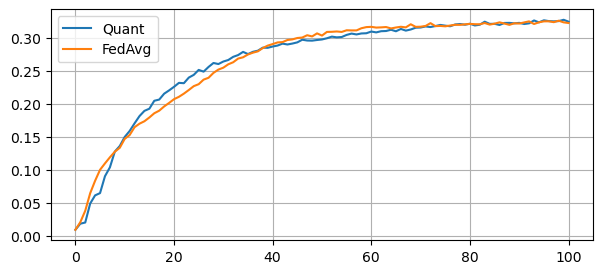

In [18]:
Bits = np.zeros([num_clients, num_global_iterations])
percentage = np.zeros([num_clients, num_global_iterations])
#-----------------------------------------------------
t_start=time.time()
for k in range(num_global_iterations):
    N_total = 0
    
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models = []
    client_models_FedAvg = []

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model = create_model()
        local_model.set_weights(global_weights)#global_model.get_weights())
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        if k<= k_0:
            local_model.set_weights(local_model_FedAvg.get_weights())
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights) 
            local_weight_shape_0 = diff_local_global_weight.shape[0]
            quantized_diff_local_global_weight = diff_local_global_weight
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            Quantized_diff_local_global_weight = []
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(quantized_diff_local_global_weight[h].shape[0],)
                
                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(100*64,)
                
               #### x_previous[h] = np.max(abs(quantized_diff_local_global_weight[h]))
                ####x_position = np.where(np.abs(quantized_diff_local_global_weight[h]) == 
                ####                      max(np.abs(quantized_diff_local_global_weight[h])))
                ####x_temp=quantized_diff_local_global_weight[h] 
                ####x_all_original[h] = x_temp[x_position[0][0]] 
                #print(x[b[0][0]])
            
            #print(x_previous.T)
            ####x_all = np.max(x_previous)
           #### x_position_all = np.where(np.abs(x_previous) == max(np.abs(x_previous)))
            ####x_all_original1 = x_all_original[x_position_all[0][0]]
           #### print('x_all_original1:', x_all_original1)
            
           #### #print(x_previous.T)
            ####x_all = np.max(x_previous)
            #print('x_all:', x_all)
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
           
            
            Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight), '----min:',np.min(Quantized_diff_local_global_weight))
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight, max_model, min_model, err, n_max, n_min, x_min_me = adaptive_signQuant_lambda(Quantized_diff_local_global_weight, 
                                                                                                       Quantized_diff_local_global_weight.shape[0], Lambda[i], b_j)
            
            print('n_max:', n_max, 'n_min:', n_min, 'Lambda_j:', Lambda[i])
            N_total += n_max + n_min
            Bits[i,k] = (468260 - n_max - n_min) + (b_j+1)*(n_max + n_min)
            Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
           
            print('max error:', np.max(np.abs(err)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model:', 1*max_model, 'min_model:', 1*min_model, 'x_min_me:', x_min_me)
            percentage[i,k] = 100*(n_min+n_max)/468260
            print('percentage %:', percentage[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[0:27*32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+6400]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,100)
                    dim_h += 6400
              
                if h==5:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+100]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(100,)
                    dim_h += 100
            
            
            local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models.append(local_model)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights = np.mean([model.get_weights() for model in client_models], axis=0)
        global_model.set_weights(global_weights)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('------------------------------------------------------------------------------------------------------')
    print('N_total:', N_total)
    loss, accuracy = global_model.evaluate(x_test, y_test)
    print(f"Global Test loss: {loss:.4f}, Global Test accuracy: {accuracy:.4f}")
    
    global_acc_list.append(accuracy)
    global_loss_list.append(loss)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)            
            
            

1.0284756331952336
1.116869012348349


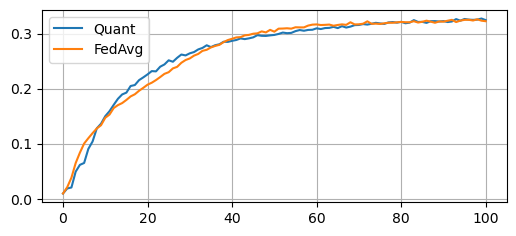

In [19]:
#cifar100 dimension: d=468260, IID

#,lambda = 0.2, K=20, L=5, b = 10,
plt.figure(figsize=(6, 2.5))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 

print(np.mean(percentage))
print(np.mean((32+Bits)/462410)) #29.88, 30.59 %

2.735016604023406
1.2896820732683116


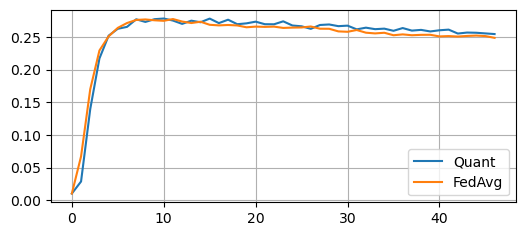

In [24]:
#cifar100 dimension: d=468260

#,lambda = 0.2, K=20, L=5, b = 10,
plt.figure(figsize=(6, 2.5))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 

print(np.mean(percentage[:,0:40]))
print(np.mean((32+Bits[:,0:40])/462410)) #27, 28 %

In [27]:
#Another model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_model():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten the output and add dense layers
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(100, activation='softmax')  # 100 units for CIFAR-100 classes
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the model
model = create_model()
model.summary()


# Define the number of clients and local epochs
num_clients = 20
local_epochs0 = 3 # local_epochs for FedAvg

# Federated Averaging algorithm
num_global_iterations = 2
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)

# Split the data into non-overlapping portions for each client
client_data = []
samples_per_client = len(x_train) // num_clients
for i in range(num_clients):
    start = i * samples_per_client
    end = (i + 1) * samples_per_client
    x_client = x_train[start:end]
    y_client = y_train[start:end]
    client_data.append((x_client, y_client))

# Initialize the global model
global_model = create_model()

# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

global_weights = global_model.get_weights()

#------------- FedAvg benchmark----------------------

global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

# Initialize a list to store the FedAvg_deltaW for each client
fedavg_deltaW_list = []

for k in range(num_global_iterations):
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models_FedAvg = []

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg.compile(optimizer=optimizer,
                                   loss='sparse_categorical_crossentropy',
                                   metrics=['accuracy'])
        local_model_FedAvg.fit(x_local, y_local, epochs=local_epochs0, verbose=0)

        # Calculate the difference between local and global weights
        FedAvg_deltaW = np.array(local_model_FedAvg.get_weights()) - np.array(global_model_FedAvg.get_weights())
        
        # Store the FedAvg_deltaW for visualization
        fedavg_deltaW_list.append(FedAvg_deltaW)

        client_models_FedAvg.append(local_model_FedAvg)

    # Calculate new global weights for FedAvg
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

    # Evaluate the global model after FedAvg
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)

Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_78 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_79 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 6, 6, 64)       

C:\Users\afmb\AppData\Local\Temp\ipykernel_9276\1984025139.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  FedAvg_deltaW = np.array(local_model_FedAvg.get_weights()) - np.array(global_model_FedAvg.get_weights())


Client 2/20
Client 3/20
Client 4/20
Client 5/20
Client 6/20
Client 7/20
Client 8/20
Client 9/20
Client 10/20
Client 11/20
Client 12/20
Client 13/20
Client 14/20
Client 15/20
Client 16/20
Client 17/20
Client 18/20
Client 19/20
Client 20/20
313/313 [==============================] - 4s 13ms/step - loss: 4.7498 - accuracy: 0.0098
_FedAvg Global Test loss: 4.7452, _FedAvg Global Test accuracy: 0.0100
------------------------------------------------------------------------------------------------------
Global Iteration 2/2
Client 1/20
Client 2/20


KeyboardInterrupt: 

14.562381868904218
2.4563073895460743


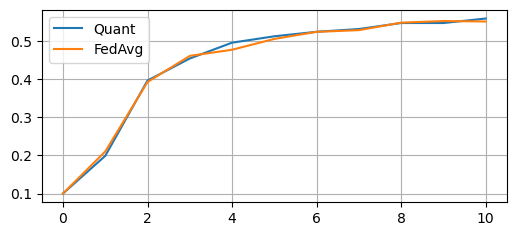

In [27]:
#,lambda0 K=20, L=3, b = 10,
plt.figure(figsize=(6, 2.5))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))

# CIFAR10 non-iid

In [42]:
import numpy as np
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def distribute_data_non_iid(x, y, num_clients, classes_per_client=2):
    """
    Distribute the dataset among clients in a non-iid fashion with equal sample counts.
    
    :param x: Input features.
    :param y: Labels.
    :param num_clients: Number of clients.
    :param classes_per_client: Number of classes each client primarily receives.
    :return: A list of tuples containing data for each client.
    """
    num_classes = len(np.unique(y))
    data_per_class = {i: [] for i in range(num_classes)}

    # Separate data by class
    for i, label in enumerate(y):
        data_per_class[label[0]].append((x[i], y[i]))

    # Shuffle each class's data
    for i in range(num_classes):
        np.random.shuffle(data_per_class[i])

    # Calculate samples per client
    samples_per_client = len(x) // num_clients

    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    # Allocate classes to each client in a non-iid manner
    for client_id in range(num_clients):
        selected_classes = np.random.choice(range(num_classes), classes_per_client, replace=False)
        remaining_samples = samples_per_client

        # Distribute selected class data to each client
        for cls in selected_classes:
            num_samples = min(remaining_samples, len(data_per_class[cls]))
            selected_data = data_per_class[cls][:num_samples]
            data_per_class[cls] = data_per_class[cls][num_samples:]  # Remove assigned data
            
            for (img, lbl) in selected_data:
                client_data[client_id].append(img)
                client_labels[client_id].append(lbl)
            
            remaining_samples -= num_samples

        # Fill remaining samples from other classes
        while remaining_samples > 0:
            for cls in range(num_classes):
                if remaining_samples <= 0:
                    break
                num_samples = min(remaining_samples, len(data_per_class[cls]))
                selected_data = data_per_class[cls][:num_samples]
                data_per_class[cls] = data_per_class[cls][num_samples:]  # Remove assigned data
                
                for (img, lbl) in selected_data:
                    client_data[client_id].append(img)
                    client_labels[client_id].append(lbl)
                
                remaining_samples -= num_samples

    # Convert lists to numpy arrays
    client_datasets = [
        (np.array(client_data[i]), np.array(client_labels[i]))
        for i in range(num_clients)
    ]

    return client_datasets

# Parameters
num_clients = K
classes_per_client = 3

# Distribute the dataset
client_data = distribute_data_non_iid(x_train, y_train, num_clients, classes_per_client)

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()



Client 0: 2500 samples
Label distribution: {6: 2500}

Client 1: 2500 samples
Label distribution: {3: 2500}

Client 2: 2500 samples
Label distribution: {5: 2500}

Client 3: 2500 samples
Label distribution: {1: 2500}

Client 4: 2500 samples
Label distribution: {6: 2500}

Client 5: 2500 samples
Label distribution: {0: 2500}

Client 6: 2500 samples
Label distribution: {5: 2500}

Client 7: 2500 samples
Label distribution: {7: 2500}

Client 8: 2500 samples
Label distribution: {1: 2500}

Client 9: 2500 samples
Label distribution: {7: 2500}

Client 10: 2500 samples
Label distribution: {9: 2500}

Client 11: 2500 samples
Label distribution: {4: 2500}

Client 12: 2500 samples
Label distribution: {2: 2500}

Client 13: 2500 samples
Label distribution: {4: 2500}

Client 14: 2500 samples
Label distribution: {9: 2500}

Client 15: 2500 samples
Label distribution: {0: 2500}

Client 16: 2500 samples
Label distribution: {8: 2500}

Client 17: 2500 samples
Label distribution: {2: 2500}

Client 18: 2500 samp

In [51]:
import numpy as np

# Assume x_train and y_train are numpy arrays, and num_clients is an integer
np.random.seed(42)  # For reproducibility

# Shuffle the data
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class
class_indices = {}
for label in np.unique(y_train):
    class_indices[label] = np.where(y_train == label)[0]

# Split data for each client with varying class proportions
client_data = []
num_classes = len(class_indices)
samples_per_client = len(x_train) // num_clients

for i in range(num_clients):
    x_client = []
    y_client = []

    # Determine class proportions for this client
    # For simplicity, let's give each client a random distribution skewed towards certain classes
    proportions = np.random.dirichlet(alpha=[0.6] * num_classes)

    for label in range(num_classes):
        num_samples = int(proportions[label] * samples_per_client)

        # Ensure we don't sample more than available
        class_samples = class_indices[label][:num_samples]
        x_client.extend(x_train[class_samples])
        y_client.extend(y_train[class_samples])

        # Remove used samples
        class_indices[label] = class_indices[label][num_samples:]

    # Shuffle client's data
    x_client = np.array(x_client)
    y_client = np.array(y_client)
    indices = np.arange(len(x_client))
    np.random.shuffle(indices)
    x_client = x_client[indices]
    y_client = y_client[indices]

    client_data.append((x_client, y_client))

# client_data now contains non-IID datasets for each client


In [52]:

# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs
num_clients= K
#local_epochs = 1
local_epochs0 = 1 #local_epochs FedAvg
local_epochs = 1
epoch_increase = 0
b_j = 10



# Federated Averaging algorithm
num_global_iterations = 2
k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


# Split the data into non-overlapping portions for each client
#client_data = []
#samples_per_client = len(x_train) // num_clients
#for i in range(num_clients):
 #   start = i * samples_per_client
 #   end = (i + 1) * samples_per_client
 #   x_client = x_train[start:end]
 #   y_client = y_train[start:end]
 #   client_data.append((x_client, y_client))

    
    
##Lambda0 = np.random.rand(num_clients)
#Lambda0 = np.abs(np.random.randn(num_clients))
#LAmbda = np.zeros(num_clients)

#for i in range(num_clients):
#    LAmbda[i] = (1 - Lambda0[i]/np.max(Lambda0) + 0.001)
#Lambda = LAmbda/np.sum(LAmbda)
#print('Lambda:', Lambda)
#print('sum lambda:', np.sum(Lambda))
# Initialize the global model
global_model = create_model()

global_model.summary()

# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()


#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

Model: "sequential_989"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1040 (Conv2D)         (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1040 (MaxPooli (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_989 (Flatten)        (None, 7200)              0         
_________________________________________________________________
dense_1978 (Dense)           (None, 64)                460864    
_________________________________________________________________
dense_1979 (Dense)           (None, 10)                650       
Total params: 462,410
Trainable params: 462,410
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 3s 8ms/step - loss: 2.3375 - accuracy: 0.0926
Initial Test Loss: 2.33

Global Iteration 1/2
Client 1/20


C:\Users\afmb\AppData\Local\Temp\ipykernel_9276\922768376.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights)


max: 0.5650139451026917 ----min: -0.5896384716033936
n_max: 709 n_min: 1629 Lambda_j: [0.05057192]
max error: 0.014985923543809126
max_model: 0.029971848018940827 min_model: -0.029971848018940827 x_min_me: 0.029971848018940827
percentage %: 0.5056119028567722
Client 2/20


C:\Users\afmb\AppData\Local\Temp\ipykernel_9276\922768376.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))


max: 0.4934024512767792 ----min: -0.5282304286956787
n_max: 377 n_min: 1495 Lambda_j: [0.05012402]
max error: 0.013308784681375077
max_model: 0.026334068292746444 min_model: -0.026334068292746444 x_min_me: 0.026334068292746444
percentage %: 0.40483553556367724
Client 3/20
max: 0.6040140390396118 ----min: -0.5620971918106079
n_max: 478 n_min: 2197 Lambda_j: [0.05166688]
max error: 0.015646502011904415
max_model: 0.031293004955131404 min_model: -0.031293004955131404 x_min_me: 0.031293004955131404
percentage %: 0.5784909495901905
Client 4/20
max: 0.5973568558692932 ----min: -0.585336446762085
n_max: 1713 n_min: 3099 Lambda_j: [0.04744156]
max error: 0.014306200127675401
max_model: 0.02861240072101209 min_model: -0.02861240072101209 x_min_me: 0.02861240072101209
percentage %: 1.0406349343656063
Client 5/20
max: 0.622738778591156 ----min: -0.5739021301269531
n_max: 436 n_min: 914 Lambda_j: [0.05207428]
max error: 0.01629699580189303
max_model: 0.03226310387617915 min_model: -0.0322631038761

max: 0.4197668433189392 ----min: -0.42776960134506226
n_max: 1394 n_min: 595 Lambda_j: [0.04783724]
max error: 0.010244726173680744
max_model: 0.02048945304585342 min_model: -0.02048945304585342 x_min_me: 0.02048945304585342
percentage %: 0.43013775653640707
Client 11/20
max: 0.39194387197494507 ----min: -0.47499290108680725
n_max: 908 n_min: 391 Lambda_j: [0.04815455]
max error: 0.01149468021585678
max_model: 0.022751370628791352 min_model: -0.022751370628791352 x_min_me: 0.022751370628791352
percentage %: 0.28091953028697475
Client 12/20
max: 0.3632102310657501 ----min: -0.4882107377052307
n_max: 592 n_min: 1462 Lambda_j: [0.04853591]
max error: 0.01193085822703741
max_model: 0.023861717385397396 min_model: -0.023861717385397396 x_min_me: 0.023861717385397396
percentage %: 0.44419454596570146
Client 13/20
max: 0.41694849729537964 ----min: -0.41373756527900696
n_max: 263 n_min: 311 Lambda_j: [0.04798624]
max error: 0.009997151584481914
max_model: 0.01997114014415797 min_model: -0.0199

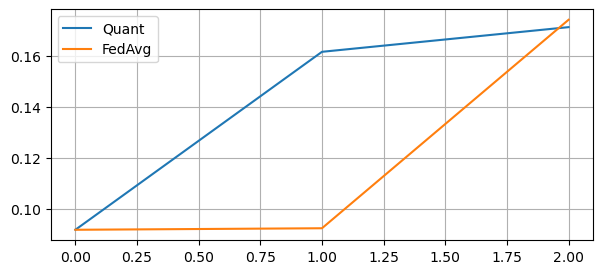

In [53]:
#----------------------------------------------------------------------------------------------

Bits = np.zeros([num_clients, num_global_iterations])
percentage = np.zeros([num_clients, num_global_iterations])
#-----------------------------------------------------
t_start=time.time()
for k in range(num_global_iterations):
    N_total = 0
    
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models = []
    client_models_FedAvg = []

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model = create_model()
        local_model.set_weights(global_weights)#global_model.get_weights())
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        if k<= k_0:
            local_model.set_weights(local_model_FedAvg.get_weights())
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight = np.array(local_model.get_weights())-np.array(global_weights) 
            local_weight_shape_0 = diff_local_global_weight.shape[0]
            quantized_diff_local_global_weight = diff_local_global_weight
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            Quantized_diff_local_global_weight = []
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(quantized_diff_local_global_weight[h].shape[0],)
                
                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10*64,)
                
               #### x_previous[h] = np.max(abs(quantized_diff_local_global_weight[h]))
                ####x_position = np.where(np.abs(quantized_diff_local_global_weight[h]) == 
                ####                      max(np.abs(quantized_diff_local_global_weight[h])))
                ####x_temp=quantized_diff_local_global_weight[h] 
                ####x_all_original[h] = x_temp[x_position[0][0]] 
                #print(x[b[0][0]])
            
            #print(x_previous.T)
            ####x_all = np.max(x_previous)
           #### x_position_all = np.where(np.abs(x_previous) == max(np.abs(x_previous)))
            ####x_all_original1 = x_all_original[x_position_all[0][0]]
           #### print('x_all_original1:', x_all_original1)
            
           #### #print(x_previous.T)
            ####x_all = np.max(x_previous)
            #print('x_all:', x_all)
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
           
            
            Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight), '----min:',np.min(Quantized_diff_local_global_weight))
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight, max_model, min_model, err, n_max, n_min, x_min_me = adaptive_signQuant_lambda(Quantized_diff_local_global_weight, 
                                                                                                       Quantized_diff_local_global_weight.shape[0], Lambda[i], b_j)
            
            print('n_max:', n_max, 'n_min:', n_min, 'Lambda_j:', Lambda[i])
            N_total += n_max + n_min
            Bits[i,k] = (462410 - n_max - n_min) + (b_j+1)*(n_max + n_min)
            Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
           
            print('max error:', np.max(np.abs(err)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model:', 1*max_model, 'min_model:', 1*min_model, 'x_min_me:', x_min_me)
            percentage[i,k] = 100*(n_min+n_max)/462410
            print('percentage %:', percentage[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[0:27*32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+640]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+10]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10,)
                    dim_h += 10
            
            
            local_model.set_weights(quantized_diff_local_global_weight + np.array(global_weights))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models.append(local_model)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights = np.mean([model.get_weights() for model in client_models], axis=0)
        global_model.set_weights(global_weights)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('------------------------------------------------------------------------------------------------------')
    print('N_total:', N_total)
    loss, accuracy = global_model.evaluate(x_test, y_test)
    print(f"Global Test loss: {loss:.4f}, Global Test accuracy: {accuracy:.4f}")
    
    global_acc_list.append(accuracy)
    global_loss_list.append(loss)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)            
            
            

In [56]:
#Show the non-iid data:
import numpy as np

# Assume x_train and y_train are numpy arrays, and num_clients is an integer
np.random.seed(42)  # For reproducibility

# Shuffle the data
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class
class_indices = {}
for label in np.unique(y_train):
    class_indices[label] = np.where(y_train == label)[0]

# Split data for each client with varying class proportions
client_data = []
num_classes = len(class_indices)
samples_per_client = len(x_train) // num_clients

for i in range(num_clients):
    x_client = []
    y_client = []

    # Determine class proportions for this client
    # For simplicity, let's give each client a random distribution skewed towards certain classes
    proportions = np.random.dirichlet(alpha=[0.6] * num_classes)

    for label in range(num_classes):
        num_samples = int(proportions[label] * samples_per_client)

        # Ensure we don't sample more than available
        class_samples = class_indices[label][:num_samples]
        x_client.extend(x_train[class_samples])
        y_client.extend(y_train[class_samples])

        # Remove used samples
        class_indices[label] = class_indices[label][num_samples:]

    # Shuffle client's data
    x_client = np.array(x_client)
    y_client = np.array(y_client)
    indices = np.arange(len(x_client))
    np.random.shuffle(indices)
    x_client = x_client[indices]
    y_client = y_client[indices]

    client_data.append((x_client, y_client))

# client_data now contains non-IID datasets for each client

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()



Client 0: 2496 samples
Label distribution: {0: 68, 1: 607, 2: 1, 3: 479, 4: 154, 5: 35, 6: 299, 7: 5, 8: 385, 9: 463}

Client 1: 2496 samples
Label distribution: {0: 94, 1: 129, 2: 351, 3: 150, 4: 279, 5: 344, 6: 43, 7: 140, 8: 300, 9: 666}

Client 2: 2496 samples
Label distribution: {0: 275, 1: 66, 2: 12, 3: 4, 4: 185, 5: 14, 6: 66, 7: 492, 8: 431, 9: 951}

Client 3: 2495 samples
Label distribution: {0: 4, 1: 143, 2: 9, 3: 210, 4: 44, 5: 789, 6: 899, 7: 232, 8: 151, 9: 14}

Client 4: 2495 samples
Label distribution: {0: 8, 1: 59, 2: 373, 3: 206, 6: 198, 7: 651, 8: 324, 9: 676}

Client 5: 2494 samples
Label distribution: {0: 104, 1: 99, 2: 27, 3: 534, 4: 43, 5: 26, 6: 898, 7: 317, 8: 446}

Client 6: 2495 samples
Label distribution: {0: 637, 1: 331, 2: 304, 3: 27, 5: 186, 6: 125, 7: 454, 8: 216, 9: 215}

Client 7: 2495 samples
Label distribution: {0: 249, 1: 205, 2: 22, 3: 690, 4: 120, 5: 15, 6: 567, 7: 527, 8: 81, 9: 19}

Client 8: 2494 samples
Label distribution: {0: 87, 1: 412, 2: 11

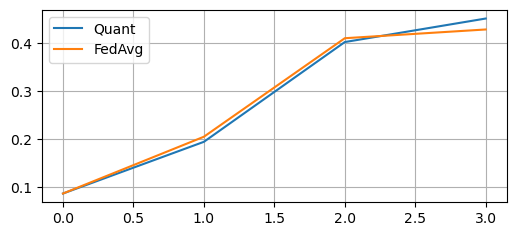

In [16]:
#, K=20, L=3, b = 10,
plt.figure(figsize=(6, 2.5))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))

16.769436214614736
1.3354579269479467


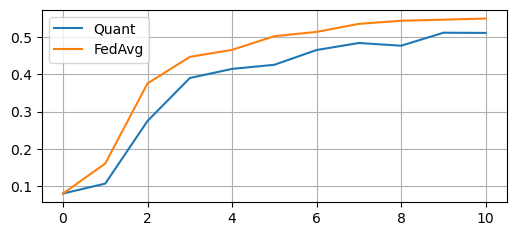

In [10]:
#, K=20, L=3, b = 2,
plt.figure(figsize=(6, 2.5))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))

27.668386280573515
2.1068046538785925


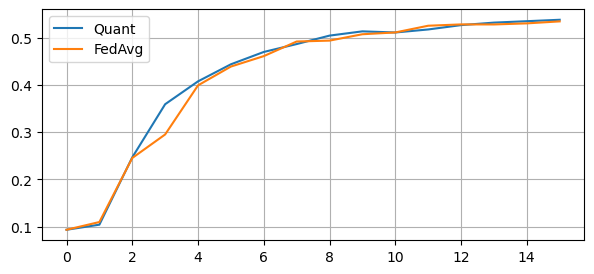

In [17]:
#, K=40, L=5, b = 4,
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major') 
print(np.mean(percentage))
print(np.mean((32+Bits)/462410))

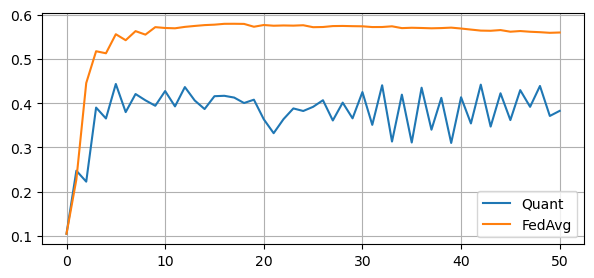

In [20]:
#with  lambda0, K=20, L=5, b = 4, omega = 1
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')  

In [18]:
#acc_q0 = np.array(global_acc_list)
#acc_fed0 = np.array(global_acc_list_FedAvg)
np.mean(percentage)

5.459360524210117

In [19]:
np.mean((32+Bits)/462410)

1.2184436236240568

In [ ]:
acc_q = np.array(global_acc_list)
acc_fed = np.array(global_acc_list_FedAvg)

# Base directory where you want to save the results
base_dir = 'C:/FedASi files'

# Prompt the user to input the folder name
#run_folder_name = input("Enter the folder name for this run: ")
run_folder_name = 'New_K20_L5_b4_T50'
run_folder_path = os.path.join(base_dir, run_folder_name)

# Create the directory if it doesn't exist
os.makedirs(run_folder_path, exist_ok=True)

# List of matrices to save and their respective filenames
matrices = {
    'A_bar': A_bar,
    'B_bar': B_bar,
    'Bits' : Bits,
    'percentage': percentage,
    'I_M': I_M,
    'B_tilde': B_tilde,
    'Lambda': Lambda,
    'acc_q' : acc_q,
    'acc_fed': acc_fed
    
    # Add more matrices here as needed
}

# Save each matrix to a .npy file in the specified folder
for name, matrix in matrices.items():
    file_name = os.path.join(run_folder_path, f'{name}.npy')
    np.save(file_name, matrix)
    print(f'{name} saved to {file_name}')


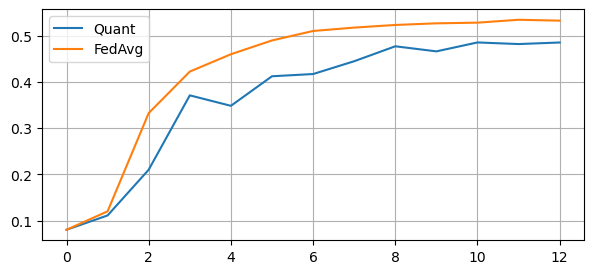

In [33]:
#with  lambda0, K=40, L=3, b = 10, omega = 0.8
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')  

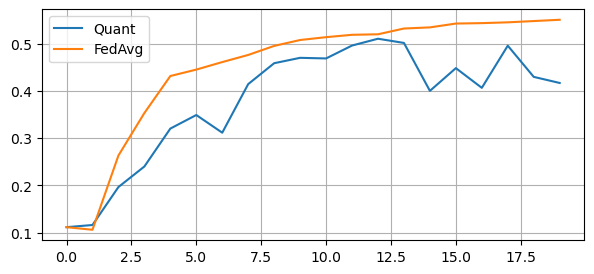

In [22]:
#with  lambda0, K=40, L=3, b = 2
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    

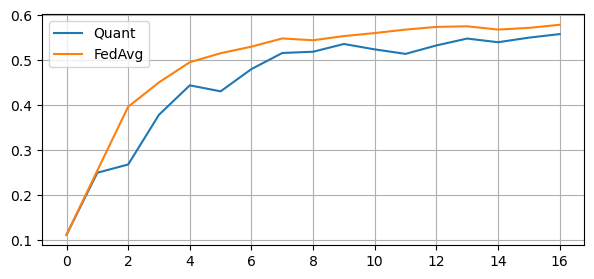

In [22]:
#with  lambda0, K=20, L=3, b = 2
plt.figure(figsize=(7, 3))
plt.plot(acc_q0)    
plt.plot(acc_fed0)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
#print('simulation time:', t_stop- t_start

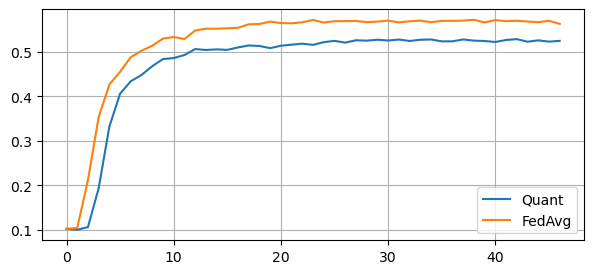

In [17]:
#with older lambda
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
#print('simulation time:', t_stop- t_start)     

1.532044538396661
26.602226919833047


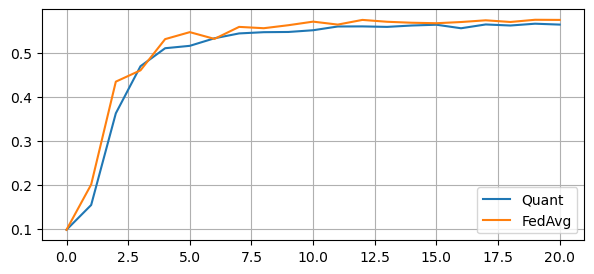

In [8]:
#K=20, L=5, b_j = 2 simulation time= 6 min/iteration
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
print(np.mean(Bits)/462410)
perc_bar=np.mean(percentage)
print(perc_bar)
            

1.5093228592230559
25.4661429611528


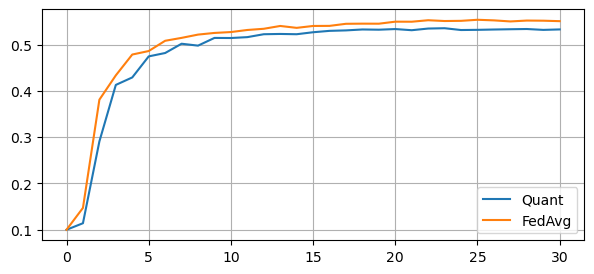

In [12]:
#K=40, L=5, b_j = 2 simulation time= 8 min/iteration
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
print(np.mean(Bits)/462410)
perc_bar=np.mean(percentage)
print(perc_bar)
            

# --- Numericals:---

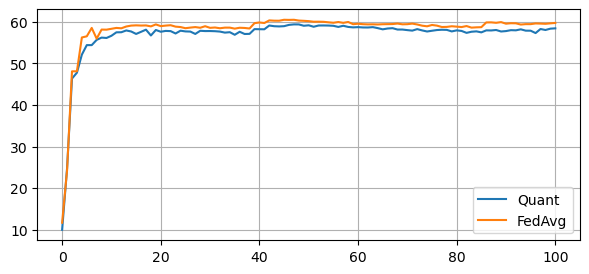

In [191]:
#K = 20, L=5, b_j=5
Global_acc_q = 100*new_global_q
Global_acc_Fed = 100*new_global
plt.figure(figsize=(7, 3))
plt.plot(Global_acc_q)    
plt.plot(Global_acc_Fed)

plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')  


In [185]:
file_name = 'C:\FedASi files/Bits20_L5_b5.npy'
np.save(file_name, Bits)


Enter the folder name for this run: test
A_bar saved to C:/FedASi files\test\A_bar.npy
B_bar saved to C:/FedASi files\test\B_bar.npy
Bits saved to C:/FedASi files\test\Bits.npy
percentage saved to C:/FedASi files\test\percentage.npy
I_M saved to C:/FedASi files\test\I_M.npy
B_tilde saved to C:/FedASi files\test\B_tilde.npy
Lambda saved to C:/FedASi files\test\Lambda.npy


1.4608937090460845
7.681561817434744


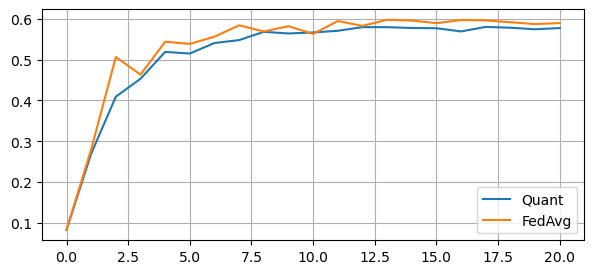

In [63]:
#K=5, b_j = 6
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
print(np.mean(Bits)/462410)
perc_bar=np.mean(percentage)
print(perc_bar)
            

In [59]:
np.sum(percentage)/(num_clients* num_global_iterations), np.mean(percentage)
bits_bar = np.mean(Bits)/462410

b_sparse=(32+b_j)*perc_bar*462410
print(b_sparse)

134977178.0


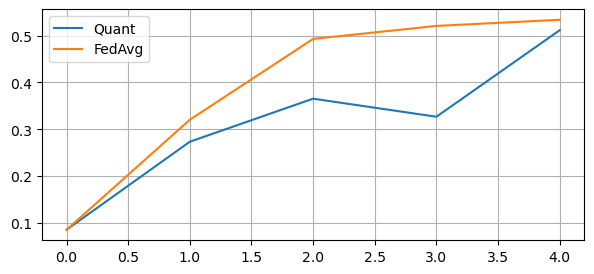

In [24]:
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
            

# Lambda Evaluations

In [4]:
# Compute each Lambda_j here: 
Y3 = np.copy(I_M)
for i in range(K):
    Y3[i]=np.sum(B_tilde[:,i])

X31 = np.log2(1+(A_bar/(B_bar + Y3 + I_M)))
#Lambda_0 = 1 - X31/np.sum(X31) #+ 0.00001
Lambda_0 = 1 - X31/np.max(X31) + 0.00001


Lambda_old =  Lambda_0/np.sum(Lambda_0)

def logarithmic_transformation(X, K):
    return np.log1p(X * (K - 1)) / np.log(K)
Lambda_new = logarithmic_transformation(Lambda_old, K)
#print('------------------------------')
#print(Lambda_new.T)
Lambda1 = Lambda_old
#/np.max(Lambda_0) )

omegaa_q = 1
#Lambda =omegaa_q*Lambda_0

print(Lambda1.T)
#Lambda = Lambda_0/np.max(Lambda_0)- 0.00001
lambda_coef = np.mean(Lambda1)
Lambda31 = 1*lambda_coef *np.ones(K)
print('-------------------------------------------')
print(Lambda31.T)

[[1.15258809e-02 6.55538421e-03 1.36049776e-02 9.41114857e-03
  2.72499427e-02 4.14029486e-02 4.11656039e-02 7.18248910e-03
  4.25552251e-02 1.01722670e-02 4.02450031e-02 2.07435266e-02
  3.99525204e-02 7.65664863e-03 2.00957596e-03 4.51830605e-02
  2.74232754e-02 3.39164227e-02 1.44429788e-02 4.47932195e-02
  3.53623948e-02 3.86461343e-02 3.80142994e-02 4.70422957e-07
  4.38186940e-02 3.55368254e-02 4.13692722e-03 2.24981350e-02
  2.90861541e-02 2.17302233e-02 2.43825988e-02 3.00353051e-02
  1.94081708e-03 3.78095472e-02 3.90291041e-02 3.53083930e-03
  3.32189459e-02 4.23509421e-02 5.70804400e-03 2.59714993e-02]]
-------------------------------------------
[0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]


In [29]:
test = np.mean(X31)/X31
Lambda_test=(test/np.sum(test))
print(Lambda1.T - Lambda_test.T)
np.mean(Lambda_test)


[[-0.00667694 -0.01864352  0.01310347  0.00611776 -0.00831018 -0.02449075
   0.01160832  0.01263756 -0.01894158 -0.00962445  0.01290841  0.01341416
  -0.00658107  0.00800986  0.0113556  -0.03069049  0.01051996  0.01310954
   0.01286972 -0.0016954 ]]


0.05

In [6]:
X31.T

array([[0.13360594, 1.09994367, 0.0384624 , 1.94508113, 2.14454999,
        0.13661429, 0.03516241, 2.30843414, 0.25022792, 1.86178616,
        0.50020324, 1.28102694, 0.43042166, 0.13889011, 1.40169204,
        2.1529775 , 0.50618796, 0.51667998, 0.35461636, 0.56330257,
        0.03974846, 0.19286362, 0.15966928, 0.03520493, 0.14087371,
        0.06602962, 0.08038558, 0.03264893, 0.01738198, 2.02454701,
        2.30336514, 0.21688446, 0.04895438, 0.1430149 , 0.0312438 ,
        0.69657087, 2.27383813, 0.02192689, 0.63211391, 0.03910709]])

In [5]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data

# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs
num_clients= K
#local_epochs = 1
local_epochs0 = 3 #local_epochs FedAvg
local_epochs = 3
epoch_increase = 0
b_j= 4

# Federated Averaging algorithm
num_global_iterations = 30
k_0 = -100 #num_global_iterations +1

#learning_rate = 1e-3
#optimizer = SGD(learning_rate=learning_rate)
optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


# Split the data into non-overlapping portions for each client
client_data = []
samples_per_client = len(x_train) // num_clients
for i in range(num_clients):
    start = i * samples_per_client
    end = (i + 1) * samples_per_client
    x_client = x_train[start:end]
    y_client = y_train[start:end]
    client_data.append((x_client, y_client))

    
    

# Initialize the global model
global_model = create_model()
global_model1 = create_model()
global_model31 = create_model()

# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


global_model1.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

global_model31.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights1 = global_model.get_weights()
global_weights31 = global_model.get_weights()
B_q = np.zeros([8,num_global_iterations])

#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights1)
global_acc_list1 = []
global_loss_list1 = []

global_acc_list31 = []
global_loss_list31 = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list1.append(initial_accuracy)
global_acc_list31.append(initial_accuracy)

t_stop = time.time()



313/313 [==============================] - 2s 4ms/step - loss: 2.3478 - accuracy: 0.1064
Initial Test Loss: 2.3445
Initial Test Accuracy: 0.1097


Global Iteration 1/30
Client 1/40


C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1089036863.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight1 = np.array(local_model1.get_weights())-np.array(global_weights1)
C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1089036863.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight31 = np.array(local_model31.get_weights())-np.array(global_weights31)


%----- Lambda1-------------------------------------
max: 0.16110503673553467 ----min: -0.12888402938842772
max error1: 0.005369480450948079
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 31164 n_min1: 73815 Lambda_j1: [0.01152588]
percentage1 %: 22.70257996150602
%----- Lambda31-------------------------------------
max: 0.34505605697631836 ----min: -0.2300373713175456
max error31: 0.01150180461506049
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 5951 n_min31: 12736 Lambda_j31: 0.024999999999999998
percentage31 %: 4.041218831772669
Client 2/40


C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1089036863.py:203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  local_model1.set_weights(quantized_diff_local_global_weight1 + np.array(global_weights1))
C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1089036863.py:204: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  local_model31.set_weights(quantized_diff_local_global_weight31 + np.array(global_weights31))


%----- Lambda1-------------------------------------
max: 0.23944421112537384 ----min: -0.14366652667522428
max error1: 0.007981002082427344
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 33097 n_min1: 79113 Lambda_j1: [0.00655538]
percentage1 %: 24.26634372094029
%----- Lambda31-------------------------------------
max: 0.29042479395866394 ----min: -0.19361652930577597
max error31: 0.009680398305257163
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 5481 n_min31: 11820 Lambda_j31: 0.024999999999999998
percentage31 %: 3.7414848294803313
Client 3/40
%----- Lambda1-------------------------------------
max: 0.2037922888994217 ----min: -0.19020613630612693
max error1: 0.006792984219888847
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 29955 n_min1: 61191 Lambda_j1: [0.01360498]
percentage1 %: 19.711078912653274
%----- Lambda31-------------------------------------
max: 0.23227481544017792 ----min: -0.2013048400481542
max error31: 0.007742464480300745
max_mode

%----- Lambda1-------------------------------------
max: 0.2117537558078766 ----min: -0.1411691705385844
max error1: 0.007058458061267933
max_model1: 0.01411691705385844 min_model: -0.01411691705385844 x_min_me1: 0.01411691705385844
n_max1: 2433 n_min1: 10677 Lambda_j1: [0.04518306]
percentage1 %: 2.835146298739214
%----- Lambda31-------------------------------------
max: 0.31028011441230774 ----min: -0.1241120457649231
max error31: 0.010342535314460596
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 5830 n_min31: 12411 Lambda_j31: 0.024999999999999998
percentage31 %: 3.944767630457819
Client 17/40
%----- Lambda1-------------------------------------
max: 0.2957117259502411 ----min: -0.13799880544344584
max error1: 0.009856959680716197
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 5927 n_min1: 7124 Lambda_j1: [0.02742328]
percentage1 %: 2.8223870591033933
%----- Lambda31-------------------------------------
max: 0.40666326880455017 ----min: -0.13555442293485007
m

max: 0.15079911053180695 ----min: -0.15079911053180695
max error31: 0.005026371963322163
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 17891 n_min31: 43930 Lambda_j31: 0.024999999999999998
percentage31 %: 13.3693042970524
Client 30/40
%----- Lambda1-------------------------------------
max: 0.24242125451564786 ----min: -0.14545275270938873
max error1: 0.00808062528570493
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 5518 n_min1: 20046 Lambda_j1: [0.02173022]
percentage1 %: 5.528427153392012
%----- Lambda31-------------------------------------
max: 0.35662907361984253 ----min: -0.285303258895874
max error31: 0.01188595543305079
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 4780 n_min31: 7943 Lambda_j31: 0.024999999999999998
percentage31 %: 2.7514543370601845
Client 31/40
%----- Lambda1-------------------------------------
max: 0.1284913976987203 ----min: -0.13766935467720032
max error1: 0.00458869921664397
max_model1: 0.0 min_model: 0.0 x_min_me1

C:\Users\afmb\Anaconda3\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


----------------------------For Lambda1-----------------------------------------------------
313/313 [==============================] - 2s 4ms/step - loss: 2.2996 - accuracy: 0.1132
Global Test loss1: 2.2999, Global Test accuracy1: 0.1110
----------------------------For Lambda31-----------------------------------------------------
313/313 [==============================] - 1s 4ms/step - loss: 2.3000 - accuracy: 0.1066
Global Test loss31: 2.3003, Global Test accuracy31: 0.1041
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 4ms/step - loss: 2.3009 - accuracy: 0.1167
_FedAvg Global Test loss: 2.3011, _FedAvg Global Test accuracy: 0.1135
------------------------------------------------------------------------------------------------------
Global Iteration 2/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.4540765583515167 ----min: -0.1816306233406067
max error1: 0.0

max: 0.3510725498199463 ----min: -0.14042901992797852
max error31: 0.011702300980687141
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 15730 n_min31: 29558 Lambda_j31: 0.024999999999999998
percentage31 %: 9.793905841136654
Client 14/40
%----- Lambda1-------------------------------------
max: 0.47692498564720154 ----min: -0.15897499521573383
max error1: 0.015896734098593393
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 18278 n_min1: 26278 Lambda_j1: [0.00765665]
percentage1 %: 9.635604766332907
%----- Lambda31-------------------------------------
max: 0.3669527471065521 ----min: -0.17124461531639099
max error31: 0.012231700867414475
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 9508 n_min31: 12919 Lambda_j31: 0.024999999999999998
percentage31 %: 4.850024869704375
Client 15/40
%----- Lambda1-------------------------------------
max: 0.4590638279914856 ----min: -0.18362553119659425
max error1: 0.015301937051117421
max_model1: 0.0 min_model: 0.0 x_mi

max: 0.3783147931098938 ----min: -0.20176788965861003
max error31: 0.012610094373424849
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 7927 n_min31: 11931 Lambda_j31: 0.024999999999999998
percentage31 %: 4.2944572997988795
Client 28/40
%----- Lambda1-------------------------------------
max: 0.43393415212631226 ----min: -0.2025026043256124
max error1: 0.01446415719886621
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 9751 n_min1: 12176 Lambda_j1: [0.02249814]
percentage1 %: 4.741895720248264
%----- Lambda31-------------------------------------
max: 0.47648507356643677 ----min: -0.1588283578554789
max error31: 0.015881786247094472
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 5970 n_min31: 14167 Lambda_j31: 0.024999999999999998
percentage31 %: 4.354793365195389
Client 29/40
%----- Lambda1-------------------------------------
max: 0.4515034258365631 ----min: -0.18060137033462526
max error1: 0.015049899121125539
max_model1: 0.0 min_model: 0.0 x_min_m

%----- Lambda1-------------------------------------
max: 0.2851397395133972 ----min: -0.2281117916107178
max error1: 0.009504517167806627
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 54465 n_min1: 56672 Lambda_j1: [0.00765665]
percentage1 %: 24.03429856620748
%----- Lambda31-------------------------------------
max: 0.2276226282119751 ----min: -0.21244778633117675
max error31: 0.007587414607405663
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 20680 n_min31: 24581 Lambda_j31: 0.024999999999999998
percentage31 %: 9.788066867066023
Client 15/40
%----- Lambda1-------------------------------------
max: 0.31176310777664185 ----min: -0.20784207185109457
max error1: 0.010391724792619548
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 78095 n_min1: 92030 Lambda_j1: [0.00200958]
percentage1 %: 36.79094310244156
%----- Lambda31-------------------------------------
max: 0.23570749163627622 ----min: -0.17285216053326924
max error31: 0.007856515174110727
max_model

max: 0.23811668157577515 ----min: -0.23811668157577515
max error31: 0.00793713703751564
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 17158 n_min31: 19820 Lambda_j31: 0.024999999999999998
percentage31 %: 7.9967993771760995
Client 28/40
%----- Lambda1-------------------------------------
max: 0.22442805767059326 ----min: -0.20946618715922039
max error1: 0.007480932523806889
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 27058 n_min1: 34644 Lambda_j1: [0.02249814]
percentage1 %: 13.343569559481844
%----- Lambda31-------------------------------------
max: 0.2616018056869507 ----min: -0.1918413241704305
max error31: 0.008719921112060547
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 18375 n_min31: 23479 Lambda_j31: 0.024999999999999998
percentage31 %: 9.051274842672088
Client 29/40
%----- Lambda1-------------------------------------
max: 0.25401201844215393 ----min: -0.22014374931653344
max error1: 0.008466730390985808
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 5ms/step - loss: 1.9225 - accuracy: 0.3071
Global Test loss31: 1.9225, Global Test accuracy31: 0.3071
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 5ms/step - loss: 1.8745 - accuracy: 0.3496
_FedAvg Global Test loss: 1.8745, _FedAvg Global Test accuracy: 0.3496
------------------------------------------------------------------------------------------------------
Global Iteration 4/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.2237754464149475 ----min: -0.17902035713195802
max error1: 0.007459095120429993
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 55847 n_min1: 67381 Lambda_j1: [0.01152588]
percentage1 %: 26.64907765835514
%----- Lambda31-------------------------------------
max: 0.28369536995887756 ----min: -0.2080432713031769
max error31: 0.00945628583431244
max_model31: 0.0 min_model31: 0.0 x_min_

%----- Lambda1-------------------------------------
max: 0.39473414421081543 ----min: -0.15789365768432617
max error1: 0.013157794872919716
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 53978 n_min1: 58123 Lambda_j1: [0.00765665]
percentage1 %: 24.242771566358858
%----- Lambda31-------------------------------------
max: 0.2660819888114929 ----min: -0.19512679179509482
max error31: 0.008869386898974579
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 26470 n_min31: 29489 Lambda_j31: 0.024999999999999998
percentage31 %: 12.10159814882896
Client 15/40
%----- Lambda1-------------------------------------
max: 0.2544504404067993 ----min: -0.22052371501922607
max error1: 0.008481651544570923
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 85487 n_min1: 86150 Lambda_j1: [0.00200958]
percentage1 %: 37.117925650396835
%----- Lambda31-------------------------------------
max: 0.2657119631767273 ----min: -0.2125695705413818
max error31: 0.008856873214244842
max_mod

max: 0.34964054822921753 ----min: -0.20978432893753052
max error31: 0.011653977756698925
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 19518 n_min31: 21706 Lambda_j31: 0.024999999999999998
percentage31 %: 8.915032114357388
Client 28/40
%----- Lambda1-------------------------------------
max: 0.23143412172794342 ----min: -0.1542894144852956
max error1: 0.00771445060769717
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 39783 n_min1: 36725 Lambda_j1: [0.02249814]
percentage1 %: 16.545489933176185
%----- Lambda31-------------------------------------
max: 0.21302521228790283 ----min: -0.1988235314687093
max error31: 0.007100798189640045
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 30108 n_min31: 32555 Lambda_j31: 0.024999999999999998
percentage31 %: 13.55139378473649
Client 29/40
%----- Lambda1-------------------------------------
max: 0.21986114978790283 ----min: -0.19054632981618244
max error1: 0.007328696673115094
max_model1: 0.0 min_model: 0.0 x_

313/313 [==============================] - 2s 5ms/step - loss: 1.6820 - accuracy: 0.4070
Global Test loss31: 1.6820, Global Test accuracy31: 0.4070
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 5ms/step - loss: 1.6989 - accuracy: 0.3861
_FedAvg Global Test loss: 1.6989, _FedAvg Global Test accuracy: 0.3861
------------------------------------------------------------------------------------------------------
Global Iteration 5/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.20526023308436075 ----min: -0.21992167830467224
max error1: 0.007330704356233279
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 61599 n_min1: 69802 Lambda_j1: [0.01152588]
percentage1 %: 28.41655673536472
%----- Lambda31-------------------------------------
max: 0.19214105606079102 ----min: -0.17933165232340495
max error31: 0.006404657910267512
max_model31: 0.0 min_model31: 0.0 x_m

%----- Lambda1-------------------------------------
max: 0.20745785534381866 ----min: -0.17979680796464284
max error1: 0.006915245453516643
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 72674 n_min1: 73985 Lambda_j1: [0.00765665]
percentage1 %: 31.716225860167384
%----- Lambda31-------------------------------------
max: 0.17332851886749268 ----min: -0.1502180496851603
max error31: 0.005777407127122084
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 39065 n_min31: 43371 Lambda_j31: 0.024999999999999998
percentage31 %: 17.82746912912783
Client 15/40
%----- Lambda1-------------------------------------
max: 0.20690396428108215 ----min: -0.16552317142486572
max error1: 0.006896787633498509
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 90117 n_min1: 96655 Lambda_j1: [0.00200958]
percentage1 %: 40.39099500443329
%----- Lambda31-------------------------------------
max: 0.2862575054168701 ----min: -0.2480898380279541
max error31: 0.00954116433858871
max_model

max: 0.18897618850072226 ----min: -0.2834642827510834
max error31: 0.009448784155150255
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 28830 n_min31: 32906 Lambda_j31: 0.024999999999999998
percentage31 %: 13.35092234164486
Client 28/40
%----- Lambda1-------------------------------------
max: 0.25537946820259094 ----min: -0.22132887244224547
max error1: 0.008512618765234944
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 38949 n_min1: 51291 Lambda_j1: [0.02249814]
percentage1 %: 19.515148893838802
%----- Lambda31-------------------------------------
max: 0.21744346618652344 ----min: -0.20294723510742188
max error31: 0.007248049229383468
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 29190 n_min31: 36411 Lambda_j31: 0.024999999999999998
percentage31 %: 14.186760666940593
Client 29/40
%----- Lambda1-------------------------------------
max: 0.19522865116596222 ----min: -0.19522865116596222
max error1: 0.006507314927875995
max_model1: 0.0 min_model: 0.0

313/313 [==============================] - 2s 7ms/step - loss: 1.5949 - accuracy: 0.4329
Global Test loss31: 1.5949, Global Test accuracy31: 0.4329
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.5830 - accuracy: 0.4446
_FedAvg Global Test loss: 1.5830, _FedAvg Global Test accuracy: 0.4446
------------------------------------------------------------------------------------------------------
Global Iteration 6/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.17468554576237996 ----min: -0.1871630847454071
max error1: 0.006238703553875288
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 74777 n_min1: 73945 Lambda_j1: [0.01152588]
percentage1 %: 32.162366730823294
%----- Lambda31-------------------------------------
max: 0.24947422742843628 ----min: -0.21621099710464478
max error31: 0.008315517753362655
max_model31: 0.0 min_model31: 0.0 x_m

%----- Lambda1-------------------------------------
max: 0.18156490325927735 ----min: -0.1945338249206543
max error1: 0.006484308838844299
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 77874 n_min1: 83577 Lambda_j1: [0.00765665]
percentage1 %: 34.91511861767695
%----- Lambda31-------------------------------------
max: 0.19546140730381012 ----min: -0.18243064681688945
max error31: 0.006515310642619928
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 41686 n_min31: 40692 Lambda_j31: 0.024999999999999998
percentage31 %: 17.81492614779092
Client 15/40
%----- Lambda1-------------------------------------
max: 0.1601336479187012 ----min: -0.20016705989837646
max error1: 0.006672123695413272
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 97377 n_min1: 104401 Lambda_j1: [0.00200958]
percentage1 %: 43.63616703791008
%----- Lambda31-------------------------------------
max: 0.1610263407230377 ----min: -0.1725282222032547
max error31: 0.005750939995050431
max_model

max: 0.21827296415964764 ----min: -0.23386389017105103
max error31: 0.007795416439572971
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 33908 n_min31: 42023 Lambda_j31: 0.024999999999999998
percentage31 %: 16.420708894703836
Client 28/40
%----- Lambda1-------------------------------------
max: 0.16853266954421997 ----min: -0.146061646938324
max error1: 0.0056177370250225095
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 55567 n_min1: 63575 Lambda_j1: [0.02249814]
percentage1 %: 25.765446248999805
%----- Lambda31-------------------------------------
max: 0.19503992795944214 ----min: -0.1430292805035909
max error31: 0.006501320625344913
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 37721 n_min31: 43727 Lambda_j31: 0.024999999999999998
percentage31 %: 17.613805929802556
Client 29/40
%----- Lambda1-------------------------------------
max: 0.25373294949531555 ----min: -0.20298635959625244
max error1: 0.008457578718662262
max_model1: 0.0 min_model: 0.0

313/313 [==============================] - 2s 6ms/step - loss: 1.4960 - accuracy: 0.4657
Global Test loss31: 1.4960, Global Test accuracy31: 0.4657
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.5206 - accuracy: 0.4614
_FedAvg Global Test loss: 1.5206, _FedAvg Global Test accuracy: 0.4614
------------------------------------------------------------------------------------------------------
Global Iteration 7/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.22031022608280182 ----min: -0.17624818086624147
max error1: 0.00734357653806607
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 71090 n_min1: 80811 Lambda_j1: [0.01152588]
percentage1 %: 32.84985186306525
%----- Lambda31-------------------------------------
max: 0.1651638130346934 ----min: -0.17696122825145721
max error31: 0.005898554374774295
max_model31: 0.0 min_model31: 0.0 x_mi

%----- Lambda1-------------------------------------
max: 0.2018119841814041 ----min: -0.1614495873451233
max error1: 0.006727029134829839
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 76705 n_min1: 90174 Lambda_j1: [0.00765665]
percentage1 %: 36.08896866417249
%----- Lambda31-------------------------------------
max: 0.19760975241661072 ----min: -0.15808780193328859
max error31: 0.0065869317700465516
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 41023 n_min31: 42961 Lambda_j31: 0.024999999999999998
percentage31 %: 18.16223697584395
Client 15/40
%----- Lambda1-------------------------------------
max: 0.3133009672164917 ----min: -0.18798058032989504
max error1: 0.010443316400051118
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 96136 n_min1: 111303 Lambda_j1: [0.00200958]
percentage1 %: 44.86040526805216
%----- Lambda31-------------------------------------
max: 0.19319292902946472 ----min: -0.1803134004275004
max error31: 0.006439714754621188
max_mode

max: 0.17802796959877012 ----min: -0.20541688799858093
max error31: 0.006847153604030612
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 37060 n_min31: 44370 Lambda_j31: 0.024999999999999998
percentage31 %: 17.609913280422138
Client 28/40
%----- Lambda1-------------------------------------
max: 0.20720058679580688 ----min: -0.1519470969835917
max error1: 0.0069066812594731665
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 55063 n_min1: 65794 Lambda_j1: [0.02249814]
percentage1 %: 26.136329231634264
%----- Lambda31-------------------------------------
max: 0.2306901216506958 ----min: -0.19993143876393635
max error31: 0.007689628501733145
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 36309 n_min31: 40464 Lambda_j31: 0.024999999999999998
percentage31 %: 16.602798382387924
Client 29/40
%----- Lambda1-------------------------------------
max: 0.17996945977210999 ----min: -0.16797149578730264
max error1: 0.005998892461260159
max_model1: 0.0 min_model: 0.

313/313 [==============================] - 2s 6ms/step - loss: 1.4659 - accuracy: 0.4794
Global Test loss31: 1.4659, Global Test accuracy31: 0.4794
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.4569 - accuracy: 0.4904
_FedAvg Global Test loss: 1.4569, _FedAvg Global Test accuracy: 0.4904
------------------------------------------------------------------------------------------------------
Global Iteration 8/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.16378289461135864 ----min: -0.16378289461135864
max error1: 0.005459416906038921
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 82966 n_min1: 86852 Lambda_j1: [0.01152588]
percentage1 %: 36.72455180467551
%----- Lambda31-------------------------------------
max: 0.1903970092535019 ----min: -0.16501074135303498
max error31: 0.006346538476645947
max_model31: 0.0 min_model31: 0.0 x_mi

%----- Lambda1-------------------------------------
max: 0.18596675992012024 ----min: -0.1363756239414215
max error1: 0.006198872253298758
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 94040 n_min1: 95566 Lambda_j1: [0.00765665]
percentage1 %: 41.00387102355053
%----- Lambda31-------------------------------------
max: 0.17756428321202594 ----min: -0.19024744629859924
max error31: 0.006341536839803062
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 43771 n_min31: 44773 Lambda_j31: 0.024999999999999998
percentage31 %: 19.148374818883674
Client 15/40
%----- Lambda1-------------------------------------
max: 0.18557050824165344 ----min: -0.1237136721611023
max error1: 0.00618562325835228
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 110250 n_min1: 126061 Lambda_j1: [0.00200958]
percentage1 %: 51.1042148742458
%----- Lambda31-------------------------------------
max: 0.17668765783309937 ----min: -0.15312930345535278
max error31: 0.005889468267560004
max_mod

max: 0.17299550771713257 ----min: -0.23590296506881714
max error31: 0.007863352075219154
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 39779 n_min31: 40316 Lambda_j31: 0.024999999999999998
percentage31 %: 17.32120845137432
Client 28/40
%----- Lambda1-------------------------------------
max: 0.19172018766403198 ----min: -0.19172018766403198
max error1: 0.006390642002224922
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 62757 n_min1: 74107 Lambda_j1: [0.02249814]
percentage1 %: 29.59797582232218
%----- Lambda31-------------------------------------
max: 0.19211047887802124 ----min: -0.17930311361948648
max error31: 0.006403655310471854
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 41376 n_min31: 45585 Lambda_j31: 0.024999999999999998
percentage31 %: 18.806037931705628
Client 29/40
%----- Lambda1-------------------------------------
max: 0.21008774638175964 ----min: -0.15406434734662372
max error1: 0.007002859065930048
max_model1: 0.0 min_model: 0.0

313/313 [==============================] - 2s 7ms/step - loss: 1.4351 - accuracy: 0.4944
Global Test loss31: 1.4351, Global Test accuracy31: 0.4944
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4305 - accuracy: 0.4979
_FedAvg Global Test loss: 1.4305, _FedAvg Global Test accuracy: 0.4979
------------------------------------------------------------------------------------------------------
Global Iteration 9/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.18598121404647827 ----min: -0.13638622363408406
max error1: 0.006199309478203456
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 84016 n_min1: 87300 Lambda_j1: [0.01152588]
percentage1 %: 37.04850673644601
%----- Lambda31-------------------------------------
max: 0.19370898604393005 ----min: -0.1807950536410014
max error31: 0.006456686804691952
max_model31: 0.0 min_model31: 0.0 x_mi

%----- Lambda1-------------------------------------
max: 0.15822661320368447 ----min: -0.1695285141468048
max error1: 0.0056509326522548985
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 97064 n_min1: 103241 Lambda_j1: [0.00765665]
percentage1 %: 43.31761856361238
%----- Lambda31-------------------------------------
max: 0.1606798013051351 ----min: -0.1721569299697876
max error31: 0.005738562097152074
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45560 n_min31: 49027 Lambda_j31: 0.024999999999999998
percentage31 %: 20.455223719210224
Client 15/40
%----- Lambda1-------------------------------------
max: 0.19004345734914144 ----min: -0.20361799001693726
max error1: 0.00678726335366567
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 112567 n_min1: 129306 Lambda_j1: [0.00200958]
percentage1 %: 52.30704353279557
%----- Lambda31-------------------------------------
max: 0.19021114706993103 ----min: -0.16484966079394023
max error31: 0.006340299050013225
max_

max: 0.22035253047943115 ----min: -0.17628202438354493
max error31: 0.00734471765657266
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 40418 n_min31: 43928 Lambda_j31: 0.024999999999999998
percentage31 %: 18.24052248005017
Client 28/40
%----- Lambda1-------------------------------------
max: 0.1600157469511032 ----min: -0.1600157469511032
max error1: 0.005333832154671356
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 66015 n_min1: 75800 Lambda_j1: [0.02249814]
percentage1 %: 30.668670660236586
%----- Lambda31-------------------------------------
max: 0.16929831504821777 ----min: -0.1953442096710205
max error31: 0.006511389091610909
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 43632 n_min31: 44415 Lambda_j31: 0.024999999999999998
percentage31 %: 19.0408944443243
Client 29/40
%----- Lambda1-------------------------------------
max: 0.21515941619873047 ----min: -0.18647149403889973
max error1: 0.007171967625617975
max_model1: 0.0 min_model: 0.0 x_mi

313/313 [==============================] - 2s 6ms/step - loss: 1.4317 - accuracy: 0.4974
Global Test loss31: 1.4317, Global Test accuracy31: 0.4974
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4116 - accuracy: 0.5131
_FedAvg Global Test loss: 1.4116, _FedAvg Global Test accuracy: 0.5131
------------------------------------------------------------------------------------------------------
Global Iteration 10/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.16466355323791504 ----min: -0.16466355323791504
max error1: 0.0054886976877848315
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 90152 n_min1: 88510 Lambda_j1: [0.01152588]
percentage1 %: 38.63714020025518
%----- Lambda31-------------------------------------
max: 0.19289962947368622 ----min: -0.16717967887719473
max error31: 0.006429888308048248
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.1708378851413727 ----min: -0.19712063670158386
max error1: 0.006570610404014587
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 92547 n_min1: 108791 Lambda_j1: [0.00765665]
percentage1 %: 43.541013386388705
%----- Lambda31-------------------------------------
max: 0.15765483677387238 ----min: -0.15765483677387238
max error31: 0.005255044624209403
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47694 n_min31: 53563 Lambda_j31: 0.024999999999999998
percentage31 %: 21.897666572954737
Client 15/40
%----- Lambda1-------------------------------------
max: 0.1960393637418747 ----min: -0.1960393637418747
max error1: 0.006534644216299061
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 111686 n_min1: 134396 Lambda_j1: [0.00200958]
percentage1 %: 53.21727471291711
%----- Lambda31-------------------------------------
max: 0.18645396828651428 ----min: -0.17402370373408
max error31: 0.006215127309163411
max_mod

max: 0.1837315559387207 ----min: -0.171482785542806
max error31: 0.006124325220783551
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 43842 n_min31: 49616 Lambda_j31: 0.024999999999999998
percentage31 %: 20.211068099738327
Client 28/40
%----- Lambda1-------------------------------------
max: 0.19630327820777893 ----min: -0.183216392993927
max error1: 0.006543397903442383
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 65338 n_min1: 84820 Lambda_j1: [0.02249814]
percentage1 %: 32.472913648061244
%----- Lambda31-------------------------------------
max: 0.1860632598400116 ----min: -0.14885060787200927
max error31: 0.006202097454418739
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44346 n_min31: 47209 Lambda_j31: 0.024999999999999998
percentage31 %: 19.79952855690837
Client 29/40
%----- Lambda1-------------------------------------
max: 0.19837093154589336 ----min: -0.21254028379917145
max error1: 0.007084641729791959
max_model1: 0.0 min_model: 0.0 x_mi

313/313 [==============================] - 2s 6ms/step - loss: 1.4057 - accuracy: 0.5135
Global Test loss31: 1.4057, Global Test accuracy31: 0.5135
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.3938 - accuracy: 0.5214
_FedAvg Global Test loss: 1.3938, _FedAvg Global Test accuracy: 0.5214
------------------------------------------------------------------------------------------------------
Global Iteration 11/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.18795952796936036 ----min: -0.23494940996170044
max error1: 0.007831638554732005
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 81911 n_min1: 86525 Lambda_j1: [0.01152588]
percentage1 %: 36.42568283557882
%----- Lambda31-------------------------------------
max: 0.17477786540985107 ----min: -0.15147415002187092
max error31: 0.005825828512509665
max_model31: 0.0 min_model31: 0.0 x_

%----- Lambda1-------------------------------------
max: 0.18403877019882203 ----min: -0.23004846274852753
max error1: 0.007668218016624451
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 93495 n_min1: 105626 Lambda_j1: [0.00765665]
percentage1 %: 43.06156873770031
%----- Lambda31-------------------------------------
max: 0.22170892357826233 ----min: -0.17736713886260985
max error31: 0.00739025737469395
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 41323 n_min31: 45506 Lambda_j31: 0.024999999999999998
percentage31 %: 18.777491836249215
Client 15/40
%----- Lambda1-------------------------------------
max: 0.18707275390625 ----min: -0.16212972005208334
max error1: 0.006235653844972452
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 118902 n_min1: 124714 Lambda_j1: [0.00200958]
percentage1 %: 52.68398174779957
%----- Lambda31-------------------------------------
max: 0.2037588357925415 ----min: -0.2183130383491516
max error31: 0.0072769708931446075
max_mod

max: 0.21780723333358765 ----min: -0.21780723333358765
max error31: 0.007260155056913693
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 42688 n_min31: 46680 Lambda_j31: 0.024999999999999998
percentage31 %: 19.326571657187344
Client 28/40
%----- Lambda1-------------------------------------
max: 0.16418778896331787 ----min: -0.15324193636576333
max error1: 0.005472863775988419
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 72953 n_min1: 74396 Lambda_j1: [0.02249814]
percentage1 %: 31.865444086416815
%----- Lambda31-------------------------------------
max: 0.18784549832344055 ----min: -0.16279943188031515
max error31: 0.006261451666553815
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44412 n_min31: 46952 Lambda_j31: 0.024999999999999998
percentage31 %: 19.758223221816138
Client 29/40
%----- Lambda1-------------------------------------
max: 0.2251897156238556 ----min: -0.18015177249908446
max error1: 0.007506247361501057
max_model1: 0.0 min_model: 0.

313/313 [==============================] - 2s 7ms/step - loss: 1.4057 - accuracy: 0.5178
Global Test loss31: 1.4057, Global Test accuracy31: 0.5178
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 8ms/step - loss: 1.4155 - accuracy: 0.5201
_FedAvg Global Test loss: 1.4155, _FedAvg Global Test accuracy: 0.5201
------------------------------------------------------------------------------------------------------
Global Iteration 12/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.18104426562786102 ----min: -0.16897464791933697
max error1: 0.006034788520385822
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 86938 n_min1: 98089 Lambda_j1: [0.01152588]
percentage1 %: 40.01362427283147
%----- Lambda31-------------------------------------
max: 0.17052163183689117 ----min: -0.1591535230477651
max error31: 0.005684049427509309
max_model31: 0.0 min_model31: 0.0 x_

%----- Lambda1-------------------------------------
max: 0.18461167812347412 ----min: -0.1599967877070109
max error1: 0.006153689076503117
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 98546 n_min1: 111319 Lambda_j1: [0.00765665]
percentage1 %: 45.385047901213206
%----- Lambda31-------------------------------------
max: 0.1862116495768229 ----min: -0.19951248168945312
max error31: 0.006650413572788234
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47009 n_min31: 51629 Lambda_j31: 0.024999999999999998
percentage31 %: 21.33128608810363
Client 15/40
%----- Lambda1-------------------------------------
max: 0.1641138195991516 ----min: -0.15317289829254152
max error1: 0.00547044277191162
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 115875 n_min1: 137846 Lambda_j1: [0.00200958]
percentage1 %: 54.86927185830756
%----- Lambda31-------------------------------------
max: 0.1860928237438202 ----min: -0.17368663549423216
max error31: 0.006203080341219903
max_mod

max: 0.17707659304141998 ----min: -0.16527148683865867
max error31: 0.005902400488654773
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44017 n_min31: 49524 Lambda_j31: 0.024999999999999998
percentage31 %: 20.229017538548042
Client 28/40
%----- Lambda1-------------------------------------
max: 0.15936648845672607 ----min: -0.21731793880462646
max error1: 0.007243860512971878
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 66033 n_min1: 75635 Lambda_j1: [0.02249814]
percentage1 %: 30.63688069029649
%----- Lambda31-------------------------------------
max: 0.19929653406143188 ----min: -0.17272366285324095
max error31: 0.0066431999206542965
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45032 n_min31: 49938 Lambda_j31: 0.024999999999999998
percentage31 %: 20.538050647693606
Client 29/40
%----- Lambda1-------------------------------------
max: 0.1427275538444519 ----min: -0.1427275538444519
max error1: 0.004757525896032653
max_model1: 0.0 min_model: 0.0

313/313 [==============================] - 2s 6ms/step - loss: 1.4057 - accuracy: 0.5215
Global Test loss31: 1.4057, Global Test accuracy31: 0.5215
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4162 - accuracy: 0.5258
_FedAvg Global Test loss: 1.4162, _FedAvg Global Test accuracy: 0.5258
------------------------------------------------------------------------------------------------------
Global Iteration 13/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.15938755869865417 ----min: -0.15938755869865417
max error1: 0.00531283666690191
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 94030 n_min1: 105337 Lambda_j1: [0.01152588]
percentage1 %: 43.11476827923271
%----- Lambda31-------------------------------------
max: 0.16781431436538696 ----min: -0.16781431436538696
max error31: 0.005593745410442351
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.1883447766304016 ----min: -0.16323213974634807
max error1: 0.0062781341994802165
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 100666 n_min1: 102921 Lambda_j1: [0.00765665]
percentage1 %: 44.02737830064229
%----- Lambda31-------------------------------------
max: 0.17118602991104126 ----min: -0.1975223422050476
max error31: 0.006584055721759796
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44970 n_min31: 47746 Lambda_j31: 0.024999999999999998
percentage31 %: 20.05060444194546
Client 15/40
%----- Lambda1-------------------------------------
max: 0.19395656883716583 ----min: -0.1680956929922104
max error1: 0.006465207785367966
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 122263 n_min1: 135904 Lambda_j1: [0.00200958]
percentage1 %: 55.8307562552713
%----- Lambda31-------------------------------------
max: 0.19997520744800568 ----min: -0.14664848546187084
max error31: 0.006665797779957454
max_m

max: 0.22689960896968842 ----min: -0.15126640597979227
max error31: 0.007563230892022451
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 41663 n_min31: 47052 Lambda_j31: 0.024999999999999998
percentage31 %: 19.185354987997666
Client 28/40
%----- Lambda1-------------------------------------
max: 0.16962042450904846 ----min: -0.13569633960723876
max error1: 0.0056540136535962425
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 73958 n_min1: 77680 Lambda_j1: [0.02249814]
percentage1 %: 32.792975930451334
%----- Lambda31-------------------------------------
max: 0.16424420475959778 ----min: -0.15329459110895793
max error31: 0.005474787453810373
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46095 n_min31: 49181 Lambda_j31: 0.024999999999999998
percentage31 %: 20.604225687160746
Client 29/40
%----- Lambda1-------------------------------------
max: 0.18817432522773744 ----min: -0.2016153484582901
max error1: 0.006720426306128503
max_model1: 0.0 min_model: 0

313/313 [==============================] - 2s 7ms/step - loss: 1.3980 - accuracy: 0.5273
Global Test loss31: 1.3980, Global Test accuracy31: 0.5273
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.4257 - accuracy: 0.5300
_FedAvg Global Test loss: 1.4257, _FedAvg Global Test accuracy: 0.5300
------------------------------------------------------------------------------------------------------
Global Iteration 14/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.20111888647079468 ----min: -0.20111888647079468
max error1: 0.006703955742220083
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 90677 n_min1: 101451 Lambda_j1: [0.01152588]
percentage1 %: 41.54927445340715
%----- Lambda31-------------------------------------
max: 0.2249402105808258 ----min: -0.17995216846466064
max error31: 0.007497968276341756
max_model31: 0.0 min_model31: 0.0 x_

%----- Lambda1-------------------------------------
max: 0.18658417463302612 ----min: -0.1492673397064209
max error1: 0.006219438711802165
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 100386 n_min1: 106366 Lambda_j1: [0.00765665]
percentage1 %: 44.71183581669946
%----- Lambda31-------------------------------------
max: 0.2708771824836731 ----min: -0.16252630949020386
max error31: 0.009029209613800049
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 39407 n_min31: 41734 Lambda_j31: 0.024999999999999998
percentage31 %: 17.547414632036503
Client 15/40
%----- Lambda1-------------------------------------
max: 0.18812631567319232 ----min: -0.20156390964984894
max error1: 0.006718690196673075
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 127392 n_min1: 133158 Lambda_j1: [0.00200958]
percentage1 %: 56.34609978157912
%----- Lambda31-------------------------------------
max: 0.15099936723709106 ----min: -0.1617850363254547
max error31: 0.0053927600383758545
ma

max: 0.16364525357882181 ----min: -0.17533420026302338
max error31: 0.00584427813688914
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46178 n_min31: 48585 Lambda_j31: 0.024999999999999998
percentage31 %: 20.493285179818777
Client 28/40
%----- Lambda1-------------------------------------
max: 0.22730588912963867 ----min: -0.15153725941975912
max error1: 0.0075768011932571735
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 65305 n_min1: 70702 Lambda_j1: [0.02249814]
percentage1 %: 29.41264246015441
%----- Lambda31-------------------------------------
max: 0.17226487398147583 ----min: -0.14929622411727905
max error31: 0.005742128938436508
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46368 n_min31: 51820 Lambda_j31: 0.024999999999999998
percentage31 %: 21.23396985359313
Client 29/40
%----- Lambda1-------------------------------------
max: 0.1881769299507141 ----min: -0.1756318012873332
max error1: 0.006272555018464724
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 6ms/step - loss: 1.4259 - accuracy: 0.5296
Global Test loss31: 1.4259, Global Test accuracy31: 0.5296
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4077 - accuracy: 0.5384
_FedAvg Global Test loss: 1.4077, _FedAvg Global Test accuracy: 0.5384
------------------------------------------------------------------------------------------------------
Global Iteration 15/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.17156681418418884 ----min: -0.16012902657190958
max error1: 0.0057188635071118675
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 91573 n_min1: 96387 Lambda_j1: [0.01152588]
percentage1 %: 40.64790986354102
%----- Lambda31-------------------------------------
max: 0.1477629840373993 ----min: -0.1477629840373993
max error31: 0.004925300739705563
max_model31: 0.0 min_model31: 0.0 x_

%----- Lambda1-------------------------------------
max: 0.23953160643577576 ----min: -0.17565651138623556
max error1: 0.00798435534040133
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 95589 n_min1: 106548 Lambda_j1: [0.00765665]
percentage1 %: 43.71380376721957
%----- Lambda31-------------------------------------
max: 0.15315442085266112 ----min: -0.19144302606582642
max error31: 0.006381294876337051
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45569 n_min31: 46534 Lambda_j31: 0.024999999999999998
percentage31 %: 19.91803810471227
Client 15/40
%----- Lambda1-------------------------------------
max: 0.15949055552482605 ----min: -0.15949055552482605
max error1: 0.005316296747575203
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 123822 n_min1: 142402 Lambda_j1: [0.00200958]
percentage1 %: 57.57314936960706
%----- Lambda31-------------------------------------
max: 0.19027405977249146 ----min: -0.17758912245432534
max error31: 0.006342451274394985
max_

max: 0.19033503532409668 ----min: -0.1776460329691569
max error31: 0.006344393889109293
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46441 n_min31: 49582 Lambda_j31: 0.024999999999999998
percentage31 %: 20.765770636448174
Client 28/40
%----- Lambda1-------------------------------------
max: 0.1578323056300481 ----min: -0.18211419880390167
max error1: 0.0060703662534554795
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 73755 n_min1: 76577 Lambda_j1: [0.02249814]
percentage1 %: 32.51054259207197
%----- Lambda31-------------------------------------
max: 0.16258198022842407 ----min: -0.15174318154652913
max error31: 0.005419375809530417
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47131 n_min31: 51802 Lambda_j31: 0.024999999999999998
percentage31 %: 21.395082286282737
Client 29/40
%----- Lambda1-------------------------------------
max: 0.18721584975719452 ----min: -0.1747347931067149
max error1: 0.00624051367243131
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 7ms/step - loss: 1.4221 - accuracy: 0.5385
Global Test loss31: 1.4221, Global Test accuracy31: 0.5385
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4247 - accuracy: 0.5412
_FedAvg Global Test loss: 1.4247, _FedAvg Global Test accuracy: 0.5412
------------------------------------------------------------------------------------------------------
Global Iteration 16/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.18654236793518067 ----min: -0.2152411937713623
max error1: 0.007174675166606904
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 90330 n_min1: 94811 Lambda_j1: [0.01152588]
percentage1 %: 40.038277718907466
%----- Lambda31-------------------------------------
max: 0.17000842094421387 ----min: -0.14734063148498536
max error31: 0.005666834115982056
max_model31: 0.0 min_model31: 0.0 x_

%----- Lambda1-------------------------------------
max: 0.20132315158843994 ----min: -0.1879016081492106
max error1: 0.0067107710366447765
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 97828 n_min1: 110787 Lambda_j1: [0.00765665]
percentage1 %: 45.11472502757293
%----- Lambda31-------------------------------------
max: 0.21083927154541016 ----min: -0.1827273686726888
max error31: 0.007027908631910881
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 42182 n_min31: 46257 Lambda_j31: 0.024999999999999998
percentage31 %: 19.125667697497892
Client 15/40
%----- Lambda1-------------------------------------
max: 0.19751054048538208 ----min: -0.18434317111968992
max error1: 0.006583667080849408
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 121912 n_min1: 136662 Lambda_j1: [0.00200958]
percentage1 %: 55.91877338292857
%----- Lambda31-------------------------------------
max: 0.1920367181301117 ----min: -0.16643182237943013
max error31: 0.0064011409878730816
max

max: 0.18677783012390137 ----min: -0.18677783012390137
max error31: 0.006225759039322536
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 48629 n_min31: 48517 Lambda_j31: 0.024999999999999998
percentage31 %: 21.008628706126597
Client 28/40
%----- Lambda1-------------------------------------
max: 0.15093037486076355 ----min: -0.14086834987004598
max error1: 0.005030997842550278
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 78874 n_min1: 83221 Lambda_j1: [0.02249814]
percentage1 %: 35.054388962176425
%----- Lambda31-------------------------------------
max: 0.1517651081085205 ----min: -0.14164743423461915
max error31: 0.005058804154396057
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47827 n_min31: 51955 Lambda_j31: 0.024999999999999998
percentage31 %: 21.57868558205921
Client 29/40
%----- Lambda1-------------------------------------
max: 0.16306648254394532 ----min: -0.1747140884399414
max error1: 0.005823743343353272
max_model1: 0.0 min_model: 0.0 

313/313 [==============================] - 2s 7ms/step - loss: 1.4362 - accuracy: 0.5333
Global Test loss31: 1.4362, Global Test accuracy31: 0.5333
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4300 - accuracy: 0.5399
_FedAvg Global Test loss: 1.4300, _FedAvg Global Test accuracy: 0.5399
------------------------------------------------------------------------------------------------------
Global Iteration 17/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.13917196492354075 ----min: -0.18977995216846466
max error1: 0.006325954695542653
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 93749 n_min1: 94878 Lambda_j1: [0.01152588]
percentage1 %: 40.792154148915465
%----- Lambda31-------------------------------------
max: 0.16442953050136566 ----min: -0.14250559310118358
max error31: 0.005480967213710148
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.15856346487998962 ----min: -0.15856346487998962
max error1: 0.005285445476571719
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 109605 n_min1: 111300 Lambda_j1: [0.00765665]
percentage1 %: 47.77253952120412
%----- Lambda31-------------------------------------
max: 0.20782089233398438 ----min: -0.1939661661783854
max error31: 0.006927325328191122
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44407 n_min31: 45683 Lambda_j31: 0.024999999999999998
percentage31 %: 19.482710149001967
Client 15/40
%----- Lambda1-------------------------------------
max: 0.20959152281284332 ----min: -0.19561875462532044
max error1: 0.006986381858587265
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 123906 n_min1: 137646 Lambda_j1: [0.00200958]
percentage1 %: 56.56279059708916
%----- Lambda31-------------------------------------
max: 0.16493454575538635 ----min: -0.1539389093716939
max error31: 0.0054975636303424835
ma

max: 0.17602139711380005 ----min: -0.22002674639225006
max error31: 0.007334224879741669
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 43062 n_min31: 47933 Lambda_j31: 0.024999999999999998
percentage31 %: 19.678423909517527
Client 28/40
%----- Lambda1-------------------------------------
max: 0.17748618125915527 ----min: -0.1419889450073242
max error1: 0.005916148175795872
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 75938 n_min1: 78829 Lambda_j1: [0.02249814]
percentage1 %: 33.46964814774767
%----- Lambda31-------------------------------------
max: 0.15488782326380413 ----min: -0.1787167191505432
max error31: 0.005957192679246267
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47184 n_min31: 48474 Lambda_j31: 0.024999999999999998
percentage31 %: 20.686836357345214
Client 29/40
%----- Lambda1-------------------------------------
max: 0.165683913230896 ----min: -0.27613985538482666
max error1: 0.009204642102122306
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 6ms/step - loss: 1.4461 - accuracy: 0.5403
Global Test loss31: 1.4461, Global Test accuracy31: 0.5403
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.4385 - accuracy: 0.5435
_FedAvg Global Test loss: 1.4385, _FedAvg Global Test accuracy: 0.5435
------------------------------------------------------------------------------------------------------
Global Iteration 18/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.1515592336654663 ----min: -0.13135133584340414
max error1: 0.005051956077416738
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 101735 n_min1: 103820 Lambda_j1: [0.01152588]
percentage1 %: 44.45297463290154
%----- Lambda31-------------------------------------
max: 0.2034491002559662 ----min: -0.18988582690556843
max error31: 0.0067814531425635025
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.14699798822402954 ----min: -0.12739825646082562
max error1: 0.004899907733003299
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 108104 n_min1: 110841 Lambda_j1: [0.00765665]
percentage1 %: 47.34867325533617
%----- Lambda31-------------------------------------
max: 0.14776796698570252 ----min: -0.1705015003681183
max error31: 0.005683374777436256
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47051 n_min31: 48558 Lambda_j31: 0.024999999999999998
percentage31 %: 20.676239700698513
Client 15/40
%----- Lambda1-------------------------------------
max: 0.27815723419189453 ----min: -0.1854381561279297
max error1: 0.009271776676177977
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 116304 n_min1: 135060 Lambda_j1: [0.00200958]
percentage1 %: 54.35955104777146
%----- Lambda31-------------------------------------
max: 0.14384446144104004 ----min: -0.16597437858581543
max error31: 0.005532462894916535
m

max: 0.1797320395708084 ----min: -0.15576776762803396
max error31: 0.005991025393207868
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46435 n_min31: 48465 Lambda_j31: 0.024999999999999998
percentage31 %: 20.52291256676975
Client 28/40
%----- Lambda1-------------------------------------
max: 0.19019832015037538 ----min: -0.20378391444683075
max error1: 0.006792745739221572
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 74777 n_min1: 74575 Lambda_j1: [0.02249814]
percentage1 %: 32.29860945913799
%----- Lambda31-------------------------------------
max: 0.17292864620685577 ----min: -0.16140006979306537
max error31: 0.005764170239369074
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46760 n_min31: 49290 Lambda_j31: 0.024999999999999998
percentage31 %: 20.771609610518805
Client 29/40
%----- Lambda1-------------------------------------
max: 0.16883713006973267 ----min: -0.14632551272710165
max error1: 0.005627879003683726
max_model1: 0.0 min_model: 0.0 

313/313 [==============================] - 2s 7ms/step - loss: 1.4450 - accuracy: 0.5414
Global Test loss31: 1.4450, Global Test accuracy31: 0.5414
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4576 - accuracy: 0.5434
_FedAvg Global Test loss: 1.4576, _FedAvg Global Test accuracy: 0.5434
------------------------------------------------------------------------------------------------------
Global Iteration 19/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.1479401628176371 ----min: -0.1585073173046112
max error1: 0.005283560107151666
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 97719 n_min1: 102184 Lambda_j1: [0.01152588]
percentage1 %: 43.23068272744967
%----- Lambda31-------------------------------------
max: 0.21384836733341217 ----min: -0.18533525168895723
max error31: 0.007128208130598071
max_model31: 0.0 min_model31: 0.0 x_m

%----- Lambda1-------------------------------------
max: 0.16824273665746053 ----min: -0.22942191362380981
max error1: 0.00764737253387769
max_model1: -0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 100567 n_min1: 114781 Lambda_j1: [0.00765665]
percentage1 %: 46.57079215414892
%----- Lambda31-------------------------------------
max: 0.18082348108291627 ----min: -0.19373944401741028
max error31: 0.006457944959402084
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44008 n_min31: 47459 Lambda_j31: 0.024999999999999998
percentage31 %: 19.780497826604098
Client 15/40
%----- Lambda1-------------------------------------
max: 0.18285909295082092 ----min: -0.18285909295082092
max error1: 0.006095301111539204
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 125651 n_min1: 138261 Lambda_j1: [0.00200958]
percentage1 %: 57.073160182522
%----- Lambda31-------------------------------------
max: 0.19759917259216309 ----min: -0.15807933807373045
max error31: 0.006586633125940957
ma

max: 0.1505951484044393 ----min: -0.17376363277435303
max error31: 0.005792117367188135
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47873 n_min31: 49773 Lambda_j31: 0.024999999999999998
percentage31 %: 21.11675785558271
Client 28/40
%----- Lambda1-------------------------------------
max: 0.16070857644081116 ----min: -0.14999467134475708
max error1: 0.005356932058930397
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 81367 n_min1: 82480 Lambda_j1: [0.02249814]
percentage1 %: 35.43327350187064
%----- Lambda31-------------------------------------
max: 0.17992466688156128 ----min: -0.1679296890894572
max error31: 0.00599716076006492
max_model31: 0.0 min_model31: -0.0 x_min_me1: 0.0001
n_max31: 46142 n_min31: 50859 Lambda_j31: 0.024999999999999998
percentage31 %: 20.977271252784327
Client 29/40
%----- Lambda1-------------------------------------
max: 0.18913638591766357 ----min: -0.16391820112864178
max error1: 0.006304534027973811
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 7ms/step - loss: 1.4621 - accuracy: 0.5416
Global Test loss31: 1.4621, Global Test accuracy31: 0.5416
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 4s 13ms/step - loss: 1.4537 - accuracy: 0.5453
_FedAvg Global Test loss: 1.4537, _FedAvg Global Test accuracy: 0.5453
------------------------------------------------------------------------------------------------------
Global Iteration 20/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.15671219825744628 ----min: -0.16790592670440674
max error1: 0.00559680387377739
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 96275 n_min1: 106420 Lambda_j1: [0.01152588]
percentage1 %: 43.834475898012585
%----- Lambda31-------------------------------------
max: 0.23212692141532898 ----min: -0.15475128094355267
max error31: 0.00773754951854547
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.17856162786483765 ----min: -0.17856162786483765
max error1: 0.005951842665672301
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 107704 n_min1: 113171 Lambda_j1: [0.00765665]
percentage1 %: 47.76605177223676
%----- Lambda31-------------------------------------
max: 0.1824004054069519 ----min: -0.1459203243255615
max error31: 0.006079923734068871
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45543 n_min31: 49531 Lambda_j31: 0.024999999999999998
percentage31 %: 20.560541510780475
Client 15/40
%----- Lambda1-------------------------------------
max: 0.17547938227653503 ----min: -0.14038350582122802
max error1: 0.00584928976992766
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 132019 n_min1: 127437 Lambda_j1: [0.00200958]
percentage1 %: 56.10951320256915
%----- Lambda31-------------------------------------
max: 0.15480419397354125 ----min: -0.16586163640022278
max error31: 0.0055286712944507595
max

max: 0.15290886163711548 ----min: -0.14271493752797443
max error31: 0.005096945911645889
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 49819 n_min31: 51100 Lambda_j31: 0.024999999999999998
percentage31 %: 21.824571267922405
Client 28/40
%----- Lambda1-------------------------------------
max: 0.14920883377393088 ----min: -0.2238132506608963
max error1: 0.007460344086090724
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 72562 n_min1: 71119 Lambda_j1: [0.02249814]
percentage1 %: 31.07220864600679
%----- Lambda31-------------------------------------
max: 0.19243690371513367 ----min: -0.19243690371513367
max error31: 0.006414455672105163
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47064 n_min31: 48168 Lambda_j31: 0.024999999999999998
percentage31 %: 20.594710322008606
Client 29/40
%----- Lambda1-------------------------------------
max: 0.1783744990825653 ----min: -0.15459123253822327
max error1: 0.005945760756731033
max_model1: 0.0 min_model: 0.0 

313/313 [==============================] - 2s 6ms/step - loss: 1.4677 - accuracy: 0.5410
Global Test loss31: 1.4677, Global Test accuracy31: 0.5410
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 1.4667 - accuracy: 0.5475
_FedAvg Global Test loss: 1.4667, _FedAvg Global Test accuracy: 0.5475
------------------------------------------------------------------------------------------------------
Global Iteration 21/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.1511865258216858 ----min: -0.1511865258216858
max error1: 0.005039521555105845
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 101551 n_min1: 108073 Lambda_j1: [0.01152588]
percentage1 %: 45.33292965117536
%----- Lambda31-------------------------------------
max: 0.17594307661056519 ----min: -0.1524839997291565
max error31: 0.00586472125723958
max_model31: 0.0 min_model31: 0.0 x_mi

%----- Lambda1-------------------------------------
max: 0.15571551322937013 ----min: -0.16683804988861084
max error1: 0.005561249144375325
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 112043 n_min1: 111632 Lambda_j1: [0.00765665]
percentage1 %: 48.37157500919098
%----- Lambda31-------------------------------------
max: 0.1696581095457077 ----min: -0.1696581095457077
max error31: 0.0056551444033781685
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45536 n_min31: 51167 Lambda_j31: 0.024999999999999998
percentage31 %: 20.912826279708483
Client 15/40
%----- Lambda1-------------------------------------
max: 0.18682512640953064 ----min: -0.16191510955492655
max error1: 0.006227425734202067
max_model1: -0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 128025 n_min1: 134944 Lambda_j1: [0.00200958]
percentage1 %: 56.86922860664778
%----- Lambda31-------------------------------------
max: 0.1887303590774536 ----min: -0.1635663112004598
max error31: 0.006290958573420845
ma

max: 0.20174507796764374 ----min: -0.16139606237411497
max error31: 0.0067248165607452365
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45395 n_min31: 45541 Lambda_j31: 0.024999999999999998
percentage31 %: 19.665664669881707
Client 28/40
%----- Lambda1-------------------------------------
max: 0.25687411427497864 ----min: -0.22262423237164813
max error1: 0.008562385415037472
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 62077 n_min1: 65987 Lambda_j1: [0.02249814]
percentage1 %: 27.694902791894638
%----- Lambda31-------------------------------------
max: 0.1923728883266449 ----min: -0.17954802910486856
max error31: 0.006412390371163685
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45649 n_min31: 50698 Lambda_j31: 0.024999999999999998
percentage31 %: 20.835838325295732
Client 29/40
%----- Lambda1-------------------------------------
max: 0.13972090184688568 ----min: -0.13972090184688568
max error1: 0.004657345140973728
max_model1: 0.0 min_model: 0

313/313 [==============================] - 2s 6ms/step - loss: 1.5003 - accuracy: 0.5442
Global Test loss31: 1.5003, Global Test accuracy31: 0.5442
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.4844 - accuracy: 0.5453
_FedAvg Global Test loss: 1.4844, _FedAvg Global Test accuracy: 0.5453
------------------------------------------------------------------------------------------------------
Global Iteration 22/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.22139006853103638 ----min: -0.1771120548248291
max error1: 0.007379664480686188
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 91223 n_min1: 108009 Lambda_j1: [0.01152588]
percentage1 %: 43.08557340887957
%----- Lambda31-------------------------------------
max: 0.16360029578208923 ----min: -0.11997355024019878
max error31: 0.005453338846564293
max_model31: 0.0 min_model31: -0.0 x

%----- Lambda1-------------------------------------
max: 0.19079657594362895 ----min: -0.2044249027967453
max error1: 0.006814152995745341
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 103970 n_min1: 112830 Lambda_j1: [0.00765665]
percentage1 %: 46.88479920416946
%----- Lambda31-------------------------------------
max: 0.2003570944070816 ----min: -0.16028567552566528
max error31: 0.006678538024425508
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45068 n_min31: 50707 Lambda_j31: 0.024999999999999998
percentage31 %: 20.712138578317944
Client 15/40
%----- Lambda1-------------------------------------
max: 0.17347357273101807 ----min: -0.20016181468963623
max error1: 0.00667204037308693
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 123739 n_min1: 136346 Lambda_j1: [0.00200958]
percentage1 %: 56.24553967258493
%----- Lambda31-------------------------------------
max: 0.1612185835838318 ----min: -0.20152322947978973
max error31: 0.0067171479264895115
max_

max: 0.15310161312421164 ----min: -0.22965241968631744
max error31: 0.007654997458060583
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 42606 n_min31: 45689 Lambda_j31: 0.024999999999999998
percentage31 %: 19.09452650245453
Client 28/40
%----- Lambda1-------------------------------------
max: 0.14465355773766836 ----min: -0.16690795123577118
max error1: 0.005563592165708543
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 79200 n_min1: 82779 Lambda_j1: [0.02249814]
percentage1 %: 35.029302999502605
%----- Lambda31-------------------------------------
max: 0.17086571256319683 ----min: -0.23299869894981384
max error31: 0.007766620814800264
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 43362 n_min31: 46069 Lambda_j31: 0.024999999999999998
percentage31 %: 19.340195930018815
Client 29/40
%----- Lambda1-------------------------------------
max: 0.1550006866455078 ----min: -0.1550006866455078
max error1: 0.00516663740078608
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 7ms/step - loss: 1.4881 - accuracy: 0.5421
Global Test loss31: 1.4881, Global Test accuracy31: 0.5421
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.4645 - accuracy: 0.5493
_FedAvg Global Test loss: 1.4645, _FedAvg Global Test accuracy: 0.5493
------------------------------------------------------------------------------------------------------
Global Iteration 23/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.1539113074541092 ----min: -0.1539113074541092
max error1: 0.005130369712909063
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 98480 n_min1: 102330 Lambda_j1: [0.01152588]
percentage1 %: 43.426829004563054
%----- Lambda31-------------------------------------
max: 0.16425612370173137 ----min: -0.17598870396614075
max error31: 0.005866231520970662
max_model31: 0.0 min_model31: 0.0 x_

%----- Lambda1-------------------------------------
max: 0.19682589173316956 ----min: -0.17058243950208027
max error1: 0.006560811897118886
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 103131 n_min1: 111496 Lambda_j1: [0.00765665]
percentage1 %: 46.4148699206332
%----- Lambda31-------------------------------------
max: 0.14624255895614624 ----min: -0.12674355109532673
max error31: 0.004874734332164128
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 49600 n_min31: 50006 Lambda_j31: 0.024999999999999998
percentage31 %: 21.540624121450662
Client 15/40
%----- Lambda1-------------------------------------
max: 0.1743697226047516 ----min: -0.16274507443110148
max error1: 0.0058123017040391765
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 127861 n_min1: 137444 Lambda_j1: [0.00200958]
percentage1 %: 57.374407992906725
%----- Lambda31-------------------------------------
max: 0.15795448422431946 ----min: -0.15795448422431946
max error31: 0.0052651196718215935


max: 0.15418391426404318 ----min: -0.17790451645851135
max error31: 0.005929857492446899
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47682 n_min31: 48343 Lambda_j31: 0.024999999999999998
percentage31 %: 20.766203153046
Client 28/40
%----- Lambda1-------------------------------------
max: 0.19253870248794555 ----min: -0.20629146695137024
max error1: 0.006876361370086671
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 71060 n_min1: 84605 Lambda_j1: [0.02249814]
percentage1 %: 33.663848100170846
%----- Lambda31-------------------------------------
max: 0.21178045868873596 ----min: -0.1835430641969045
max error31: 0.007059213519096379
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45068 n_min31: 48309 Lambda_j31: 0.024999999999999998
percentage31 %: 20.193551177526437
Client 29/40
%----- Lambda1-------------------------------------
max: 0.16113425095876058 ----min: -0.17264384031295776
max error1: 0.005754777664939563
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 7ms/step - loss: 1.4979 - accuracy: 0.5432
Global Test loss31: 1.4979, Global Test accuracy31: 0.5432
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.5168 - accuracy: 0.5487
_FedAvg Global Test loss: 1.5168, _FedAvg Global Test accuracy: 0.5487
------------------------------------------------------------------------------------------------------
Global Iteration 24/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.2114408145348231 ----min: -0.24397017061710358
max error1: 0.008132277118662993
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 90473 n_min1: 91945 Lambda_j1: [0.01152588]
percentage1 %: 39.449406370969484
%----- Lambda31-------------------------------------
max: 0.17875032126903534 ----min: -0.16683363318443298
max error31: 0.005958221107721328
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.16488954424858093 ----min: -0.14290427168210348
max error1: 0.00549622563024362
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 107555 n_min1: 118029 Lambda_j1: [0.00765665]
percentage1 %: 48.784412101814404
%----- Lambda31-------------------------------------
max: 0.17664958437283834 ----min: -0.18926741182804108
max error31: 0.006308901061614355
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45975 n_min31: 48153 Lambda_j31: 0.024999999999999998
percentage31 %: 20.355961160009514
Client 15/40
%----- Lambda1-------------------------------------
max: 0.17545826733112335 ----min: -0.16376104950904846
max error1: 0.005848586559295654
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 129127 n_min1: 138696 Lambda_j1: [0.00200958]
percentage1 %: 57.9189463895677
%----- Lambda31-------------------------------------
max: 0.20934653282165527 ----min: -0.1953900973002116
max error31: 0.006978208695848783
ma

max: 0.15680184960365295 ----min: -0.15680184960365295
max error31: 0.005226725339889526
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47876 n_min31: 53037 Lambda_j31: 0.024999999999999998
percentage31 %: 21.823273718128934
Client 28/40
%----- Lambda1-------------------------------------
max: 0.15279141068458557 ----min: -0.15279141068458557
max error1: 0.0050929918885231
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 86228 n_min1: 89105 Lambda_j1: [0.02249814]
percentage1 %: 37.917216323176405
%----- Lambda31-------------------------------------
max: 0.16264232993125916 ----min: -0.15179950793584188
max error31: 0.005421397214134534
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 48336 n_min31: 50180 Lambda_j31: 0.024999999999999998
percentage31 %: 21.30490257563634
Client 29/40
%----- Lambda1-------------------------------------
max: 0.20592695474624634 ----min: -0.1784700274467468
max error1: 0.006864184141159057
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 7ms/step - loss: 1.5171 - accuracy: 0.5469
Global Test loss31: 1.5171, Global Test accuracy31: 0.5469
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.4986 - accuracy: 0.5525
_FedAvg Global Test loss: 1.4986, _FedAvg Global Test accuracy: 0.5525
------------------------------------------------------------------------------------------------------
Global Iteration 25/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.18026626706123353 ----min: -0.19314242899417877
max error1: 0.006438066810369491
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 98033 n_min1: 103268 Lambda_j1: [0.01152588]
percentage1 %: 43.53301182932895
%----- Lambda31-------------------------------------
max: 0.17936456203460693 ----min: -0.15544928709665934
max error31: 0.005978791539867719
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.19765299558639526 ----min: -0.18447612921396891
max error1: 0.006588290010889371
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 105330 n_min1: 118511 Lambda_j1: [0.00765665]
percentage1 %: 48.40747388681041
%----- Lambda31-------------------------------------
max: 0.19462651014328003 ----min: -0.1686763087908427
max error31: 0.006487410763899486
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45983 n_min31: 45138 Lambda_j31: 0.024999999999999998
percentage31 %: 19.70567245518047
Client 15/40
%----- Lambda1-------------------------------------
max: 0.18808671832084656 ----min: -0.15046937465667723
max error1: 0.006269544114669163
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 128627 n_min1: 137963 Lambda_j1: [0.00200958]
percentage1 %: 57.65229990700893
%----- Lambda31-------------------------------------
max: 0.19104596972465515 ----min: -0.1655731737613678
max error31: 0.006368197500705719
max_

max: 0.1611361801624298 ----min: -0.1396513561407725
max error31: 0.005371136715014775
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 49370 n_min31: 49941 Lambda_j31: 0.024999999999999998
percentage31 %: 21.476827923271557
Client 28/40
%----- Lambda1-------------------------------------
max: 0.13646361827850342 ----min: -0.17057952284812927
max error1: 0.005685975402593614
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 80897 n_min1: 82220 Lambda_j1: [0.02249814]
percentage1 %: 35.27540494366471
%----- Lambda31-------------------------------------
max: 0.15406910081704456 ----min: -0.21009422838687897
max error31: 0.007003096242745716
max_model31: 0.0 min_model31: -0.0 x_min_me1: 0.0001
n_max31: 44983 n_min31: 44743 Lambda_j31: 0.024999999999999998
percentage31 %: 19.40399212819792
Client 29/40
%----- Lambda1-------------------------------------
max: 0.1393053432305654 ----min: -0.20895801484584808
max error1: 0.006965255209555229
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 7ms/step - loss: 1.5183 - accuracy: 0.5444: 0s - loss: 1.5234 - accuracy: 
Global Test loss31: 1.5183, Global Test accuracy31: 0.5444
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.5241 - accuracy: 0.5465
_FedAvg Global Test loss: 1.5241, _FedAvg Global Test accuracy: 0.5465
------------------------------------------------------------------------------------------------------
Global Iteration 26/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.1426710327466329 ----min: -0.19455140829086304
max error1: 0.006484952569007878
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 95086 n_min1: 96084 Lambda_j1: [0.01152588]
percentage1 %: 41.34209900304924
%----- Lambda31-------------------------------------
max: 0.1803111433982849 ----min: -0.14424891471862794
max error31: 0.006010295450687408
max_mo

%----- Lambda1-------------------------------------
max: 0.15864543120066327 ----min: -0.16997724771499634
max error1: 0.005665822575489681
max_model1: -0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 108650 n_min1: 116775 Lambda_j1: [0.00765665]
percentage1 %: 48.75002703228736
%----- Lambda31-------------------------------------
max: 0.15685702761014303 ----min: -0.1809888780117035
max error31: 0.006032922367254893
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46350 n_min31: 52008 Lambda_j31: 0.024999999999999998
percentage31 %: 21.27073376440821
Client 15/40
%----- Lambda1-------------------------------------
max: 0.19298279285430908 ----min: -0.18011727333068847
max error1: 0.006432744860649112
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 128956 n_min1: 139500 Lambda_j1: [0.00200958]
percentage1 %: 58.05583789277914
%----- Lambda31-------------------------------------
max: 0.16533733904361725 ----min: -0.14329236050446828
max error31: 0.005511235197385151


max: 0.21117274463176727 ----min: -0.19709456165631611
max error31: 0.00703892099360625
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44387 n_min31: 47486 Lambda_j31: 0.024999999999999998
percentage31 %: 19.86829869596246
Client 28/40
%----- Lambda1-------------------------------------
max: 0.14616336425145465 ----min: -0.15660360455513
max error1: 0.005220065514246622
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 85253 n_min1: 90218 Lambda_j1: [0.02249814]
percentage1 %: 37.94705996842629
%----- Lambda31-------------------------------------
max: 0.17870784799257916 ----min: -0.19147269427776337
max error31: 0.006382423142592113
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 45652 n_min31: 47541 Lambda_j31: 0.024999999999999998
percentage31 %: 20.153759650526588
Client 29/40
%----- Lambda1-------------------------------------
max: 0.13885450760523477 ----min: -0.1487726867198944
max error1: 0.004959055657188096
max_model1: 0.0 min_model: 0.0 x_mi

313/313 [==============================] - 2s 7ms/step - loss: 1.5299 - accuracy: 0.5437
Global Test loss31: 1.5299, Global Test accuracy31: 0.5437
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.5238 - accuracy: 0.5474: 0s - loss: 1.5329 - 
_FedAvg Global Test loss: 1.5238, _FedAvg Global Test accuracy: 0.5474
------------------------------------------------------------------------------------------------------
Global Iteration 27/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.15651832421620687 ----min: -0.1676982045173645
max error1: 0.005589927484591802
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 99250 n_min1: 105726 Lambda_j1: [0.01152588]
percentage1 %: 44.32776107783136
%----- Lambda31-------------------------------------
max: 0.16724932193756104 ----min: -0.17919570207595825
max error31: 0.0059731751680374146
max_model31:

%----- Lambda1-------------------------------------
max: 0.16173148155212402 ----min: -0.16173148155212402
max error1: 0.005391029268503189
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 109144 n_min1: 117225 Lambda_j1: [0.00765665]
percentage1 %: 48.9541748664605
%----- Lambda31-------------------------------------
max: 0.1448357919851939 ----min: -0.16711822152137756
max error31: 0.005570605645577114
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 48924 n_min31: 50602 Lambda_j31: 0.024999999999999998
percentage31 %: 21.523323457537682
Client 15/40
%----- Lambda1-------------------------------------
max: 0.18914826214313507 ----min: -0.1765383780002594
max error1: 0.006304919719696045
max_model1: -0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 126483 n_min1: 140123 Lambda_j1: [0.00200958]
percentage1 %: 57.655760039791524
%----- Lambda31-------------------------------------
max: 0.17678584158420563 ----min: -0.1414286732673645
max error31: 0.00589281643430392
max

max: 0.1517300307750702 ----min: -0.1416146953900655
max error31: 0.005057652791341145
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 49840 n_min31: 51733 Lambda_j31: 0.024999999999999998
percentage31 %: 21.966004195411
Client 28/40
%----- Lambda1-------------------------------------
max: 0.1513758897781372 ----min: -0.13119243780771891
max error1: 0.00504585752884547
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 86731 n_min1: 89596 Lambda_j1: [0.02249814]
percentage1 %: 38.13217707229515
%----- Lambda31-------------------------------------
max: 0.17786001761754355 ----min: -0.19056430459022522
max error31: 0.006351936360200245
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46231 n_min31: 49372 Lambda_j31: 0.024999999999999998
percentage31 %: 20.67494215090504
Client 29/40
%----- Lambda1-------------------------------------
max: 0.14305386940638226 ----min: -0.15327200293540955
max error1: 0.005108993190030256
max_model1: 0.0 min_model: 0.0 x_min_

313/313 [==============================] - 2s 7ms/step - loss: 1.5536 - accuracy: 0.5468
Global Test loss31: 1.5536, Global Test accuracy31: 0.5468
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.5337 - accuracy: 0.5537
_FedAvg Global Test loss: 1.5337, _FedAvg Global Test accuracy: 0.5537
------------------------------------------------------------------------------------------------------
Global Iteration 28/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.23910054564476013 ----min: -0.15940036376317343
max error1: 0.007969998071591058
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 94304 n_min1: 94588 Lambda_j1: [0.01152588]
percentage1 %: 40.849462598127204
%----- Lambda31-------------------------------------
max: 0.15395846962928772 ----min: -0.14369457165400187
max error31: 0.005131858897705873
max_model31: 0.0 min_model31: 0.0 x

%----- Lambda1-------------------------------------
max: 0.12604166964689892 ----min: -0.14543269574642181
max error1: 0.004847705240050952
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 111877 n_min1: 116298 Lambda_j1: [0.00765665]
percentage1 %: 49.34473735429597
%----- Lambda31-------------------------------------
max: 0.14005059003829956 ----min: -0.13071388403574624
max error31: 0.0046680753429730725
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 50451 n_min31: 51606 Lambda_j31: 0.024999999999999998
percentage31 %: 22.070673212084515
Client 15/40
%----- Lambda1-------------------------------------
max: 0.20168395340442657 ----min: -0.16134716272354124
max error1: 0.006722667937477429
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 127343 n_min1: 136944 Lambda_j1: [0.00200958]
percentage1 %: 57.154257044614084
%----- Lambda31-------------------------------------
max: 0.1873427112897237 ----min: -0.20072433352470398
max error31: 0.006690724690755208

max: 0.1833612620830536 ----min: -0.15891309380531313
max error31: 0.006112033873796463
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47595 n_min31: 47093 Lambda_j31: 0.024999999999999998
percentage31 %: 20.477065807400358
Client 28/40
%----- Lambda1-------------------------------------
max: 0.14009560743967692 ----min: -0.150102436542511
max error1: 0.0050033693512280784
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 86710 n_min1: 88351 Lambda_j1: [0.02249814]
percentage1 %: 37.858394065872275
%----- Lambda31-------------------------------------
max: 0.1538764715194702 ----min: -0.19234558939933777
max error31: 0.006411401182413101
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 46501 n_min31: 49679 Lambda_j31: 0.024999999999999998
percentage31 %: 20.799723189377392
Client 29/40
%----- Lambda1-------------------------------------
max: 0.18198680877685547 ----min: -0.1577219009399414
max error1: 0.006066094338893879
max_model1: -0.0 min_model: 0.0 

313/313 [==============================] - 2s 7ms/step - loss: 1.5541 - accuracy: 0.5415
Global Test loss31: 1.5541, Global Test accuracy31: 0.5415
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 7ms/step - loss: 1.5286 - accuracy: 0.5571
_FedAvg Global Test loss: 1.5286, _FedAvg Global Test accuracy: 0.5571
------------------------------------------------------------------------------------------------------
Global Iteration 29/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.2128223478794098 ----min: -0.17025787830352784
max error1: 0.007094071308771769
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 94629 n_min1: 106680 Lambda_j1: [0.01152588]
percentage1 %: 43.534741895720245
%----- Lambda31-------------------------------------
max: 0.15311801433563232 ----min: -0.14291014671325683
max error31: 0.005103927478194237
max_model31: 0.0 min_model31: 0.0 

%----- Lambda1-------------------------------------
max: 0.14870311419169108 ----min: -0.1593247652053833
max error1: 0.005310812840859096
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 119609 n_min1: 121527 Lambda_j1: [0.00765665]
percentage1 %: 52.147661166497265
%----- Lambda31-------------------------------------
max: 0.21058614552021027 ----min: -0.1684689164161682
max error31: 0.007019504408041636
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 44881 n_min31: 48642 Lambda_j31: 0.024999999999999998
percentage31 %: 20.22512488916762
Client 15/40
%----- Lambda1-------------------------------------
max: 0.1734314719835917 ----min: -0.23649746179580688
max error1: 0.007883205513159436
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 125732 n_min1: 136456 Lambda_j1: [0.00200958]
percentage1 %: 56.70033087519734
%----- Lambda31-------------------------------------
max: 0.20281153917312622 ----min: -0.16224923133850097
max error31: 0.006760357817014059
max_

max: 0.16378431717554728 ----min: -0.17548319697380066
max error31: 0.005849426488081615
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47752 n_min31: 53002 Lambda_j31: 0.024999999999999998
percentage31 %: 21.78888864860189
Client 28/40
%----- Lambda1-------------------------------------
max: 0.1596762458483378 ----min: -0.17108169198036194
max error1: 0.00570266048113505
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 80121 n_min1: 94187 Lambda_j1: [0.02249814]
percentage1 %: 37.69555156679137
%----- Lambda31-------------------------------------
max: 0.1831725835800171 ----min: -0.1465380668640137
max error31: 0.0061057354013125086
max_model31: -0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47248 n_min31: 46709 Lambda_j31: 0.024999999999999998
percentage31 %: 20.318980990895525
Client 29/40
%----- Lambda1-------------------------------------
max: 0.13775029182434081 ----min: -0.17218786478042603
max error1: 0.005739538868268331
max_model1: 0.0 min_model: 0.0 x

313/313 [==============================] - 2s 7ms/step - loss: 1.5594 - accuracy: 0.5452
Global Test loss31: 1.5594, Global Test accuracy31: 0.5452
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 9ms/step - loss: 1.5539 - accuracy: 0.5556
_FedAvg Global Test loss: 1.5539, _FedAvg Global Test accuracy: 0.5556
------------------------------------------------------------------------------------------------------
Global Iteration 30/30
Client 1/40
%----- Lambda1-------------------------------------
max: 0.1545392652352651 ----min: -0.17831453680992126
max error1: 0.005943641283859808
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 96975 n_min1: 97593 Lambda_j1: [0.01152588]
percentage1 %: 42.07694470275297
%----- Lambda31-------------------------------------
max: 0.1845629612604777 ----min: -0.2129572629928589
max error31: 0.007098501237730185
max_model31: 0.0 min_model31: 0.0 x_mi

%----- Lambda1-------------------------------------
max: 0.15214518507321675 ----min: -0.16301269829273224
max error1: 0.005433754498759906
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 111550 n_min1: 113438 Lambda_j1: [0.00765665]
percentage1 %: 48.65552215566272
%----- Lambda31-------------------------------------
max: 0.15990377664566038 ----min: -0.1713254749774933
max error31: 0.005710789654403924
max_model31: 0.0 min_model31: -0.0 x_min_me1: 0.0001
n_max31: 47639 n_min31: 49256 Lambda_j31: 0.024999999999999998
percentage31 %: 20.95434787309963
Client 15/40
%----- Lambda1-------------------------------------
max: 0.16478870809078217 ----min: -0.14281688034534454
max error1: 0.005492875725030898
max_model1: 0.0 min_model: -0.0 x_min_me1: 0.0001
n_max1: 137868 n_min1: 145720 Lambda_j1: [0.00200958]
percentage1 %: 61.32825847191886
%----- Lambda31-------------------------------------
max: 0.18437950313091278 ----min: -0.18437950313091278
max error31: 0.00614598294099172
ma

max: 0.17109793424606323 ----min: -0.14828487634658813
max error31: 0.0057032246142625816
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 49296 n_min31: 48048 Lambda_j31: 0.024999999999999998
percentage31 %: 21.051447849311216
Client 28/40
%----- Lambda1-------------------------------------
max: 0.15020188689231873 ----min: -0.15020188689231873
max error1: 0.0050067155311505004
max_model1: 0.0 min_model: 0.0 x_min_me1: 0.0001
n_max1: 90211 n_min1: 87548 Lambda_j1: [0.02249814]
percentage1 %: 38.44185895633745
%----- Lambda31-------------------------------------
max: 0.14302056531111398 ----min: -0.16502372920513153
max error31: 0.005500788489977518
max_model31: 0.0 min_model31: 0.0 x_min_me1: 0.0001
n_max31: 47613 n_min31: 50725 Lambda_j31: 0.024999999999999998
percentage31 %: 21.266408598429965
Client 29/40
%----- Lambda1-------------------------------------
max: 0.18300898373126984 ----min: -0.14640718698501587
max error1: 0.006100218587865433
max_model1: 0.0 min_model: 

313/313 [==============================] - 2s 7ms/step - loss: 1.5772 - accuracy: 0.5446
Global Test loss31: 1.5772, Global Test accuracy31: 0.5446
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 3s 8ms/step - loss: 1.5557 - accuracy: 0.5590
_FedAvg Global Test loss: 1.5557, _FedAvg Global Test accuracy: 0.5590
------------------------------------------------------------------------------------------------------
time: 17916.489597320557


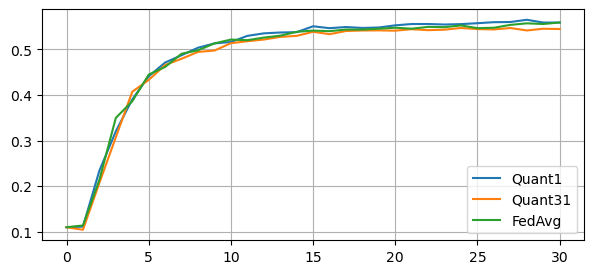

In [6]:
Bits1 = np.zeros([num_clients, num_global_iterations])
Bits31 = np.zeros([num_clients, num_global_iterations])

percentage1 = np.zeros([num_clients, num_global_iterations])
percentage31 = np.zeros([num_clients, num_global_iterations])

N_total1 = 0
N_total31 = 0
t_start = time.time()
#-----------------------------------------------------
for k in range(num_global_iterations):
    print(f"Global Iteration {k + 1}/{num_global_iterations}")
    

    # List to store client models for averaging
    client_models1 = []
    client_models31 = []
    client_models_FedAvg = []

    for i in range(num_clients):
        N_total1 = 0
        N_total31 = 0
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model1 = create_model()
        local_model1.set_weights(global_weights1)#global_model.get_weights())
        
        local_model31 = create_model()
        local_model31.set_weights(global_weights31)
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model1.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model1.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        local_model31.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model31.fit(x_local, y_local, epochs=local_epochs , verbose=0)
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight1 = np.array(local_model1.get_weights())-np.array(global_weights1)
            diff_local_global_weight31 = np.array(local_model31.get_weights())-np.array(global_weights31)
            
            local_weight_shape_0 = diff_local_global_weight1.shape[0]
            quantized_diff_local_global_weight1 = diff_local_global_weight1
            quantized_diff_local_global_weight31 = diff_local_global_weight31
            
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            
            Quantized_diff_local_global_weight1 = []
            Quantized_diff_local_global_weight31 = []
            
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(27*32,)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(7200*64,)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(quantized_diff_local_global_weight1[h].shape[0],)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(quantized_diff_local_global_weight31[h].shape[0],)

                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(10*64,)
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(10*64,)
                
#-------------Here, I evaluate the choices for Lambda--------------------------------------------------------
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight1 = np.concatenate((Quantized_diff_local_global_weight1,quantized_diff_local_global_weight1[h]))
                Quantized_diff_local_global_weight31 = np.concatenate((Quantized_diff_local_global_weight31,quantized_diff_local_global_weight31[h]))
           
            
            #Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight1, max_model1, min_model1, err1, n_max1, n_min1, x_min_me1= adaptive_signQuant_lambda(Quantized_diff_local_global_weight1, 
                                                                                                       Quantized_diff_local_global_weight1.shape[0], Lambda1[i],b_j)
            
            Bits1[i,k] = (462410 - n_max1 - n_min1) + b_j*(n_max1 + n_min1)
            #Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
            print('%----- Lambda1-------------------------------------')
            print('max:',np.max(Quantized_diff_local_global_weight1), '----min:',np.min(Quantized_diff_local_global_weight1))
            print('max error1:', np.max(np.abs(err1)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model1:', max_model1, 'min_model:', min_model1, 'x_min_me1:', x_min_me1)
            print('n_max1:', n_max1, 'n_min1:', n_min1, 'Lambda_j1:', Lambda1[i])
            N_total1 += n_max1 + n_min1
            percentage1[i,k]  = 100*(n_min1+n_max1)/462410
            print('percentage1 %:', percentage1[i,k] )
            
            print('%----- Lambda31-------------------------------------')
            Quantized_diff_local_global_weight31, max_model31, min_model31, err31, n_max31, n_min31, x_min_me31 = adaptive_signQuant_lambda(Quantized_diff_local_global_weight31, 
                                                                                                       Quantized_diff_local_global_weight31.shape[0], Lambda31[i],b_j)
            
            Bits31[i,k] = (462410 - n_max31 - n_min31) + b_j*(n_max31 + n_min31)
            #Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight31), '----min:',np.min(Quantized_diff_local_global_weight31))
            print('max error31:', np.max(np.abs(err31)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            print('max_model31:', max_model31, 'min_model31:', min_model31, 'x_min_me1:', x_min_me31)
            print('n_max31:', n_max31, 'n_min31:', n_min31, 'Lambda_j31:', Lambda31[i])
            N_total31 += n_max31 + n_min31
            percentage31[i,k]  = 100*(n_min31+n_max31)/462410
            print('percentage31 %:', percentage31[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[0:27*32]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(3, 3, 3, 32)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[0:27*32]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+32]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(32,)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+32]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(7200, 64)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+64]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(64,)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+64]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+640]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(64,10)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+640]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight1[h] = Quantized_diff_local_global_weight1[dim_h: dim_h+10]
                    quantized_diff_local_global_weight1[h] = quantized_diff_local_global_weight1[h].reshape(10,)
                    
                    quantized_diff_local_global_weight31[h] = Quantized_diff_local_global_weight31[dim_h: dim_h+10]
                    quantized_diff_local_global_weight31[h] = quantized_diff_local_global_weight31[h].reshape(10,)
                    dim_h += 10
            
            
            local_model1.set_weights(quantized_diff_local_global_weight1 + np.array(global_weights1))
            local_model31.set_weights(quantized_diff_local_global_weight31 + np.array(global_weights31))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models1.append(local_model1)
        client_models31.append(local_model31)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model.get_weights() for model in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights1 = np.mean([model.get_weights() for model in client_models1], axis=0)
        global_model1.set_weights(global_weights1)
        
        global_weights31 = np.mean([model.get_weights() for model in client_models31], axis=0)
        global_model31.set_weights(global_weights31)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('----------------------------For Lambda1-----------------------------------------------------')
    
    loss1, accuracy1 = global_model1.evaluate(x_test, y_test)
    print(f"Global Test loss1: {loss1:.4f}, Global Test accuracy1: {accuracy1:.4f}")
    global_acc_list1.append(accuracy1)
    global_loss_list1.append(loss1)
    
    print('----------------------------For Lambda31-----------------------------------------------------')
    
    loss31, accuracy31 = global_model31.evaluate(x_test, y_test)
    print(f"Global Test loss31: {loss31:.4f}, Global Test accuracy31: {accuracy31:.4f}")
    global_acc_list31.append(accuracy31)
    global_loss_list31.append(loss31)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list1)  
plt.plot(global_acc_list31)  
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant1','Quant31', 'FedAvg'])
plt.grid(True, which='major')    
t_stop = time.time()            
print('time:', t_stop - t_start)            
            
            

percentage 1: 30.19408407401801
1.9058917248761917
percentage 31: 18.201942540169977
1.5461274788607513


<Figure size 600x250 with 0 Axes>

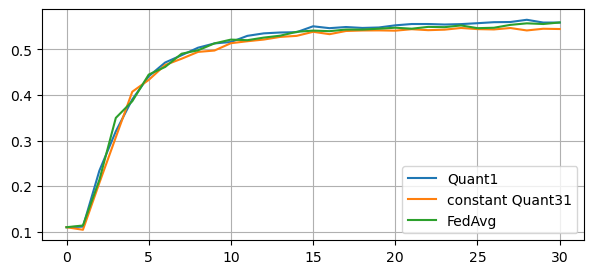

In [7]:
#,lambda1 and lamda31 K=40, L=3, b = 2,
plt.figure(figsize=(6, 2.5))
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list1)  
plt.plot(global_acc_list31)  
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant1','constant Quant31', 'FedAvg'])
plt.grid(True, which='major')  

print('percentage 1:',np.mean(percentage1))
print(np.mean((32+Bits1)/462410))

print('percentage 31:', np.mean(percentage31))
print(np.mean((32+Bits31)/462410))

percentage 1: 25.0463419908739
1.751459462381869
percentage constant lambda: 0.6504941502130144
1.0195840271620422


<Figure size 600x250 with 0 Axes>

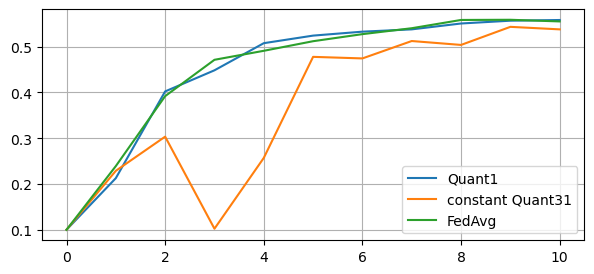

In [103]:
#,lambda1 and lamda31=0.25 K=20, L=3, b = 4,
plt.figure(figsize=(6, 2.5))
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list1)  
plt.plot(global_acc_list31)  
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant1','constant Quant31', 'FedAvg'])
plt.grid(True, which='major')  

print('percentage 1:',np.mean(percentage1))
print(np.mean((32+Bits1)/462410))

print('percentage constant lambda:', np.mean(percentage31))
print(np.mean((32+Bits31)/462410))

percentage 1: 22.8102982201942
1.6843781492614778
percentage 31: 5.642013581021172
1.169329610086287


<Figure size 600x250 with 0 Axes>

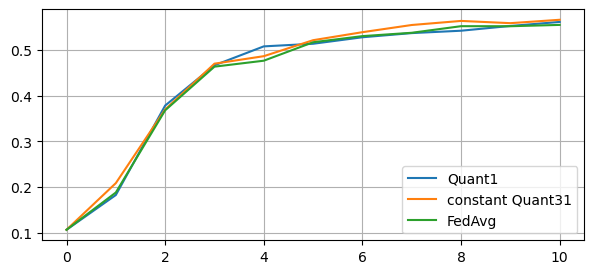

In [88]:
#,lambda1 and lamda31=0.1 K=20, L=3, b = 4,
plt.figure(figsize=(6, 2.5))
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list1)  
plt.plot(global_acc_list31)  
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant1','constant Quant31', 'FedAvg'])
plt.grid(True, which='major')  

print('percentage 1:',np.mean(percentage1))
print(np.mean((32+Bits1)/462410))

print('percentage 31:', np.mean(percentage31))
print(np.mean((32+Bits31)/462410))

1.144863021993469
1.0928392227676738


<Figure size 600x250 with 0 Axes>

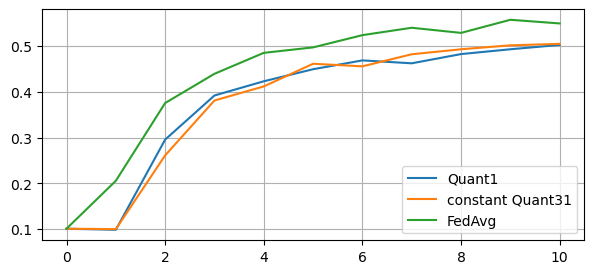

In [41]:
#,lambda1 and 31 K=20, L=3, b = 2,
plt.figure(figsize=(6, 2.5))
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list1)  
plt.plot(global_acc_list31)  
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant1','constant Quant31', 'FedAvg'])
plt.grid(True, which='major')  

#print(np.mean(percentage1))
print(np.mean((32+Bits1)/462410))

#print(np.mean(percentage31))
print(np.mean((32+Bits31)/462410))

# Power allocation considering bits, A, B, B_tilde , I_M

In [8]:
import numpy as np
import math
T=1
index = 0
tau_p = min(K,10) #Orthogonal sequences if tau_p=K, else tau_p = 10

tau_c = 200
prelogFactor = (tau_c-tau_p)/(tau_c)
BW = 20e6
B_tau = BW*prelogFactor 

eps = 0.01

# Function to check feasibility of power allocations and return power values
def check_feasibility(eta_t, A_bar, B_bar, B_tilde, I_M, beta, T, K, tolerance=1e-6):
    itr = 0
    powers = (1/K)*np.ones(K)
    powers_old = 10*(1/K)*np.ones(K)
    gamma_t = 2 ** (eta_t * beta) - 1
    while np.linalg.norm(powers - powers_old) > tolerance:
        itr += 1
        powers_old = np.copy(powers)
        for j in range(K):
            numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])
            denominator = A_bar[j] - gamma_t[j] * B_bar[j]
            if denominator <= 0:
                return False, None
            powers[j] = numerator / denominator
        # Check for iteration limit
        if itr > 1000:  # to avoid infinite loop
            break
    if np.any(powers < 0) or np.any(powers > 1):
        return False, None
    return True, powers

# Function to compute SINR_t^j given powers
def compute_SINR(eta_t, powers, A_bar, B_bar, B_tilde, I_M, beta, K):
    SINR = np.zeros(K)
    #gamma_t = 2 ** (eta_t * beta ) - 1
    for j in range(K):
        interference = np.sum(powers * B_tilde[j]) + I_M[j]
        SINR[j] = A_bar[j] * powers[j] / (B_bar[j] * powers[j] + interference)
    return SINR

# Function to compute latencies ell_t^j given SINR_t^j
def compute_latencies(SINR, beta, K):
    latencies = np.zeros(K)
    for j in range(K):
        if SINR[j] > 0:
            latencies[j] = beta[j] / math.log2(1 + SINR[j])
        else:
            latencies[j] = float('inf')  # Handle cases where SINR[j] is zero
    return latencies

# Bisection method to find maximum eta_t and store power allocations
def bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta, T, K, eta_t_lower=0.01, eta_t_upper=100, tolerance=1e-6):
    itr_Bis = 0
    best_eta_t = eta_t_lower
    best_powers = None
    while eta_t_upper - eta_t_lower > tolerance:
        itr_Bis += 1
        eta_t_mid = (eta_t_lower + eta_t_upper) / 2.0
        feasible, powers = check_feasibility(eta_t_mid, A_bar, B_bar, B_tilde, I_M, beta, T, K)
        if feasible:
            best_eta_t = eta_t_mid
            best_powers = powers
            eta_t_lower = eta_t_mid
        else:
            eta_t_upper = eta_t_mid
    #print('Bisection iteration:', itr_Bis)
    return best_eta_t, best_powers

# Example usage-----
beta = 1*Bits1/ (B_tau) 
max_eta_t, optimal_powers = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta[:,index], T, K)
if optimal_powers is None:
    print("No feasible power allocation found.")
else:
    print("Maximum eta_t:", max_eta_t)
    print("Optimal power allocations:", optimal_powers)

    # Compute SINR and latencies
    SINR_optimal = compute_SINR(max_eta_t, optimal_powers, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
    latencies_optimal = compute_latencies(SINR_optimal, beta[:,index], K)

    # Print latencies
    print("\nLatencies:")
    for j in range(K):
        print(f"User {j + 1}: {latencies_optimal[j]}")
    print(np.max(latencies_optimal))
print('-------------------------------------------------------------------------')

beta31 =1*Bits31/ (B_tau) 
max_eta_t31, optimal_powers31 = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta31[:,index], T, K)
if optimal_powers is None:
    print("No feasible power allocation found.")
else:
    print("Maximum eta_t:", max_eta_t31)
    print("Optimal power allocations:", optimal_powers31)
   # optimal_powers31=np.ones(K)
   # print("Optimal power allocations:", optimal_powers31)
    # Compute SINR and latencies
    SINR_optimal31 = compute_SINR(max_eta_t31, optimal_powers31, A_bar, B_bar, B_tilde, I_M, beta31[:,index], K)
    latencies_optimal31 = compute_latencies(SINR_optimal31, beta31[:,index], K)

    # Print latencies
    print("\nLatencies:")
    for j in range(K):
        print(f"User {j + 1}: {latencies_optimal31[j]}")
    print(np.max(latencies_optimal31))

Maximum eta_t: 26.931461746990678
Optimal power allocations: [0.01365485 0.01337867 0.00955262 0.00781354 0.020636   0.10276868
 0.09333583 0.01085711 0.25851872 0.00951527 0.2772449  0.0307058
 0.05972896 0.01260183 0.01549535 0.96378061 0.01491683 0.03787904
 0.0078801  0.99953936 0.03214828 0.18186928 0.05858237 0.27296922
 0.2902056  0.03833991 0.00765062 0.0999719  0.0203777  0.01715437
 0.03720746 0.01375323 0.01260344 0.04086531 0.07423936 0.01492562
 0.02726182 0.99941251 0.0106677  0.08358463]

Latencies:
User 1: 0.03715118885495169
User 2: 0.03714864874336495
User 3: 0.037152015233932634
User 4: 0.03714551443093891
User 5: 0.037150539950896753
User 6: 0.03715357001200794
User 7: 0.037154997443697345
User 8: 0.0371465646680256
User 9: 0.037154844897306256
User 10: 0.03714390774362092
User 11: 0.037148908887626765
User 12: 0.03714980511314511
User 13: 0.03714587760036389
User 14: 0.03714815006777319
User 15: 0.037142613206529965
User 16: 0.0371540593159735
User 17: 0.0371469556

C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1150764695.py:28: RuntimeWarning: overflow encountered in true_divide
  powers[j] = numerator / denominator
C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1150764695.py:24: RuntimeWarning: invalid value encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Maximum eta_t: 33.2212185805291
Optimal power allocations: [0.01510659 0.01513071 0.03460151 0.01468311 0.08090344 0.37794175
 0.22264354 0.00720569 0.4789783  0.02382171 0.49413585 0.01759881
 0.22098095 0.00835301 0.00493079 0.82306472 0.0244349  0.1224009
 0.04074654 0.99996485 0.04584151 0.09160516 0.14076457 0.00438062
 0.52551046 0.13194852 0.01587781 0.0425922  0.1262122  0.01621094
 0.08468234 0.08517751 0.00784799 0.24817301 0.11899829 0.00952274
 0.12369829 0.55028422 0.00788343 0.05726229]

Latencies:
User 1: 0.030117614275272625
User 2: 0.030116399444551863
User 3: 0.03011735643776939
User 4: 0.030113050943190264
User 5: 0.0301154842509783
User 6: 0.030116399667933443
User 7: 0.030115428805375436
User 8: 0.030114299078675657
User 9: 0.03011547349808212
User 10: 0.030111747159169
User 11: 0.030108638430885702
User 12: 0.030115193940367834
User 13: 0.030110163214086057
User 14: 0.030113102936858347
User 15: 0.0301144226132816
User 16: 0.0301143897555241
User 17: 0.03010953590

In [9]:
# lambda31 = 0.025, K40, L3, b4
for k in range(num_global_iterations):
    index = k
    print('---------------------------------------------------------')
    print('iteration:', k)
    max_eta_t, optimal_powers = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta[:,index], T, K)
    if optimal_powers is None:
        print("No feasible power allocation found.")
    else:
        print("Maximum eta_t:", max_eta_t)
       # print("Optimal power allocations:", optimal_powers)

        # Compute SINR and latencies
        SINR_optimal = compute_SINR(max_eta_t, optimal_powers, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
        latencies_optimal = compute_latencies(SINR_optimal, beta[:,index], K)

        # Print latencies
        #print("\nLatencies:")
        #for j in range(K):
            #print(f"User {j + 1}: {latencies_optimal[j]}")
        print('max latency:', np.max(latencies_optimal), 'at iteration:', k)
    
    
    
    
    
    
    
    max_eta_t31, optimal_powers31 = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta31[:,index], T, K)
    if optimal_powers is None:
        print("No feasible power allocation found.")
    else:
        print("Maximum eta_t:", max_eta_t31)
       # print("Optimal power allocations:", optimal_powers31)
   # optimal_powers31=np.ones(K)
   # print("Optimal power allocations:", optimal_powers31)
    # Compute SINR and latencies
        SINR_optimal31 = compute_SINR(max_eta_t31, optimal_powers31, A_bar, B_bar, B_tilde, I_M, beta31[:,index], K)
        latencies_optimal31 = compute_latencies(SINR_optimal31, beta31[:,index], K)

    # Print latencies
    #print("\nLatencies:")
   # for j in range(K):
    #    print(f"User {j + 1}: {latencies_optimal31[j]}")
    print('max latency:', np.max(latencies_optimal31), 'at iteration:', k)

---------------------------------------------------------
iteration: 0
Maximum eta_t: 26.931461746990678
max latency: 0.037154997443697345 at iteration: 0


C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1150764695.py:28: RuntimeWarning: overflow encountered in true_divide
  powers[j] = numerator / denominator
C:\Users\afmb\AppData\Local\Temp\ipykernel_11648\1150764695.py:24: RuntimeWarning: invalid value encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Maximum eta_t: 33.2212185805291
max latency: 0.030117614275272625 at iteration: 0
---------------------------------------------------------
iteration: 1
Maximum eta_t: 34.57957391373813
max latency: 0.028929854070402498 at iteration: 1
Maximum eta_t: 36.31906506806612
max latency: 0.027544481083449607 at iteration: 1
---------------------------------------------------------
iteration: 2
Maximum eta_t: 29.562614777162672
max latency: 0.03384487904618357 at iteration: 2
Maximum eta_t: 32.239123896062374
max latency: 0.031030079624637556 at iteration: 2
---------------------------------------------------------
iteration: 3
Maximum eta_t: 27.267744343280793
max latency: 0.0366975388483191 at iteration: 3
Maximum eta_t: 29.85282759048045
max latency: 0.03351120119980597 at iteration: 3
---------------------------------------------------------
iteration: 4
Maximum eta_t: 25.70482770092785
max latency: 0.03892591840541722 at iteration: 4
Maximum eta_t: 28.217361469715836
max latency: 0.035452

In [105]:
# lambda31 = 0.25, K20, L3, b4
for k in range(num_global_iterations):
    index = k
    print('---------------------------------------------------------')
    print('iteration:', k)
    max_eta_t, optimal_powers = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta[:,index], T, K)
    if optimal_powers is None:
        print("No feasible power allocation found.")
    else:
        print("Maximum eta_t:", max_eta_t)
       # print("Optimal power allocations:", optimal_powers)

        # Compute SINR and latencies
        SINR_optimal = compute_SINR(max_eta_t, optimal_powers, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
        latencies_optimal = compute_latencies(SINR_optimal, beta[:,index], K)

        # Print latencies
        #print("\nLatencies:")
        #for j in range(K):
            #print(f"User {j + 1}: {latencies_optimal[j]}")
        print('max latency:', np.max(latencies_optimal), 'at iteration:', k)
    
    
    
    
    
    
    
    max_eta_t31, optimal_powers31 = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta31[:,index], T, K)
    if optimal_powers is None:
        print("No feasible power allocation found.")
    else:
        print("Maximum eta_t:", max_eta_t31)
       # print("Optimal power allocations:", optimal_powers31)
   # optimal_powers31=np.ones(K)
   # print("Optimal power allocations:", optimal_powers31)
    # Compute SINR and latencies
        SINR_optimal31 = compute_SINR(max_eta_t31, optimal_powers31, A_bar, B_bar, B_tilde, I_M, beta31[:,index], K)
        latencies_optimal31 = compute_latencies(SINR_optimal31, beta31[:,index], K)

    # Print latencies
    #print("\nLatencies:")
   # for j in range(K):
    #    print(f"User {j + 1}: {latencies_optimal31[j]}")
    print('max latency:', np.max(latencies_optimal31), 'at iteration:', k)

---------------------------------------------------------
iteration: 0


C:\Users\afmb\AppData\Local\Temp\ipykernel_13648\1150764695.py:28: RuntimeWarning: overflow encountered in true_divide
  powers[j] = numerator / denominator
C:\Users\afmb\AppData\Local\Temp\ipykernel_13648\1150764695.py:24: RuntimeWarning: invalid value encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Maximum eta_t: 37.145170626118784
max latency: 0.02695585457401425 at iteration: 0
Maximum eta_t: 58.189178492650385
max latency: 0.017208435224462346 at iteration: 0
---------------------------------------------------------
iteration: 1
Maximum eta_t: 37.09448715999723
max latency: 0.02699035806877128 at iteration: 1
Maximum eta_t: 57.75577984027565
max latency: 0.017337666138210833 at iteration: 1
---------------------------------------------------------
iteration: 2
Maximum eta_t: 35.75344673454761
max latency: 0.0280062543157435 at iteration: 2
Maximum eta_t: 57.65343772456049
max latency: 0.01736873506182795 at iteration: 2
---------------------------------------------------------
iteration: 3
Maximum eta_t: 37.02323544293642
max latency: 0.02704265367043481 at iteration: 3
Maximum eta_t: 57.66602049678564
max latency: 0.017364698309484443 at iteration: 3
---------------------------------------------------------
iteration: 4
Maximum eta_t: 35.683670084923506
max latency: 0.0280593

In [93]:
# lambda31 = 0.1, K20, L3, b4
for k in range(num_global_iterations):
    index = k
    print('---------------------------------------------------------')
    print('iteration:', k)
    max_eta_t, optimal_powers = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta[:,index], T, K)
    if optimal_powers is None:
        print("No feasible power allocation found.")
    else:
        print("Maximum eta_t:", max_eta_t)
       # print("Optimal power allocations:", optimal_powers)

        # Compute SINR and latencies
        SINR_optimal = compute_SINR(max_eta_t, optimal_powers, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
        latencies_optimal = compute_latencies(SINR_optimal, beta[:,index], K)

        # Print latencies
        #print("\nLatencies:")
        #for j in range(K):
            #print(f"User {j + 1}: {latencies_optimal[j]}")
        print('max latency:', np.max(latencies_optimal), 'at iteration:', k)
    
    
    
    
    
    
    
    max_eta_t31, optimal_powers31 = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta31[:,index], T, K)
    if optimal_powers is None:
        print("No feasible power allocation found.")
    else:
        print("Maximum eta_t:", max_eta_t31)
       # print("Optimal power allocations:", optimal_powers31)
   # optimal_powers31=np.ones(K)
   # print("Optimal power allocations:", optimal_powers31)
    # Compute SINR and latencies
        SINR_optimal31 = compute_SINR(max_eta_t31, optimal_powers31, A_bar, B_bar, B_tilde, I_M, beta31[:,index], K)
        latencies_optimal31 = compute_latencies(SINR_optimal31, beta31[:,index], K)

    # Print latencies
    #print("\nLatencies:")
   # for j in range(K):
    #    print(f"User {j + 1}: {latencies_optimal31[j]}")
    print('max latency:', np.max(latencies_optimal31), 'at iteration:', k)

-----------------------------------------------
0
Bisection iteration: 27
Maximum eta_t: 34.10624712280929
max latency: 0.029337275421196584 at iteration: 0


C:\Users\afmb\AppData\Local\Temp\ipykernel_13648\2833901212.py:28: RuntimeWarning: overflow encountered in true_divide
  powers[j] = numerator / denominator
C:\Users\afmb\AppData\Local\Temp\ipykernel_13648\2833901212.py:24: RuntimeWarning: invalid value encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Bisection iteration: 27
Maximum eta_t: 58.388429559022185
max latency: 0.017150089959757364 at iteration: 0
-----------------------------------------------
1
Bisection iteration: 27
Maximum eta_t: 42.464480593055484
max latency: 0.023565491219970026 at iteration: 1
Bisection iteration: 27
Maximum eta_t: 57.324547600075604
max latency: 0.017467912604355585 at iteration: 1
-----------------------------------------------
2
Bisection iteration: 27
Maximum eta_t: 40.935733366385094
max latency: 0.024449068441944766 at iteration: 2
Bisection iteration: 27
Maximum eta_t: 54.592523051723845
max latency: 0.018342400579725703 at iteration: 2
-----------------------------------------------
3
Bisection iteration: 27
Maximum eta_t: 37.68863538369537
max latency: 0.026554337824801565 at iteration: 3
Bisection iteration: 27
Maximum eta_t: 53.764946896135804
max latency: 0.018624085056268027 at iteration: 3
-----------------------------------------------
4
Bisection iteration: 27
Maximum eta_t: 36.347

In [79]:
## b_j = 2

import numpy as np
import math
T=1
index = 9
tau_p = min(K,10) #Orthogonal sequences if tau_p=K, else tau_p = 10

tau_c = 200
prelogFactor = (tau_c-tau_p)/(tau_c)
BW = 20e6
B_tau = BW*prelogFactor 

eps = 0.01

# Function to check feasibility of power allocations and return power values
def check_feasibility(eta_t, A_bar, B_bar, B_tilde, I_M, beta, T, K, tolerance=1e-6):
    itr = 0
    powers = (1/K)*np.ones(K)
    powers_old = 10*(1/K)*np.ones(K)
    gamma_t = 2 ** (eta_t * beta) - 1
    while np.linalg.norm(powers - powers_old) > tolerance:
        itr += 1
        powers_old = np.copy(powers)
        for j in range(K):
            numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])
            denominator = A_bar[j] - gamma_t[j] * B_bar[j]
            if denominator <= 0:
                return False, None
            powers[j] = numerator / denominator
        # Check for iteration limit
        if itr > 1000:  # to avoid infinite loop
            break
    if np.any(powers < 0) or np.any(powers > 1):
        return False, None
    return True, powers

# Function to compute SINR_t^j given powers
def compute_SINR(eta_t, powers, A_bar, B_bar, B_tilde, I_M, beta, K):
    SINR = np.zeros(K)
    #gamma_t = 2 ** (eta_t * beta ) - 1
    for j in range(K):
        interference = np.sum(powers * B_tilde[j]) + I_M[j]
        SINR[j] = A_bar[j] * powers[j] / (B_bar[j] * powers[j] + interference)
    return SINR

# Function to compute latencies ell_t^j given SINR_t^j
def compute_latencies(SINR, beta, K):
    latencies = np.zeros(K)
    for j in range(K):
        if SINR[j] > 0:
            latencies[j] = beta[j] / math.log2(1 + SINR[j])
        else:
            latencies[j] = float('inf')  # Handle cases where SINR[j] is zero
    return latencies

# Bisection method to find maximum eta_t and store power allocations
def bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta, T, K, eta_t_lower=0.01, eta_t_upper=150, tolerance=1e-6):
    itr_Bis = 0
    best_eta_t = eta_t_lower
    best_powers = None
    while eta_t_upper - eta_t_lower > tolerance:
        itr_Bis += 1
        eta_t_mid = (eta_t_lower + eta_t_upper) / 2.0
        feasible, powers = check_feasibility(eta_t_mid, A_bar, B_bar, B_tilde, I_M, beta, T, K)
        if feasible:
            best_eta_t = eta_t_mid
            best_powers = powers
            eta_t_lower = eta_t_mid
        else:
            eta_t_upper = eta_t_mid
    print('Bisection iteration:', itr_Bis)
    return best_eta_t, best_powers

# Example usage-----
beta = 1*Bits1/ (B_tau) 
max_eta_t, optimal_powers = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta[:,index], T, K)
if optimal_powers is None:
    print("No feasible power allocation found.")
else:
    print("Maximum eta_t:", max_eta_t)
    print("Optimal power allocations:", optimal_powers)

    # Compute SINR and latencies
    SINR_optimal = compute_SINR(max_eta_t, optimal_powers, A_bar, B_bar, B_tilde, I_M, beta[:,index], K)
    latencies_optimal = compute_latencies(SINR_optimal, beta[:,index], K)

    # Print latencies
    print("\nLatencies:")
    for j in range(K):
        print(f"User {j + 1}: {latencies_optimal[j]}")
    print(np.max(latencies_optimal))
print('-------------------------------------------------------------------------')

beta31 = 1*Bits31/ (B_tau) 
max_eta_t31, optimal_powers31 = bisection_maximize_eta_t(A_bar, B_bar, B_tilde, I_M, beta31[:,index], T, K)
if optimal_powers is None:
    print("No feasible power allocation found.")
else:
    print("Maximum eta_t:", max_eta_t31)
    print("Optimal power allocations:", optimal_powers31)
    optimal_powers31=np.ones(K)
    print("Optimal power allocations:", optimal_powers31)
    # Compute SINR and latencies
    SINR_optimal31 = compute_SINR(max_eta_t31, optimal_powers31, A_bar, B_bar, B_tilde, I_M, beta31[:,index], K)
    latencies_optimal31 = compute_latencies(SINR_optimal31, beta31[:,index], K)

    # Print latencies
    print("\nLatencies:")
    for j in range(K):
        print(f"User {j + 1}: {latencies_optimal31[j]}")
    print(np.max(latencies_optimal31))

C:\Users\afmb\AppData\Local\Temp\ipykernel_13648\679222343.py:30: RuntimeWarning: overflow encountered in true_divide
  powers[j] = numerator / denominator
C:\Users\afmb\AppData\Local\Temp\ipykernel_13648\679222343.py:26: RuntimeWarning: invalid value encountered in multiply
  numerator = gamma_t[j] * (np.sum(powers * B_tilde[j]) + I_M[j])


Bisection iteration: 28
Maximum eta_t: 53.17364126708359
Optimal power allocations: [0.0359962  0.11390116 0.79778548 0.13003795 0.04109312 0.24208014
 0.12881253 0.11314709 0.0922631  0.99999942 0.08040937 0.31279877
 0.17340621 0.42433475 0.15527265 0.76312842 0.4889796  0.53250349
 0.75422254 0.21101053]

Latencies:
User 1: 0.018822900474671868
User 2: 0.018825612106679185
User 3: 0.01882668081874584
User 4: 0.018823409385401706
User 5: 0.018820241661673367
User 6: 0.018816667651226325
User 7: 0.018820896903134317
User 8: 0.018816948461548366
User 9: 0.018819928364814265
User 10: 0.018816647742735747
User 11: 0.01881187893412672
User 12: 0.018817511549951007
User 13: 0.01881526725278642
User 14: 0.01881996844516788
User 15: 0.01881142426561193
User 16: 0.018814639872933525
User 17: 0.01881214164949745
User 18: 0.018816038400121155
User 19: 0.01880635474421368
User 20: 0.0188063103479625
0.01882668081874584
-------------------------------------------------------------------------
Bis

In [10]:
acc_q1 = np.array(global_acc_list1)
acc_q31 = np.array(global_acc_list31)
acc_fed = np.array(global_acc_list_FedAvg)

# Base directory where you want to save the results
base_dir = 'C:/FedASi files'

# Prompt the user to input the folder name
#run_folder_name = input("Enter the folder name for this run: ")
run_folder_name = 'two lambdas_K40_L3_b4_T30'
run_folder_path = os.path.join(base_dir, run_folder_name)

# Create the directory if it doesn't exist
os.makedirs(run_folder_path, exist_ok=True)

# List of matrices to save and their respective filenames
matrices = {
    'A_bar': A_bar,
    'B_bar': B_bar,
    'Bits1' : Bits1,
    'Bits31' : Bits31,
    'percentage1': percentage1,
    'percentage31': percentage31,
    'I_M': I_M,
    'B_tilde': B_tilde,
    'Lambda': Lambda1,
    'acc_q1' : acc_q1,
    'acc_q31' : acc_q31,
    'acc_fed': acc_fed
    
    # Add more matrices here as needed
}

# Save each matrix to a .npy file in the specified folder
for name, matrix in matrices.items():
    file_name = os.path.join(run_folder_path, f'{name}.npy')
    np.save(file_name, matrix)
    print(f'{name} saved to {file_name}')


A_bar saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\A_bar.npy
B_bar saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\B_bar.npy
Bits1 saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\Bits1.npy
Bits31 saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\Bits31.npy
percentage1 saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\percentage1.npy
percentage31 saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\percentage31.npy
I_M saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\I_M.npy
B_tilde saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\B_tilde.npy
Lambda saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\Lambda.npy
acc_q1 saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\acc_q1.npy
acc_q31 saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\acc_q31.npy
acc_fed saved to C:/FedASi files\two lambdas_K40_L3_b4_T30\acc_fed.npy


In [10]:
#previous code:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the non-negative input data x with b bits.

    Parameters:
    x (numpy array): Non-negative input data to be quantized
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data
    """
    R = np.max(np.abs(x))
    # Number of quantization levels
    L = 2 ** b

    # Quantization step size
    delta = R / L

    # Uniform quantization
    x_clipped = np.clip(x, 0, R)  # Ensure values are within [0, R]
    quantized = np.round(x_clipped / delta) * delta

    return quantized
#-----------------------------------------------------------------------------
def adaptive_signQuant_lambda(main_vector, dim, lambda_j, b_j):
    mynum = 0
    l_norm = np.linalg.norm(main_vector, ord=np.inf)
    
    # Normalize each element of the vector 
    normalized_x = np.abs(main_vector) / l_norm

    # Identify the indices where the normalized value is greater than or equal to lambda
    indices = np.where(normalized_x >= lambda_j)[0]
    non_indices = np.where(normalized_x < lambda_j)[0]

    # Count the number of positive and negative elements among these indices
    positive_elements = main_vector[indices] > 0
    negative_elements = main_vector[indices] < 0

    n_max = np.sum(positive_elements)
    n_min = np.sum(negative_elements)

    x = np.copy(main_vector)
    x_q = mynum*np.ones_like(x)#*np.sign(x)
    x_q_temp = np.zeros_like(x)

    # Quantize values where normalized_x >= lambda_j
    for i in indices:
        x_q_temp[i] = np.abs(x[i])
    x_q0 = uniform_quantization(x_q_temp, b_j)
    for i in indices:
        x_q[i] = np.sign(x[i]) * x_q0[i]

    if n_max > 0:
        largest_values_indices = np.argsort(x_q)[-n_max:]
        largest_values = x_q[largest_values_indices]
    else:
        largest_values_indices = np.array([], dtype=int)
        largest_values = np.array([], dtype=x_q.dtype)

    # Find the n_min smallest values and their indices
    if n_min > 0:
        smallest_values_indices = np.argsort(x_q)[:n_min]
        smallest_values = x_q[smallest_values_indices]
    else:
        smallest_values_indices = np.array([], dtype=int)
        smallest_values = np.array([], dtype=x_q.dtype)

    if largest_values.size > 0:
        x_max = np.min(largest_values)
    else:
        x_max = 0

    if smallest_values.size > 0:
        x_min = np.max(smallest_values)
    else:
        x_min = 0
    x_min_me = min(x_max, np.abs(x_min))
    if x_min_me < 0.0001:
        x_min_me = 0.0001
    for i in range(len(main_vector)):
        if x_q[i] ==mynum:
            x_q[i] = (np.sign(x[i]) == 1)*x_min_me/2 - (np.sign(x[i]) == -1)*x_min_me/2
    
    x_quant = x_q
    err = main_vector - x_quant
    
    # Return the results
    return x_q, x_max, x_min, err, n_max, n_min, x_min_me 

